In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
import re
import xgbfir

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from geopy.distance import geodesic
geolocator = Nominatim(user_agent="my_request")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=0.3)

from eli5 import show_weights, explain_prediction

from tqdm.notebook import tqdm
tqdm.pandas()

from os.path import join as pjoin

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=24)
kf = KFold(n_splits=5, shuffle=True, random_state=24)

plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['image.cmap'] = 'nipy_spectral'
#sns.color_palette("summer", as_cmap=True)
sns.set_palette('summer')
plt.style.use('ggplot')

In [3]:
data = pd.read_csv('../data/real_estate_geo_2.csv')

### `rooms`

In [ ]:
data.rooms.unique()

array(['4', '3', '1', '2', '5', 'Вільне', '6'], dtype=object)

In [ ]:
data[data['rooms'] == 'Вільне'][['full_area', 'living_area']]

,full_area,living_area
470,120.0,95.0
4062,50.0,40.0
4754,48.1,18.5
6732,30.0,15.0


In [ ]:
data[data['free_planning'] == 1]

,id,price,rooms,floor,adress,district,subway,class,residential,description,...,refrigerator,jacuzzi,microwave,iron,cable_TV,location,lat,lon,min_dist_to_subway,dist_to_center
1311,10803242,38000,3,7,"Коломийський пров., 17/31",Голосіївський р-н,васильківська,Васильківська,ЖК Васильківський,Довгострокова оренда 3-х кімнатної квартири з ...,...,1,0,0,0,1,"ЛотОК, 17/31а, Коломийський провулок, Голосіїв...",50.393471,30.49080,0.422412,6.695681
6905,10810065,20000,3,14,"Драгомирова вул., 19б",Печерський р-н,NaN,NaN,ЖК Новопечерські Липки,Аренда 3-х квартири в ЖК Печерські Липки піс...,...,0,0,0,0,0,"Чічіко, 19-Б, вулиця Михайла Драгомирова, Ново...",50.407066,30.54399,1.140601,5.113108


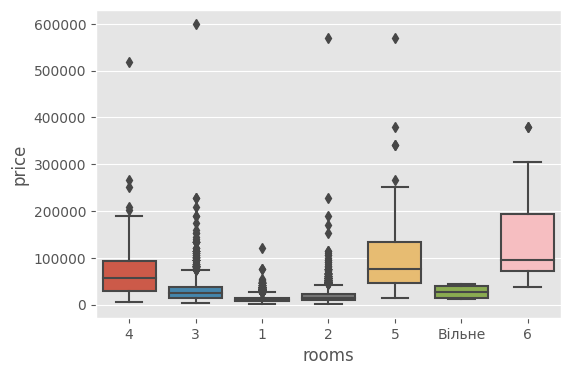

In [ ]:
sns.boxplot(x='rooms', y='price', data=data);

In [ ]:
data.loc[data['rooms'] == 'Вільне', 'rooms'] = 0

In [ ]:
data.loc[data['rooms'] == 0, 'free_planning'] = 1

In [ ]:
data[data['free_planning'] == 1]

,id,price,rooms,floor,adress,district,subway,class,residential,description,...,refrigerator,jacuzzi,microwave,iron,cable_TV,location,lat,lon,min_dist_to_subway,dist_to_center
470,10398243,45000,0,2,"Велика Васильківська вул. (Червоноармійська), 47",Печерський р-н,олімпійська,Доступна на короткий термін,Черепанова гора,"Будинок - стара цегла, квартира вільного плану...",...,1,1,0,0,0,"47, Велика Васильківська вулиця, Бессарабка, К...",50.434999,30.516471,0.403354,1.756135
1311,10803242,38000,3,7,"Коломийський пров., 17/31",Голосіївський р-н,васильківська,Васильківська,ЖК Васильківський,Довгострокова оренда 3-х кімнатної квартири з ...,...,1,0,0,0,1,"ЛотОК, 17/31а, Коломийський провулок, Голосіїв...",50.393471,30.490800,0.422412,6.695681
4062,10819168,16500,0,19,"Євгена Сверстюка вул. (Раскової Марини), 6Б",Дніпровський р-н,лівобережна,Лівобережна,ЖК Галактика,Здається світла і простора кваритра у жк «Гала...,...,1,0,1,1,1,"Трансформаторна підстанція, 6-Б, вулиця Євгена...",50.445806,30.604496,0.819574,5.975943
4754,10764600,38000,0,4,Дегтярна вул.,Подільський р-н,контрактова площа,Контрактова площа,ЖК Подол Град,"Мінімалістична, світла, функціонально наповнен...",...,0,0,0,0,0,"Дегтярна вулиця, Гончарі-Кожум’яки, Поділ, Под...",50.458195,30.510575,0.832266,1.112755
6732,9836715,11500,0,4,"Каховська вул., 60",Дніпровський р-н,лівобережна,Лівобережна,NaN,Идеально для одного или пары\nЕсть все для ком...,...,0,0,0,0,0,"COFFEE-PORT, 60, Каховська вулиця, Хутір, Ліво...",50.463101,30.591329,1.338820,5.206919
6905,10810065,20000,3,14,"Драгомирова вул., 19б",Печерський р-н,NaN,NaN,ЖК Новопечерські Липки,Аренда 3-х квартири в ЖК Печерські Липки піс...,...,0,0,0,0,0,"Чічіко, 19-Б, вулиця Михайла Драгомирова, Ново...",50.407066,30.543990,1.140601,5.113108


In [ ]:
data.rooms.unique()

array(['4', '3', '1', '2', '5', 0, '6'], dtype=object)

In [ ]:
data.rooms = data.rooms.astype('int8')

In [ ]:
data.rooms.dtypes

dtype('int8')

In [ ]:
data.to_csv('real_estate_geo_2.csv', index=False)

In [2]:
def get_X_y(df, features):
    X = df[features]
    y = df['price']
    return X, y

# get X_train, X_test, y_train, y_test from data
def get_train_test(df, feats, log=False):
    X = df[feats]
    if log:
        y = np.log1p(df['price'])
    else:
        y = df['price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)
    return X_train, X_test, y_train, y_test


def rmsle_score(y_true, y_pred):
    return mean_squared_log_error(y_true, y_pred, squared=False)


def calc_train_error(X_train, y_train, model, metric, target_log):
    '''returns in-sample error for already fit model.'''
    y_pred = model.predict(X_train)
    if target_log:
        y_pred = np.exp(y_pred)
        y_train = np.exp(y_train)
    y_pred[y_pred < 0] = 0
    #print(np.c_[y_train, y_pred][:5])
    return metric(y_train, y_pred)


def calc_validation_error(X_test, y_test, model, metric, target_log):
    '''returns out-of-sample error for already fit model.'''
    y_pred = model.predict(X_test)
    if target_log:
        y_pred = np.exp(y_pred)
    y_pred[y_pred < 0] = 0
    #print(np.c_[y_test, y_pred][:5])
    return metric(y_test, y_pred)


def calc_metrics(X_train, y_train, X_test, y_test, model, metric, target_log):
    '''fits model and returns the RMSLE for in-sample error and out-of-sample error'''
    if target_log:
       y_train = np.log(y_train)
    model.fit(X_train, y_train)
    train_error = calc_train_error(X_train, y_train, model, metric, target_log)
    validation_error = calc_validation_error(X_test, y_test, model, metric, target_log)
    return train_error, validation_error


def run_cv(model, X, y, folds=3, target_log=False, cv_type=KFold, success_metric=rmsle_score):
    cv = cv_type(n_splits=folds, shuffle=True, random_state=24)
    
    train_scores = []
    test_scores = []
    k = 0
    for train_idx, test_idx in cv.split(X, X['rooms']):
        X_train, X_test = X.iloc[train_idx, :], X.iloc[test_idx, :]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
       
        train_score, test_score = calc_metrics(X_train, y_train, X_test, y_test,
                                               model, success_metric, target_log)
        print(f"[Fold {k}] train_rmsle: {train_score:.4f}, test_rmsle: {test_score:.4f}")
        train_scores.append(train_score)
        test_scores.append(test_score)
        k += 1
        
    print(f"RMSLE: {np.mean(test_scores):.4f} ± {np.std(test_scores):.4f}")
    return

In [ ]:
black_list = ['id', 'price', 'price_log', 'class', 'residential', 'detail', 'description', 'subway_old']
feats = [col for col in data.columns if col not in black_list]
cat_feats = [col for col in data.columns if data[col].dtypes == 'object' and col not in black_list]
num_feats = [col for col in data.columns if data[col].dtypes != 'object' and col not in black_list]

X_train, X_test, y_train, y_test = get_train_test(data, num_feats, log=False)

parameters = {
    "objective": "reg:squarederror",
    "eval_metric": "rmsle",
    "eta": 0.1,
    "verbosity": 1,
    "seed": 24,
    "tree_method": "hist",
    "grow_policy": "lossguide",

    # regularization parameters
    "max_depth": 5,
    "max_leaves": 3,
    "subsample": 0.7,
    "colsample_bytree": 0.6,
}
model = xgb.XGBRegressor(**parameters)
run_cv(model, X_train, y_train, folds=5, target_log=False, cv_type=KFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.3755, test_rmsle: 0.3789
[Fold 1] train_rmsle: 0.3823, test_rmsle: 0.3967
[Fold 2] train_rmsle: 0.3749, test_rmsle: 0.3938
[Fold 3] train_rmsle: 0.3745, test_rmsle: 0.3923
[Fold 4] train_rmsle: 0.3704, test_rmsle: 0.3921
RMSLE: 0.3908 ± 0.0062


In [ ]:
data[data['free_planning'] == 1]['rooms']

470     0
1311    3
4062    0
4754    0
6732    0
6905    3
Name: rooms, dtype: int64

In [ ]:
data[data['rooms'] == 0]['full_area']

470     120.0
4062     50.0
4754     48.1
6732     30.0
Name: full_area, dtype: float64

In [ ]:
data.loc[data['rooms'] == 0, 'rooms'] = 1

In [ ]:
data['rooms'].value_counts()

rooms
2    2717
1    2341
3    1412
4     346
5      96
6      26
Name: count, dtype: int64

run_cv(model, X_train, y_train, folds=5, target_log=False, cv_type=KFold, success_metric=rmsle_score)

### cross_validation with StratifiedKFold by rooms

In [71]:
black_list = ['id', 'price', 'class', 'residential', 'detail', 'description', 'subway_old']
feats = [col for col in data.columns if col not in black_list]
cat_feats = [col for col in data.columns if data[col].dtypes == 'object' and col not in black_list]
num_feats = [col for col in data.columns if data[col].dtypes != 'object' and col not in black_list]

In [72]:
def get_X_y(df, features):
    X = df[features]
    y = df['price']
    return X, y


def rmsle_score(y_true, y_pred):
    return mean_squared_log_error(y_true, y_pred, squared=False)

In [73]:
def calc_train_error(X_train, y_train, model, metric, target_log):
    '''returns in-sample error for already fit model.'''
    y_pred = model.predict(X_train)
    if target_log:
        y_pred = np.exp(y_pred)
        y_train = np.exp(y_train)
    y_pred[y_pred < 0] = 0
    #print(np.c_[y_train, y_pred][:5])
    return metric(y_train, y_pred)


def calc_validation_error(X_test, y_test, model, metric, target_log):
    '''returns out-of-sample error for already fit model.'''
    y_pred = model.predict(X_test)
    if target_log:
        y_pred = np.exp(y_pred)
    y_pred[y_pred < 0] = 0
    #print(np.c_[y_test, y_pred][:5])
    return metric(y_test, y_pred)


def calc_metrics(X_train, y_train, X_test, y_test, model, metric, target_log):
    '''fits model and returns the RMSLE for in-sample error and out-of-sample error'''
    if target_log:
       y_train = np.log(y_train)
    model.fit(X_train, y_train)
    train_error = calc_train_error(X_train, y_train, model, metric, target_log)
    validation_error = calc_validation_error(X_test, y_test, model, metric, target_log)
    return train_error, validation_error

In [74]:
def run_cv(model, X, y, folds=3, target_log=False, cv_type=KFold, success_metric=rmsle_score):
    cv = cv_type(n_splits=folds, shuffle=True, random_state=24)
    
    train_scores = []
    test_scores = []
    k = 0
    for train_idx, test_idx in cv.split(X, X['rooms']):
        X_train, X_test = X.iloc[train_idx, :], X.iloc[test_idx, :]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
       
        train_score, test_score = calc_metrics(X_train, y_train, X_test, y_test,
                                               model, success_metric, target_log)
        print(f"[Fold {k}] train_rmsle: {train_score:.4f}, test_rmsle: {test_score:.4f}")
        train_scores.append(train_score)
        test_scores.append(test_score)
        k += 1
        
    print(f"RMSLE: {np.mean(test_scores):.4f} ± {np.std(test_scores):.4f}")
    return

In [ ]:
X, y = get_X_y(data, num_feats)

In [35]:
parameters = {
    "objective": "reg:squarederror",
    "eval_metric": "rmsle",
    "eta": 0.1,
    "verbosity": 1,
    "seed": 24,
    "tree_method": "hist",
    "grow_policy": "lossguide",

    # regularization parameters
    "max_depth": 5,
    "max_leaves": 3,
    "subsample": 0.7,
    "colsample_bytree": 0.6,
}
model = xgb.XGBRegressor(**parameters)
run_cv(model, X, y, folds=5, target_log=False,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.3759, test_rmsle: 0.3996
[Fold 1] train_rmsle: 0.3711, test_rmsle: 0.3862
[Fold 2] train_rmsle: 0.3883, test_rmsle: 0.3827
[Fold 3] train_rmsle: 0.3768, test_rmsle: 0.3667
[Fold 4] train_rmsle: 0.3699, test_rmsle: 0.3936
RMSLE: 0.3858 ± 0.0112


In [ ]:
parameters = {
    "objective": "reg:squarederror",
    "eval_metric": "rmsle",
    "eta": 0.1,
    "verbosity": 1,
    "seed": 24,
    "tree_method": "hist",
    "grow_policy": "lossguide",

    # regularization parameters
    "max_depth": 5,
    "max_leaves": 3,
    "subsample": 0.7,
    "colsample_bytree": 0.6,
}
model = xgb.XGBRegressor(**parameters)
run_cv(model, X, y, folds=5, target_log=True,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

d:\Мои Документы\Nata\DS\ml_course_work\env\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[Fold 0] train_rmsle: 0.3220, test_rmsle: 0.3268
[Fold 1] train_rmsle: 0.3234, test_rmsle: 0.3274
[Fold 2] train_rmsle: 0.3213, test_rmsle: 0.3369
[Fold 3] train_rmsle: 0.3197, test_rmsle: 0.3350
[Fold 4] train_rmsle: 0.3220, test_rmsle: 0.3316
RMSLE: 0.3315 ± 0.0040


### `district`

In [36]:
cat_feats

['adress', 'district', 'subway', 'location']

In [37]:
for feat in cat_feats:
    print(f"{feat}: {data[feat].nunique()} unique values")

adress: 3997 unique values
district: 11 unique values
subway: 52 unique values
location: 2893 unique values


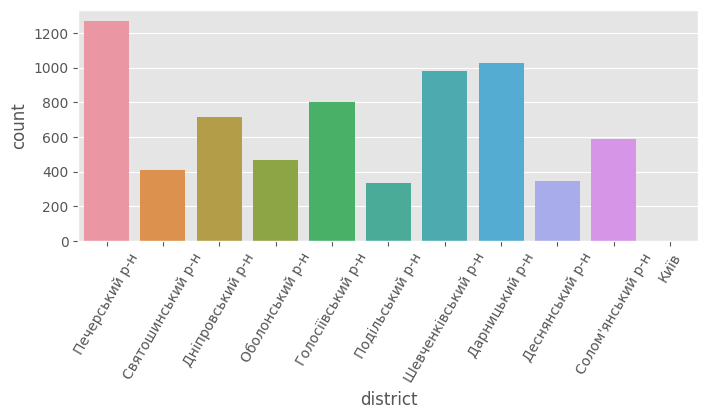

In [39]:
plt.figure(figsize=(8, 3))

ax = plt.subplot()
sns.countplot(x='district', data=data, orient='h', ax=ax)
ax.tick_params('x', labelrotation=60)

plt.show()

In [41]:
data['district'].value_counts(dropna=False)

district
Печерський р-н        1270
Дарницький р-н        1026
Шевченківський р-н     982
Голосіївський р-н      801
Дніпровський р-н       715
Солом'янський р-н      589
Оболонський р-н        466
Святошинський р-н      407
Деснянський р-н        348
Подільський р-н        333
Київ                     1
Name: count, dtype: int64

In [42]:
data[data['district'] == 'Київ']

,id,price,rooms,floor,adress,district,subway,class,residential,description,...,refrigerator,jacuzzi,microwave,iron,cable_TV,location,lat,lon,min_dist_to_subway,dist_to_center
4469,10343751,3999,1,8,"Воскресенський бульв. (Перова), 40",Київ,NaN,NaN,Проспект Романа Шухевича,Однокомнатная чистая квартира с мебелью и быто...,...,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN


In [2]:
loc = 'Воскресенський, 40'
#location = 
geolocator.geocode(loc)

Location(ПриватБанк, 40, Воскресенський проспект, 2-й мікрорайон Райдужного масиву, Воскресенка, Дніпровський район, Київ, 02139, Україна, (50.4863514, 30.5930758, 0.0))

In [47]:
data.loc[4469, 'district'] = 'Деснянський р-н'

In [3]:
data['district'].value_counts(dropna=False)

district
Печерський р-н        1270
Дарницький р-н        1026
Шевченківський р-н     982
Голосіївський р-н      801
Дніпровський р-н       715
Солом'янський р-н      589
Оболонський р-н        466
Святошинський р-н      407
Деснянський р-н        349
Подільський р-н        333
Name: count, dtype: int64

In [50]:
data.to_csv('../data/real_estate_geo_3.csv', index=False)

In [4]:
data['location'].isna().sum()

650

In [78]:
data[data['location'].isna()][['adress']]

,adress
25,"Героїв полку ""Азов"" вул. (Малиновського маршал..."
31,"Голосіївський просп. (40-річчя Жовтня), 30б"
65,"Лесі Українки бульв., 7Б"
69,"Героїв полку ""Азов"" вул. (Малиновського маршала)"
77,пер.Металлистов
...,...
6859,Воскресенський бульв. (Перова)
6862,"Голосіївський просп. (40-річчя Жовтня), 62"
6886,"Клавдієвська вул., 40 г"
6889,"Голосіївський просп. (40-річчя Жовтня), 74"


In [74]:
loc = 'Героїв полку "Азов" вул. '
#location = 
geolocator.geocode(loc)

Location(Героїв Полку Азов вулиця, Баси, Зарічний район, Суми, Сумська міська громада, Сумський район, Сумська область, 40018, Україна, (50.8727815, 34.8254348, 0.0))

In [66]:
loc = 'Голосіївський просп. (40-річчя Жовтня), 74'
"".join(re.split('.\(|\)', loc)[::2])

'Голосіївський просп., 74'

In [38]:
x = 'Воскресенський бульв. (Перова)'
"".join(re.split('.\(|\)', x)[::2]).replace('бульв.', '').replace('вул.', '').strip() + ', Київ'

'Воскресенський, Київ'

In [17]:
loc = 'Воскресенський, Київ'
geolocator.geocode(loc)

Location(Воскресенський проспект, 2-й мікрорайон Райдужного масиву, Воскресенка, Дніпровський район, Київ, 02139, Україна, (50.4881923, 30.5918699, 0.0))

In [18]:
data[data['location'].isna()][['adress']]

,adress
25,"Героїв полку ""Азов"" вул. (Малиновського маршал..."
65,"Лесі Українки бульв., 7Б"
77,пер.Металлистов
110,"Лесі Українки бульв., 7б"
119,"Верховної Ради бульв., 26"
...,...
6791,"Воскресенський бульв. (Перова), 16а"
6828,"Вацлава Гавела бульв. (Лепсе Івана), 9"
6850,"Івана Котляревського бульв. (Праці), 5"
6859,Воскресенський бульв. (Перова)


Заново запустила визначення location для кращого визначення координат

In [2]:
data = pd.read_csv('../data/real_estate_geo_3.csv')

In [6]:
data['location'] = (data['adress']
                    .apply(lambda x: "".join(re
                                             .split('.\(|\)', x)[::2])
                                             .replace('бульв.', '')
                                             .replace('вул.', '')
                                             .strip()
                                             + ', Київ')
                    .progress_apply(geocode))

  0%|          | 0/6938 [00:00<?, ?it/s]

RateLimiter caught an error, retrying (0/2 tries). Called with (*('Йорданська , 80-х р., Київ',), **{}).
Traceback (most recent call last):
  File "d:\Мои Документы\Nata\DS\ml_course_work\env\lib\site-packages\urllib3\connectionpool.py", line 449, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "d:\Мои Документы\Nata\DS\ml_course_work\env\lib\site-packages\urllib3\connectionpool.py", line 444, in _make_request
    httplib_response = conn.getresponse()
  File "C:\Users\Scar\anaconda3\envs\projector\lib\http\client.py", line 1374, in getresponse
    response.begin()
  File "C:\Users\Scar\anaconda3\envs\projector\lib\http\client.py", line 318, in begin
    version, status, reason = self._read_status()
  File "C:\Users\Scar\anaconda3\envs\projector\lib\http\client.py", line 279, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "C:\Users\Scar\anaconda3\envs\projector\lib\socket.py", line 705, in readinto
    ret

In [10]:
data['location']

0       (11, вулиця Михайла Драгомирова, Новопечерські...
1       (Шовковична, Садовий кооператив "Фізик", Гвозд...
2       (Гапонів доківська, Залізнична вулиця, Коцюбин...
3       (ЖК Каховська, Лівобережний масив, Дніпровськи...
4       (СУШИ-МАСТЕР, 26, Оболонський проспект, Оболон...
                              ...                        
6933    (Бутік Отік, 9, вулиця Івана Крамського, Скарб...
6934    (6-А, Академіка Кіпріанова вулиця, Микільська ...
6935    (Ощадбанк, 54, вулиця Данила Щербаківського, Н...
6936    (28-А, вулиця Василя Стуса, Академмістечко, Св...
6937    (3/5, Гродненська вулиця, Ліски, Дніпровський ...
Name: location, Length: 6938, dtype: object

In [11]:
data['location'].isna().sum()

125

In [13]:
data.to_csv('../data/real_estate_geo_location.csv', index=False)

In [17]:
data['lat'] = data['location'].apply(lambda x: x.latitude if x else None)
data['lon'] = data['location'].apply(lambda x: x.longitude if x else None)

In [18]:
data['lat'].isna().sum(), data['lon'].isna().sum()

(125, 125)

In [39]:
data.to_csv('../data/real_estate_geo_location.csv', index=False)

In [152]:
data = pd.read_csv('../data/real_estate_geo_location.csv')

Find rows, where there are out of Kyiv city. Then let's change geo information for these rows and empty rows with district geo information.

In [19]:
min_lon = 30.2315079
max_lon = 30.825220
min_lat = 50.213573
max_lat = 50.590735

In [20]:
data.loc[(data['lat'] > max_lat) | (data['lat'] < min_lat), ['adress', 'location', 'lat', 'lon']] 

,adress,location,lat,lon
65,"Лесі Українки бульв., 7Б","(Лесі Українки, Буда-Бабинецька, Бучанська міс...",50.621758,30.062062
110,"Лесі Українки бульв., 7б","(Лесі Українки, Буда-Бабинецька, Бучанська міс...",50.621758,30.062062
159,"Лесі Українки бульв., 7б","(Лесі Українки, Буда-Бабинецька, Бучанська міс...",50.621758,30.062062
177,"Лесі Українки бульв., 19","(Лесі Українки, Буда-Бабинецька, Бучанська міс...",50.621758,30.062062
181,"Лесі Українки бульв., 19","(Лесі Українки, Буда-Бабинецька, Бучанська міс...",50.621758,30.062062
...,...,...,...,...
6655,"Лесі Українки бульв., 7Б","(Лесі Українки, Буда-Бабинецька, Бучанська міс...",50.621758,30.062062
6674,"Науки просп., 55а","(Науки проспект, Гребінки, Гребінківська селищ...",49.950440,30.192813
6750,пров.Перемоги,"(провулок Перемоги, Богуслав, Богуславська міс...",49.550657,30.857531
6819,"Леваневського, 7","(7, Пантелеймона Куліша вулиця, 3-й мікрорайон...",49.782121,30.144163


In [26]:
idx_to_change_lat_lon = data.loc[(data['lat'] > max_lat) | (data['lat'] < min_lat), ['adress', 'location', 'lat', 'lon']].index.to_list()

In [28]:
len(idx_to_change_lat_lon)

215

In [23]:
data.loc[(data['lon'] > max_lon) | (data['lon'] < min_lon), ['adress', 'location', 'lat', 'lon']]

,adress,location,lat,lon
65,"Лесі Українки бульв., 7Б","(Лесі Українки, Буда-Бабинецька, Бучанська міс...",50.621758,30.062062
110,"Лесі Українки бульв., 7б","(Лесі Українки, Буда-Бабинецька, Бучанська міс...",50.621758,30.062062
125,Тургенєвська вул.,"(Тургенєвська вулиця, Ірпінь, Ірпінська міська...",50.526149,30.229158
159,"Лесі Українки бульв., 7б","(Лесі Українки, Буда-Бабинецька, Бучанська міс...",50.621758,30.062062
177,"Лесі Українки бульв., 19","(Лесі Українки, Буда-Бабинецька, Бучанська міс...",50.621758,30.062062
...,...,...,...,...
6674,"Науки просп., 55а","(Науки проспект, Гребінки, Гребінківська селищ...",49.950440,30.192813
6750,пров.Перемоги,"(провулок Перемоги, Богуслав, Богуславська міс...",49.550657,30.857531
6819,"Леваневського, 7","(7, Пантелеймона Куліша вулиця, 3-й мікрорайон...",49.782121,30.144163
6821,"Науки просп., 58","(Науки проспект, Гребінки, Гребінківська селищ...",49.950440,30.192813


In [29]:
idx_to_change_lat_lon_2 = data.loc[(data['lon'] > max_lon) | (data['lon'] < min_lon), ['adress', 'location', 'lat', 'lon']].index.to_list()

In [30]:
len(idx_to_change_lat_lon_2)

272

In [32]:
idx_to_change_lat_lon.extend(idx_to_change_lat_lon_2)

In [33]:
len(idx_to_change_lat_lon)

487

In [44]:
idx_to_change_lat_lon = list(set(idx_to_change_lat_lon))
len(idx_to_change_lat_lon)

287

In [315]:
def read_data(file):
    return pd.read_csv(f'../data/{file}')


df_ = read_data('subway_location.csv')
df_

,subway,subway_lat,subway_lon
0,деміївська,50.404655,30.516361
1,іподром,50.375646,30.466451
2,вирлиця,50.403076,30.663653
3,дарниця,50.455608,30.613805
4,героїв дніпра,50.523104,30.496700
5,печерська,50.427274,30.536818
6,либідська,50.412432,30.522650
7,кловська,50.437083,30.532243
8,поштова площа,50.458958,30.522469
9,теремки,50.378757,30.441980


Add columns with district location

In [37]:
df_district_location = pd.read_csv('../data/district_location.csv')

In [40]:
data['district'] = data['district'].apply(lambda x: x.split(' ')[0])

In [41]:
data = data.merge(df_district_location, how='left', on='district')

In [42]:
data.columns

Index(['id', 'price', 'rooms', 'floor', 'adress', 'district', 'subway',
       'class', 'residential', 'description', 'detail', 'full_area',
       'living_area', 'kitchen_area', 'num_storeys', 'subway_old',
       'typical_panel', 'concrete_monolithic', 'old_brick', 'first_rental',
       'adjacent_separate', 'ukrainian_brick', 'eurorenovation',
       'satisfactory_condition', 'multilevel', 'needs_cosmetic_repairs',
       'kitchen_living_room', 'penthouse', 'old_panel', 'good_condition',
       'pre_revolutionary', 'needs_major_repairs', 'gas_block',
       'repair_in_progress', 'free_planning', 'adjacent', 'separate',
       'ukrainian_panel', 'Stalinka', 'excellent_condition', 'studio',
       'designer_renovation', 'safe', 'shower_cabin', 'wardrobe', 'TV',
       'hair_dryer', 'dishes', 'satellite_TV', 'DVD_player', 'washing_machine',
       'fireplace', 'dishwashers', 'alarms', 'bed', 'counters',
       'air_conditioning', 'refrigerator', 'jacuzzi', 'microwave', 'iron',
       '

In [45]:
data.loc[idx_to_change_lat_lon, 'lat'] = data.loc[idx_to_change_lat_lon, 'district_lat']
data.loc[idx_to_change_lat_lon, 'lon'] = data.loc[idx_to_change_lat_lon, 'district_lon']

In [46]:
data['lat'].fillna(data['district_lat'], inplace=True)
data['lon'].fillna(data['district_lon'], inplace=True)

In [47]:
data['lat'].isna().sum(), data['lon'].isna().sum()

(0, 0)

In [ ]:
data.to_csv('../data/real_estate_geo_location_fix_error.csv', index=False)

In [31]:
data['location'].apply(lambda x: 'Київ,' not in str(x).split(' ') if x else None).sum()

497

If 'Київ' not in `location` replace `lat` and `lon` with `district_lat`/`district_lon`

In [32]:
data.loc[data['location'].apply(lambda x: 'Київ,' not in str(x).split(' ') if x else None), ['adress', 'location', 'lat', 'lon']]

,adress,location,lat,lon
1,Шовковична вул.,"Шовковична, Садовий кооператив ""Фізик"", Гвозді...",50.256363,30.477325
2,Доковська вул.,"Гапонів доківська, Залізнична вулиця, Коцюбинс...",50.488823,30.334814
65,"Лесі Українки бульв., 7Б","Лесі Українки, Буда-Бабинецька, Бучанська місь...",50.445827,30.538062
77,пер.Металлистов,NaN,50.439856,30.488655
110,"Лесі Українки бульв., 7б","Лесі Українки, Буда-Бабинецька, Бучанська місь...",50.445827,30.538062
...,...,...,...,...
6750,пров.Перемоги,"провулок Перемоги, Богуслав, Богуславська місь...",50.467421,30.463848
6819,"Леваневського, 7","7, Пантелеймона Куліша вулиця, 3-й мікрорайон,...",50.439856,30.488655
6821,"Науки просп., 58","Науки проспект, Гребінки, Гребінківська селищн...",50.384401,30.487054
6842,"Княжий Затон вул., 11","Княжий затон, Золочівська сільська громада, Бо...",50.316370,30.664702


In [34]:
idx_for_apdate_geo = data.loc[data['location'].apply(lambda x: 'Київ,' not in str(x).split(' ') if x else None), ['adress', 'location', 'lat', 'lon']].index.to_list()
len(idx_for_apdate_geo)

497

In [36]:
data.loc[idx_for_apdate_geo, 'lat'] = data.loc[idx_for_apdate_geo, 'district_lat']
data.loc[idx_for_apdate_geo, 'lon'] = data.loc[idx_for_apdate_geo, 'district_lon']

In [37]:
data.to_csv('../data/real_estate_geo_location_fix_error.csv', index=False)

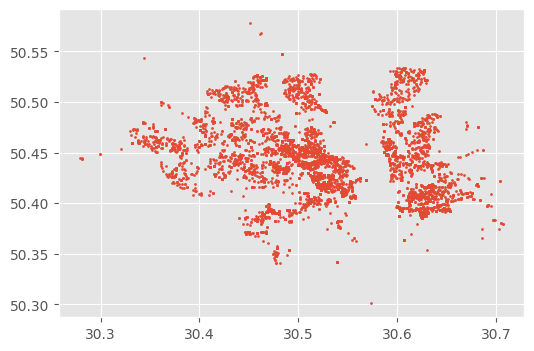

In [40]:
plt.scatter(data['lon'], data['lat'], s=2);

`min_dist_to_subway`

In [2]:
data = pd.read_csv('../data/real_estate_geo_location_fix_error.csv')
data.columns

Index(['id', 'price', 'rooms', 'floor', 'adress', 'district', 'subway',
       'class', 'residential', 'description', 'detail', 'full_area',
       'living_area', 'kitchen_area', 'num_storeys', 'subway_old',
       'typical_panel', 'concrete_monolithic', 'old_brick', 'first_rental',
       'adjacent_separate', 'ukrainian_brick', 'eurorenovation',
       'satisfactory_condition', 'multilevel', 'needs_cosmetic_repairs',
       'kitchen_living_room', 'penthouse', 'old_panel', 'good_condition',
       'pre_revolutionary', 'needs_major_repairs', 'gas_block',
       'repair_in_progress', 'free_planning', 'adjacent', 'separate',
       'ukrainian_panel', 'Stalinka', 'excellent_condition', 'studio',
       'designer_renovation', 'safe', 'shower_cabin', 'wardrobe', 'TV',
       'hair_dryer', 'dishes', 'satellite_TV', 'DVD_player', 'washing_machine',
       'fireplace', 'dishwashers', 'alarms', 'bed', 'counters',
       'air_conditioning', 'refrigerator', 'jacuzzi', 'microwave', 'iron',
       '

In [3]:
df_subway_location = pd.read_csv('../data/subway_location.csv')

In [41]:
del data['min_dist_to_subway']

In [43]:
def get_min_dist_to_subway(row):
    adr_loc = (row['lat'], row['lon'])
    list_dist = []
    for station in df_subway_location['subway']:
        idx = (df_subway_location
               .index[df_subway_location['subway'] == station]
               .values[0])
        subway_loc = (df_subway_location.at[idx, 'subway_lat'],
                      df_subway_location.at[idx, 'subway_lon'])
        list_dist.append(geodesic(adr_loc, subway_loc).kilometers)
    return min(list_dist)

data['min_dist_to_subway'] = data.progress_apply(get_min_dist_to_subway, axis=1)

  0%|          | 0/6938 [00:00<?, ?it/s]

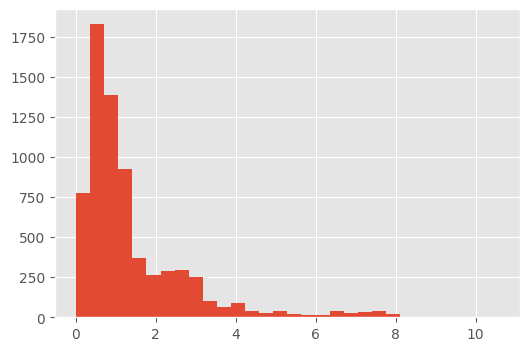

In [58]:
data['min_dist_to_subway'].hist(bins=30);

In [59]:
data.loc[data['min_dist_to_subway'] > 8, ['adress', 'location', 'lat', 'lon']]

,adress,location,lat,lon
4363,Федора Максименка вул. (Червонофлотська),"вулиця Федора Максименка, Пуща-Водиця, Оболонс...",50.543836,30.343774
4391,"Матикіна генерала вул., 16","16, Генерала Матикіна вулиця, Конча-Заспа, Гол...",50.301042,30.573204


`dist_to_center`

In [60]:
centre_loc = (50.450555, 30.5206892) # geo of Kyiv centre
centre_loc

(50.450555, 30.5206892)

In [62]:
def get_dist_to_center(row):
    adr_loc = (row['lat'], row['lon'])
    dist = geodesic(adr_loc, centre_loc).kilometers
    return dist

In [64]:
data['dist_to_center'] = data.progress_apply(get_dist_to_center, axis=1)

  0%|          | 0/6938 [00:00<?, ?it/s]

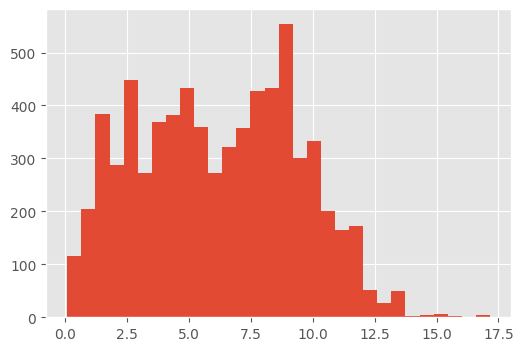

In [65]:
data['dist_to_center'].hist(bins=30);

In [70]:
data.to_csv('../data/real_estate_geo_location_fix_error.csv', index=False)

Results for these features

In [100]:
black_list = ['id', 'price', 'class', 'residential', 'detail', 'description', 'subway_old']
feats = [col for col in data.columns if col not in black_list]
cat_feats = [col for col in data.columns if data[col].dtypes == 'object' and col not in black_list]
num_feats = [col for col in data.columns if data[col].dtypes != 'object' and col not in black_list]

In [76]:
X, y = get_X_y(data, num_feats)

parameters = {
    "objective": "reg:squarederror",
    "eval_metric": "rmsle",
    "eta": 0.1,
    "verbosity": 1,
    "seed": 24,
    "tree_method": "hist",
    "grow_policy": "lossguide",

    # regularization parameters
    "max_depth": 5,
    "max_leaves": 3,
    "subsample": 0.7,
    "colsample_bytree": 0.6,
}
model = xgb.XGBRegressor(**parameters)
run_cv(model, X, y, folds=5, target_log=False, cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.3666, test_rmsle: 0.3841
[Fold 1] train_rmsle: 0.3601, test_rmsle: 0.3758
[Fold 2] train_rmsle: 0.3766, test_rmsle: 0.3776
[Fold 3] train_rmsle: 0.3661, test_rmsle: 0.3591
[Fold 4] train_rmsle: 0.3615, test_rmsle: 0.3841
RMSLE: 0.3761 ± 0.0092


In [77]:
run_cv(model, X, y, folds=5, target_log=True, cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.3114, test_rmsle: 0.3338
[Fold 1] train_rmsle: 0.3115, test_rmsle: 0.3290
[Fold 2] train_rmsle: 0.3164, test_rmsle: 0.3053
[Fold 3] train_rmsle: 0.3129, test_rmsle: 0.3055
[Fold 4] train_rmsle: 0.3117, test_rmsle: 0.3328
RMSLE: 0.3213 ± 0.0131


### `district` to OneHotEncoder

In [114]:
feats_new = num_feats + ['district']

In [149]:
len(feats_new)

59

In [115]:
X, y = get_X_y(data, feats_new)

In [150]:
data[feats_new].isna().sum().sum()

0

In [151]:
transformer = ColumnTransformer(
    [('OneHot', OneHotEncoder(), ['district'])],
    remainder='passthrough',
    verbose_feature_names_out=False
)

pipeline = Pipeline([
    ('transform', transformer),
    ('regr', model)
])

In [152]:
model = xgb.XGBRegressor(**parameters)

run_cv(pipeline, X, y, folds=5, target_log=False,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.3676, test_rmsle: 0.3880
[Fold 1] train_rmsle: 0.3589, test_rmsle: 0.3725
[Fold 2] train_rmsle: 0.3714, test_rmsle: 0.3626
[Fold 3] train_rmsle: 0.3689, test_rmsle: 0.3616
[Fold 4] train_rmsle: 0.3605, test_rmsle: 0.3880
RMSLE: 0.3746 ± 0.0116


Previous result: 0.3761 ± 0.0092

In [153]:
run_cv(pipeline, X, y, folds=5, target_log=True,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.3053, test_rmsle: 0.3279
[Fold 1] train_rmsle: 0.3064, test_rmsle: 0.3244
[Fold 2] train_rmsle: 0.3127, test_rmsle: 0.3018
[Fold 3] train_rmsle: 0.3103, test_rmsle: 0.3054
[Fold 4] train_rmsle: 0.3096, test_rmsle: 0.3298
RMSLE: 0.3179 ± 0.0118


Previous result: 0.3213 ± 0.0131

### `district` to LabelEncoder

In [154]:
transformer = ColumnTransformer(
    [('labelEnc', OrdinalEncoder(), ['district'])],
    remainder='passthrough',
    verbose_feature_names_out=False
)

pipeline = Pipeline([
    ('transform', transformer),
    ('regr', model)
])

model = xgb.XGBRegressor(**parameters)

run_cv(pipeline, X, y, folds=5, target_log=False,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.3722, test_rmsle: 0.3887
[Fold 1] train_rmsle: 0.3633, test_rmsle: 0.3794
[Fold 2] train_rmsle: 0.3786, test_rmsle: 0.3735
[Fold 3] train_rmsle: 0.3653, test_rmsle: 0.3567
[Fold 4] train_rmsle: 0.3647, test_rmsle: 0.3867
RMSLE: 0.3770 ± 0.0115


In [155]:
run_cv(pipeline, X, y, folds=5, target_log=True,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.3110, test_rmsle: 0.3345
[Fold 1] train_rmsle: 0.3107, test_rmsle: 0.3275
[Fold 2] train_rmsle: 0.3150, test_rmsle: 0.3042
[Fold 3] train_rmsle: 0.3145, test_rmsle: 0.3074
[Fold 4] train_rmsle: 0.3093, test_rmsle: 0.3316
RMSLE: 0.3210 ± 0.0127


We got worse results, so leave OheHot Encoding for `district`

### Features vs Price

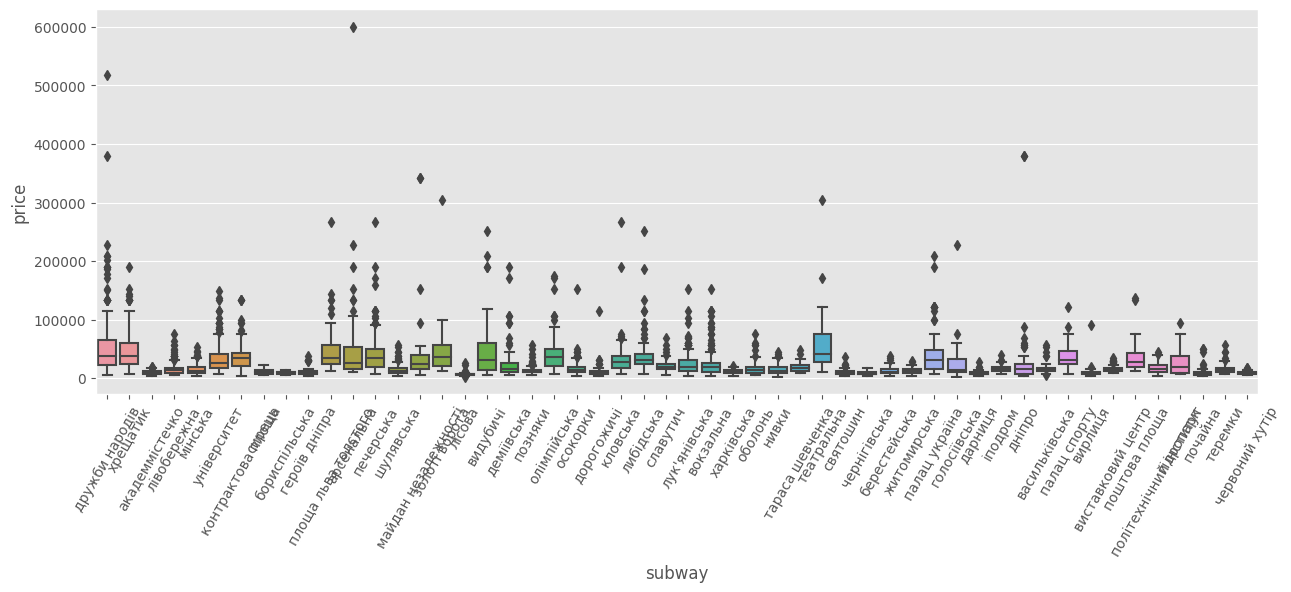

In [158]:
plt.figure(figsize=(15, 5))

ax = plt.subplot()
sns.boxplot(x='subway', y='price', data=data, ax=ax)
ax.tick_params('x', labelrotation=60)

plt.show()

In [160]:
data[data['price'] > 300_000]

,id,price,rooms,floor,adress,district,subway,class,residential,description,...,microwave,iron,cable_TV,location,lat,lon,district_lat,district_lon,min_dist_to_subway,dist_to_center
233,10458331,570000,5,5,"Ломаківська вул. (Мічуріна), 56/2",Печерський,NaN,ПРЕМІУМ,Пам'ятник засновникам Києва,Добро пожаловать в роскошные апартаменты в клу...,...,1,0,0,"56/2, Ломаківська вулиця, Наводничі, Звіринець...",50.421450,30.562718,50.445827,30.538062,1.377801,4.404266
2169,10807023,380000,6,15,"Мазепи Івана вул. (Січневого Повстання), 11б",Печерський,дніпро,БЕЗ КОМІСІЇ,Печерськ,Опис\nЭксклюзивные апартаменты в ЖК «Diamond H...,...,0,0,0,"Салют, 11-Б, вулиця Івана Мазепи, Хрести, Пече...",50.441572,30.550562,50.445827,30.538062,0.413056,2.345401
2456,10796998,342000,5,3,"Володимирська вул., 20/1а",Шевченківський,майдан незалежності,БЕЗ КОМІСІЇ,Пейзажна алея,"Володимирська, 20/1а, ст.Метро ""Золоті Ворота""...",...,1,1,1,"Classic club, 20/1-А, Володимирська вулиця, Го...",50.453707,30.515503,50.467421,30.463848,0.625523,0.508545
3095,10807914,342000,5,3,"Володимирська вул., 20",Шевченківський,майдан незалежності,БЕЗ КОМІСІЇ,Пейзажна алея,"Без комісії, вул. Володимирська, 20/1, 5-ти кі...",...,0,0,0,"Classic club, 20/1-А, Володимирська вулиця, Го...",50.453707,30.515503,50.467421,30.463848,0.625523,0.508545
3573,10640634,570000,2,5,"Болсуновський пров. (Мічуріна), 35",Печерський,NaN,БЕЗ КОМІСІЇ,Пам'ятник засновникам Києва,Такого Вы не видели. Обращайтесь) [ссылка скрыта],...,0,0,0,"Болсуновський провулок, Наводничі, Звіринець, ...",50.420532,30.554327,50.445827,30.538062,0.788311,4.106624
3677,10657968,380000,6,8,"Мазепи Івана вул. (Січневого Повстання), 11б",Печерський,дніпро,БЕЗ КОМІСІЇ,ЖК Diamond Hill,Видовые апартаменты представительского класса ...,...,0,0,0,"Салют, 11-Б, вулиця Івана Мазепи, Хрести, Пече...",50.441572,30.550562,50.445827,30.538062,0.413056,2.345401
4773,8932774,304000,6,15,"Гончара Олеся вул., 35",Шевченківський,золоті ворота,БЕЗ КОМІСІЇ,NaN,Здам 7-к двурівневу квартиру на 15му і 16му по...,...,0,0,1,"35, вулиця Олеся Гончара, Городище Кия, Старий...",50.451020,30.507697,50.467421,30.463848,0.675306,0.924188
5035,10830459,380000,5,9,"Драгомирова вул., 11Б",Печерський,дружби народів,ПРЕМІУМ,ЖК Новопечерські Липки,Предлагаются в аренду Новые дизайнерские 5-ком...,...,1,1,0,"11-Б, вулиця Михайла Драгомирова, Новопечерськ...",50.408836,30.548118,50.445827,30.538062,0.978697,5.033319
6066,10830532,518000,4,20,"Драгомирова вул., 20",Печерський,дружби народів,Дружби народів,ЖК Новопечерські Липки,Аренда 4-комнатной квартиры в жилом комплексе ...,...,1,0,0,"Мільфей, 20, вулиця Михайла Драгомирова, Новоп...",50.409287,30.544095,50.445827,30.538062,0.893399,4.882500
6530,10557343,304000,6,16,"Гончара Олеся вул., 35",Шевченківський,театральна,БЕЗ КОМІСІЇ,Ботанічний сад ім. акад. О. В. Фоміна,"Просторный 7-комнатный пентхаус 310 м2, в ЖК Д...",...,0,0,0,"35, вулиця Олеся Гончара, Городище Кия, Старий...",50.451020,30.507697,50.467421,30.463848,0.675306,0.924188


In [168]:
data.iloc[6792, 40:60]

studio                 0
designer_renovation    0
safe                   0
shower_cabin           0
wardrobe               0
TV                     0
hair_dryer             0
dishes                 0
satellite_TV           0
DVD_player             0
washing_machine        0
fireplace              0
dishwashers            0
alarms                 0
bed                    0
counters               0
air_conditioning       0
refrigerator           0
jacuzzi                0
microwave              0
Name: 6792, dtype: object

In [169]:
data.drop(6792, inplace=True)

In [170]:
data[data['price'] > 300_000]

,id,price,rooms,floor,adress,district,subway,class,residential,description,...,microwave,iron,cable_TV,location,lat,lon,district_lat,district_lon,min_dist_to_subway,dist_to_center
233,10458331,570000,5,5,"Ломаківська вул. (Мічуріна), 56/2",Печерський,NaN,ПРЕМІУМ,Пам'ятник засновникам Києва,Добро пожаловать в роскошные апартаменты в клу...,...,1,0,0,"56/2, Ломаківська вулиця, Наводничі, Звіринець...",50.421450,30.562718,50.445827,30.538062,1.377801,4.404266
2169,10807023,380000,6,15,"Мазепи Івана вул. (Січневого Повстання), 11б",Печерський,дніпро,БЕЗ КОМІСІЇ,Печерськ,Опис\nЭксклюзивные апартаменты в ЖК «Diamond H...,...,0,0,0,"Салют, 11-Б, вулиця Івана Мазепи, Хрести, Пече...",50.441572,30.550562,50.445827,30.538062,0.413056,2.345401
2456,10796998,342000,5,3,"Володимирська вул., 20/1а",Шевченківський,майдан незалежності,БЕЗ КОМІСІЇ,Пейзажна алея,"Володимирська, 20/1а, ст.Метро ""Золоті Ворота""...",...,1,1,1,"Classic club, 20/1-А, Володимирська вулиця, Го...",50.453707,30.515503,50.467421,30.463848,0.625523,0.508545
3095,10807914,342000,5,3,"Володимирська вул., 20",Шевченківський,майдан незалежності,БЕЗ КОМІСІЇ,Пейзажна алея,"Без комісії, вул. Володимирська, 20/1, 5-ти кі...",...,0,0,0,"Classic club, 20/1-А, Володимирська вулиця, Го...",50.453707,30.515503,50.467421,30.463848,0.625523,0.508545
3573,10640634,570000,2,5,"Болсуновський пров. (Мічуріна), 35",Печерський,NaN,БЕЗ КОМІСІЇ,Пам'ятник засновникам Києва,Такого Вы не видели. Обращайтесь) [ссылка скрыта],...,0,0,0,"Болсуновський провулок, Наводничі, Звіринець, ...",50.420532,30.554327,50.445827,30.538062,0.788311,4.106624
3677,10657968,380000,6,8,"Мазепи Івана вул. (Січневого Повстання), 11б",Печерський,дніпро,БЕЗ КОМІСІЇ,ЖК Diamond Hill,Видовые апартаменты представительского класса ...,...,0,0,0,"Салют, 11-Б, вулиця Івана Мазепи, Хрести, Пече...",50.441572,30.550562,50.445827,30.538062,0.413056,2.345401
4773,8932774,304000,6,15,"Гончара Олеся вул., 35",Шевченківський,золоті ворота,БЕЗ КОМІСІЇ,NaN,Здам 7-к двурівневу квартиру на 15му і 16му по...,...,0,0,1,"35, вулиця Олеся Гончара, Городище Кия, Старий...",50.451020,30.507697,50.467421,30.463848,0.675306,0.924188
5035,10830459,380000,5,9,"Драгомирова вул., 11Б",Печерський,дружби народів,ПРЕМІУМ,ЖК Новопечерські Липки,Предлагаются в аренду Новые дизайнерские 5-ком...,...,1,1,0,"11-Б, вулиця Михайла Драгомирова, Новопечерськ...",50.408836,30.548118,50.445827,30.538062,0.978697,5.033319
6066,10830532,518000,4,20,"Драгомирова вул., 20",Печерський,дружби народів,Дружби народів,ЖК Новопечерські Липки,Аренда 4-комнатной квартиры в жилом комплексе ...,...,1,0,0,"Мільфей, 20, вулиця Михайла Драгомирова, Новоп...",50.409287,30.544095,50.445827,30.538062,0.893399,4.882500
6530,10557343,304000,6,16,"Гончара Олеся вул., 35",Шевченківський,театральна,БЕЗ КОМІСІЇ,Ботанічний сад ім. акад. О. В. Фоміна,"Просторный 7-комнатный пентхаус 310 м2, в ЖК Д...",...,0,0,0,"35, вулиця Олеся Гончара, Городище Кия, Старий...",50.451020,30.507697,50.467421,30.463848,0.675306,0.924188


Let's estimate model after deleting outlier 

In [175]:
X, y = get_X_y(data, feats_new)

transformer = ColumnTransformer(
    [('OneHot', OneHotEncoder(), ['district'])],
    remainder='passthrough',
    verbose_feature_names_out=False
)

pipeline = Pipeline([
    ('transform', transformer),
    ('regr', model)
])

model = xgb.XGBRegressor(**parameters)

run_cv(pipeline, X, y, folds=5, target_log=False,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.3635, test_rmsle: 0.3793
[Fold 1] train_rmsle: 0.3563, test_rmsle: 0.3725
[Fold 2] train_rmsle: 0.3734, test_rmsle: 0.3700
[Fold 3] train_rmsle: 0.3642, test_rmsle: 0.3645
[Fold 4] train_rmsle: 0.3584, test_rmsle: 0.3825
RMSLE: 0.3738 ± 0.0065


Previous result: 0.3746 ± 0.0116

In [176]:
run_cv(pipeline, X, y, folds=5, target_log=True,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.3049, test_rmsle: 0.3259
[Fold 1] train_rmsle: 0.3089, test_rmsle: 0.3229
[Fold 2] train_rmsle: 0.3107, test_rmsle: 0.3049
[Fold 3] train_rmsle: 0.3105, test_rmsle: 0.3112
[Fold 4] train_rmsle: 0.3087, test_rmsle: 0.3257
RMSLE: 0.3181 ± 0.0085


Previous result: 0.3179 ± 0.0118

### `subway` to LabelEncoding

In [171]:
data['subway'].value_counts()

subway
позняки                   323
лівобережна               273
вокзальна                 263
дружби народів            245
лук'янівська              233
печерська                 222
осокорки                  218
либідська                 184
хрещатик                  155
палац україна             139
університет               137
деміївська                136
олімпійська               135
харківська                127
славутич                  125
оболонь                   111
шулявська                 110
мінська                   109
дарниця                   108
васильківська             105
кловська                  101
святошин                   95
академмістечко             94
політехнічний інститут     91
площа льва толстого        90
героїв дніпра              90
нивки                      88
іподром                    85
контрактова площа          83
сирець                     80
чернігівська               79
житомирська                76
арсенальна                 69
теа

In [177]:
X, y = get_X_y(data, feats_new+['subway'])

transformer = ColumnTransformer(
    [('OneHot', OneHotEncoder(), ['district']),
     ('labelEnc', OrdinalEncoder(), ['subway'])],
    remainder='passthrough',
    verbose_feature_names_out=False
)

pipeline = Pipeline([
    ('transform', transformer),
    ('regr', model)
])

model = xgb.XGBRegressor(**parameters)

run_cv(pipeline, X, y, folds=5, target_log=False,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.3615, test_rmsle: 0.3808
[Fold 1] train_rmsle: 0.3554, test_rmsle: 0.3684
[Fold 2] train_rmsle: 0.3696, test_rmsle: 0.3638
[Fold 3] train_rmsle: 0.3646, test_rmsle: 0.3636
[Fold 4] train_rmsle: 0.3590, test_rmsle: 0.3815
RMSLE: 0.3716 ± 0.0080


Previous result: 0.3738 ± 0.0065

In [178]:
run_cv(pipeline, X, y, folds=5, target_log=True,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.3065, test_rmsle: 0.3261
[Fold 1] train_rmsle: 0.3070, test_rmsle: 0.3216
[Fold 2] train_rmsle: 0.3114, test_rmsle: 0.3033
[Fold 3] train_rmsle: 0.3116, test_rmsle: 0.3122
[Fold 4] train_rmsle: 0.3077, test_rmsle: 0.3254
RMSLE: 0.3177 ± 0.0088


Previous result: 0.3181 ± 0.0085

### Analize Numerical (Continuous) Features

In [79]:
items = []

for feat in num_feats:
    items.append({
        "name": feat,
        "count": data[feat].nunique()
    })

pd.DataFrame(items).sort_values("count", ascending=False)

,name,count
57,dist_to_center,3158
56,min_dist_to_subway,3158
52,lat,3157
53,lon,3156
2,full_area,340
3,living_area,236
4,kitchen_area,151
5,num_storeys,45
1,floor,36
55,district_lon,10


Continious features: `full_area`, `living_area`, `kitchen_area`, `num_storeys`, `floor`, `rooms`, `lat`, `lon`, `district_lon`, `district_lat`, `dist_to_center`, `min_dist_to_subway`.
Other numeric features is boolean (1, 0).

In [83]:
countinious_feats = ['full_area', 'living_area', 'kitchen_area',
                     'num_storeys', 'floor', 'rooms',
                     'lat', 'lon', 'district_lon', 'district_lat',
                     'dist_to_center', 'min_dist_to_subway']

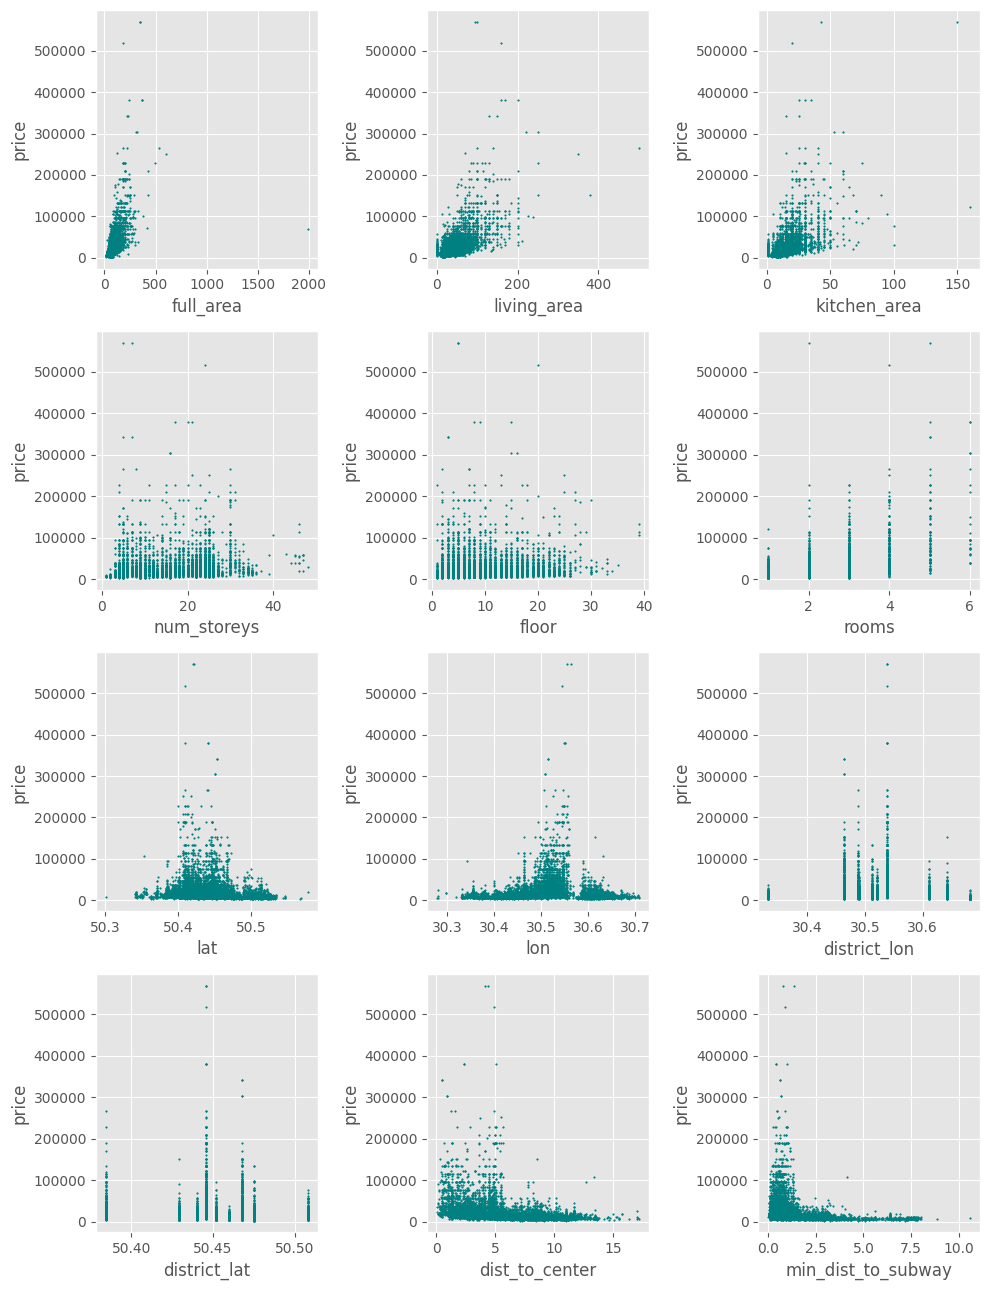

In [179]:
f, ax = plt.subplots(4, 3, figsize=(10, 13))
k = 0
for i in range(4):
    for j in range(3):
        if k < 12:
            ax[i][j].scatter(x=countinious_feats[k], y='price', data=data, s=1, color='teal')
            ax[i][j].set_xlabel(countinious_feats[k])
            ax[i][j].set_ylabel('price')
            k += 1

plt.tight_layout()
plt.show()

`floor`

In [192]:
data['floor'].value_counts().sort_index().reset_index()

,floor,count
0,1,322
1,2,565
2,3,650
3,4,661
4,5,597
5,6,433
6,7,423
7,8,392
8,9,395
9,10,324


In [233]:
data['floor_other'] = data['floor'].apply(lambda x: 30 if x > 26 else x)

In [212]:
data['floor_other'].value_counts().sort_index().reset_index()

,floor_other,count
0,1,322
1,2,565
2,3,650
3,4,661
4,5,597
5,6,433
6,7,423
7,8,392
8,9,395
9,10,324


In [234]:
feats_floor_other = feats_new + ['subway', 'floor_other']
feats_floor_other.remove('floor')
feats_floor_other

['rooms',
 'full_area',
 'living_area',
 'kitchen_area',
 'num_storeys',
 'typical_panel',
 'concrete_monolithic',
 'old_brick',
 'first_rental',
 'adjacent_separate',
 'ukrainian_brick',
 'eurorenovation',
 'satisfactory_condition',
 'multilevel',
 'needs_cosmetic_repairs',
 'kitchen_living_room',
 'penthouse',
 'old_panel',
 'good_condition',
 'pre_revolutionary',
 'needs_major_repairs',
 'gas_block',
 'repair_in_progress',
 'free_planning',
 'adjacent',
 'separate',
 'ukrainian_panel',
 'Stalinka',
 'excellent_condition',
 'studio',
 'designer_renovation',
 'safe',
 'shower_cabin',
 'wardrobe',
 'TV',
 'hair_dryer',
 'dishes',
 'satellite_TV',
 'DVD_player',
 'washing_machine',
 'fireplace',
 'dishwashers',
 'alarms',
 'bed',
 'counters',
 'air_conditioning',
 'refrigerator',
 'jacuzzi',
 'microwave',
 'iron',
 'cable_TV',
 'lat',
 'lon',
 'district_lat',
 'district_lon',
 'min_dist_to_subway',
 'dist_to_center',
 'district',
 'subway',
 'floor_other']

In [235]:
X, y = get_X_y(data, feats_floor_other)

transformer = ColumnTransformer(
    [('OneHot', OneHotEncoder(), ['district']),
     ('labelEnc', OrdinalEncoder(), ['subway'])],
    remainder='passthrough',
    verbose_feature_names_out=False
)

pipeline = Pipeline([
    ('transform', transformer),
    ('regr', model)
])

model = xgb.XGBRegressor(**parameters)

run_cv(pipeline, X, y, folds=5, target_log=False,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.3667, test_rmsle: 0.3838
[Fold 1] train_rmsle: 0.3623, test_rmsle: 0.3769
[Fold 2] train_rmsle: 0.3679, test_rmsle: 0.3635
[Fold 3] train_rmsle: 0.3648, test_rmsle: 0.3664
[Fold 4] train_rmsle: 0.3608, test_rmsle: 0.3817
RMSLE: 0.3745 ± 0.0081


Previous: 0.3716 ± 0.0080

In [236]:
run_cv(pipeline, X, y, folds=5, target_log=True,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.3043, test_rmsle: 0.3256
[Fold 1] train_rmsle: 0.3058, test_rmsle: 0.3191
[Fold 2] train_rmsle: 0.3100, test_rmsle: 0.3045
[Fold 3] train_rmsle: 0.3098, test_rmsle: 0.3098
[Fold 4] train_rmsle: 0.3088, test_rmsle: 0.3256
RMSLE: 0.3169 ± 0.0085


Previous result: 0.3177 ± 0.0088

For logarithm price `floor_other` give better result, but for simple price - worse.

`num_storeys`

In [204]:
data['num_storeys'].value_counts().sort_index().reset_index()

,num_storeys,count
0,1,9
1,2,26
2,3,41
3,4,154
4,5,806
5,6,133
6,7,118
7,8,75
8,9,1213
9,10,212


In [238]:
data['num_storeys_other'] = data['num_storeys'].apply(lambda x: 40 if x > 35 else x)
data['num_storeys_other'].value_counts().sort_index().reset_index()

,num_storeys_other,count
0,1,9
1,2,26
2,3,41
3,4,154
4,5,806
5,6,133
6,7,118
7,8,75
8,9,1213
9,10,212


In [239]:
feats_floor_numstoreys_other = feats_floor_other + ['num_storeys_other']
feats_floor_numstoreys_other.remove('num_storeys')

X, y = get_X_y(data, feats_floor_numstoreys_other)

transformer = ColumnTransformer(
    [('OneHot', OneHotEncoder(), ['district']),
     ('labelEnc', OrdinalEncoder(), ['subway'])],
    remainder='passthrough',
    verbose_feature_names_out=False
)

pipeline = Pipeline([
    ('transform', transformer),
    ('regr', model)
])

model = xgb.XGBRegressor(**parameters)

run_cv(pipeline, X, y, folds=5, target_log=False,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.3613, test_rmsle: 0.3808
[Fold 1] train_rmsle: 0.3598, test_rmsle: 0.3721
[Fold 2] train_rmsle: 0.3707, test_rmsle: 0.3641
[Fold 3] train_rmsle: 0.3588, test_rmsle: 0.3595
[Fold 4] train_rmsle: 0.3609, test_rmsle: 0.3826
RMSLE: 0.3718 ± 0.0090


Previous: 0.3716 ± 0.0080

In [240]:
run_cv(pipeline, X, y, folds=5, target_log=True,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.3064, test_rmsle: 0.3258
[Fold 1] train_rmsle: 0.3060, test_rmsle: 0.3193
[Fold 2] train_rmsle: 0.3108, test_rmsle: 0.3053
[Fold 3] train_rmsle: 0.3107, test_rmsle: 0.3105
[Fold 4] train_rmsle: 0.3077, test_rmsle: 0.3242
RMSLE: 0.3170 ± 0.0079


Previous result: 0.3177 ± 0.0088

For logarithm price `floor_other` and `num_storeys_other` give better result, but for simple price - worse.

In [241]:
data.to_csv('../data/real_estate_geo_location_fix_error_fe.csv', index=False)

`full_area`

In [46]:
data = pd.read_csv('../data/real_estate_geo_location_fix_error_fe.csv')

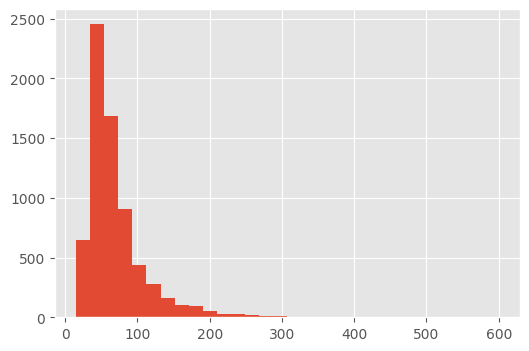

In [12]:
data['full_area'].hist(bins=30);

In [13]:
data[data['full_area'] > 300][['price', 'rooms', 'full_area']]

,price,rooms,full_area
233,570000,5,350.0
1319,266000,6,530.0
1320,152000,5,430.0
2169,380000,6,368.0
2170,72200,6,420.0
2277,250800,5,600.0
2889,114000,5,330.0
3573,570000,2,350.0
3677,380000,6,364.0
3754,95000,6,303.0


In [227]:
data.loc[3358, 'description']

'Актуально! New!\n\nАренда стильной 5-к квартиры в центре Киева\nПлощадь: 203м2\nЭтаж: 4/5 (есть лифт), (поднимается только вверх)\nАдрес: Антоновича (Горького) 18\nБлижайшая станция метро: Льва Толстого в 3 минутах ходьбы\n4 отдельные спальни(без мебели), большая кухня гостиная, 2 санузла\nИмпортная дорогая встроенная мебель\n\nЦена: 1800$ (на период военного положения).\nВозможна оплата: Наличными, безнал'

In [231]:
data.loc[3358, 'full_area'] = 203 # fix error

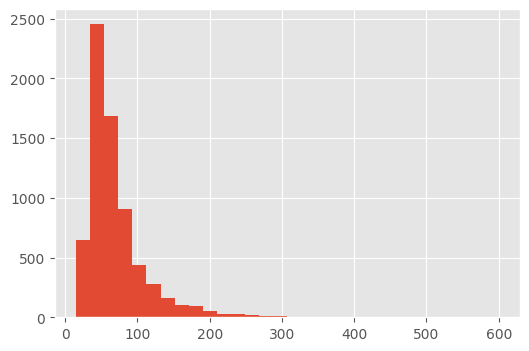

In [229]:
data['full_area'].hist(bins=30);

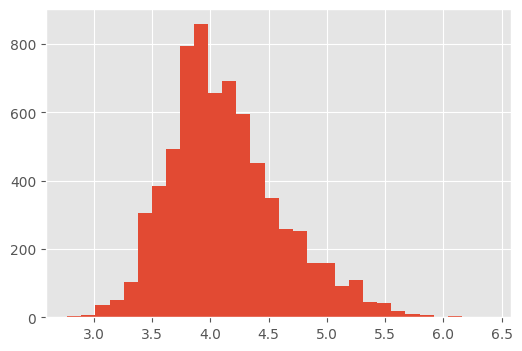

In [39]:
data['full_area_log'] = np.log1p(data['full_area'])
data['full_area_log'].hist(bins=30);

In [243]:
feats_full_area_log = feats_new + ['subway', 'full_area_log']
feats_full_area_log.remove('full_area')

X, y = get_X_y(data, feats_full_area_log)

transformer = ColumnTransformer(
    [('OneHot', OneHotEncoder(), ['district']),
     ('labelEnc', OrdinalEncoder(), ['subway'])],
    remainder='passthrough',
    verbose_feature_names_out=False
)

pipeline = Pipeline([
    ('transform', transformer),
    ('regr', model)
])

model = xgb.XGBRegressor(**parameters)

run_cv(pipeline, X, y, folds=5, target_log=False,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.3600, test_rmsle: 0.3789
[Fold 1] train_rmsle: 0.3642, test_rmsle: 0.3745
[Fold 2] train_rmsle: 0.3708, test_rmsle: 0.3660
[Fold 3] train_rmsle: 0.3601, test_rmsle: 0.3593
[Fold 4] train_rmsle: 0.3573, test_rmsle: 0.3796
RMSLE: 0.3717 ± 0.0079


Previous: 0.3716 ± 0.0080

In [244]:
run_cv(pipeline, X, y, folds=5, target_log=True,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.3038, test_rmsle: 0.3250
[Fold 1] train_rmsle: 0.3060, test_rmsle: 0.3201
[Fold 2] train_rmsle: 0.3118, test_rmsle: 0.3071
[Fold 3] train_rmsle: 0.3109, test_rmsle: 0.3102
[Fold 4] train_rmsle: 0.3077, test_rmsle: 0.3256
RMSLE: 0.3176 ± 0.0076


Previous result: 0.3177 ± 0.0088

In [245]:
feats_full_area_log = feats_new + ['subway', 'full_area_log']
feats_full_area_log.remove('full_area')

X, y = get_X_y(data, feats_full_area_log)

transformer = ColumnTransformer(
    [('OneHot', OneHotEncoder(), ['district']),
     ('labelEnc', OrdinalEncoder(), ['subway'])],
    remainder='passthrough',
    verbose_feature_names_out=False
)

pipeline = Pipeline([
    ('transform', transformer),
    ('regr', model)
])

model = xgb.XGBRegressor(**parameters)

run_cv(pipeline, X, y, folds=5, target_log=False,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.3650, test_rmsle: 0.3848
[Fold 1] train_rmsle: 0.3628, test_rmsle: 0.3740
[Fold 2] train_rmsle: 0.3698, test_rmsle: 0.3606
[Fold 3] train_rmsle: 0.3689, test_rmsle: 0.3697
[Fold 4] train_rmsle: 0.3597, test_rmsle: 0.3818
RMSLE: 0.3742 ± 0.0086


In [246]:
run_cv(pipeline, X, y, folds=5, target_log=True,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.3037, test_rmsle: 0.3231
[Fold 1] train_rmsle: 0.3061, test_rmsle: 0.3212
[Fold 2] train_rmsle: 0.3130, test_rmsle: 0.3057
[Fold 3] train_rmsle: 0.3089, test_rmsle: 0.3109
[Fold 4] train_rmsle: 0.3081, test_rmsle: 0.3273
RMSLE: 0.3176 ± 0.0081


In [247]:
feats_full_area_log = feats_floor_numstoreys_other + ['full_area_log']
feats_full_area_log.remove('full_area')

X, y = get_X_y(data, feats_full_area_log)

transformer = ColumnTransformer(
    [('OneHot', OneHotEncoder(), ['district']),
     ('labelEnc', OrdinalEncoder(), ['subway'])],
    remainder='passthrough',
    verbose_feature_names_out=False
)

pipeline = Pipeline([
    ('transform', transformer),
    ('regr', model)
])

model = xgb.XGBRegressor(**parameters)

run_cv(pipeline, X, y, folds=5, target_log=False,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.3568, test_rmsle: 0.3773
[Fold 1] train_rmsle: 0.3598, test_rmsle: 0.3739
[Fold 2] train_rmsle: 0.3695, test_rmsle: 0.3664
[Fold 3] train_rmsle: 0.3566, test_rmsle: 0.3569
[Fold 4] train_rmsle: 0.3576, test_rmsle: 0.3779
RMSLE: 0.3705 ± 0.0079


In [248]:
run_cv(pipeline, X, y, folds=5, target_log=True,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.3063, test_rmsle: 0.3239
[Fold 1] train_rmsle: 0.3086, test_rmsle: 0.3247
[Fold 2] train_rmsle: 0.3113, test_rmsle: 0.3042
[Fold 3] train_rmsle: 0.3093, test_rmsle: 0.3092
[Fold 4] train_rmsle: 0.3083, test_rmsle: 0.3265
RMSLE: 0.3177 ± 0.0092


For logarithm price `floor_other` and `num_storeys_other` give the same result, but for simple price - the best.

`living_area`

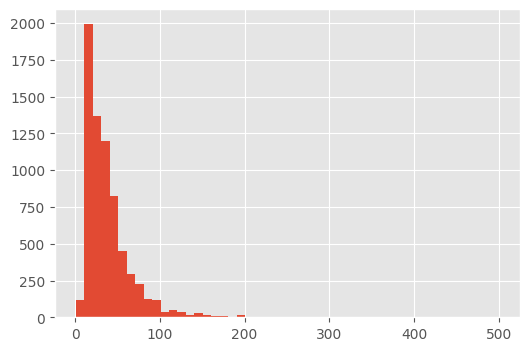

In [74]:
data['living_area'].hist(bins=50);

In [35]:
data[data['living_area'] > 200][['price', 'rooms', 'full_area', 'living_area']]

,price,rooms,full_area,living_area
1235,152000,5,290.0,250.0
1319,266000,6,530.0,500.0
1320,152000,5,430.0,380.0
2277,250800,5,600.0,350.0
4069,39800,6,270.0,210.0
4403,98800,4,279.0,239.0
4773,304000,6,320.0,250.0
5609,228000,6,490.0,250.0
6139,100000,5,380.0,225.0
6530,304000,6,310.0,220.0


In [75]:
data[data['living_area'] < 10][['price', 'rooms', 'full_area', 'living_area']]

,price,rooms,full_area,living_area
104,5800,1,15.0,9.0
367,15900,1,40.0,1.0
606,34200,2,67.0,1.0
654,20000,2,42.0,1.0
657,24700,2,50.0,1.0
...,...,...,...,...
6454,22800,2,50.0,1.0
6540,11900,1,26.0,6.0
6549,12000,1,24.0,5.0
6860,15000,1,31.0,9.0


In [129]:
data['living_area_fix'] = data['living_area'].apply(lambda x: None if x == 1 else x)

In [38]:
data[data['living_area_fix'] < 10][['price', 'rooms', 'full_area', 'living_area_fix']]

,price,rooms,full_area,living_area_fix
104,5800,1,15.0,9.0
841,20900,2,50.0,8.0
1075,10000,1,30.0,7.0
1715,7500,1,25.0,8.0
2338,6500,1,38.0,8.0
2362,8000,1,24.0,9.0
2719,8000,1,23.0,5.0
3504,13000,1,24.0,4.0
3663,26600,1,53.0,7.0
3788,8000,1,45.0,8.0


In [24]:
data['living_area_fix'].isna().sum()

82

Fill NaN values with median within group apatrments by 'rooms', 'full_area', 'district'.

In [132]:
data.groupby(['rooms', 'full_area', 'num_storeys_other'])['living_area_fix'].median().reset_index().sort_values('living_area_fix')

,rooms,full_area,num_storeys_other,living_area_fix
45,1,24.0,18,4.0
39,1,23.0,22,5.0
46,1,24.0,21,5.0
65,1,26.0,17,6.0
0,1,15.0,5,9.0
...,...,...,...,...
2093,3,135.0,24,NaN
2263,4,120.0,25,NaN
2304,4,137.0,19,NaN
2404,4,180.0,5,NaN


In [133]:
data['living_area_fix'] = (data['living_area_fix']
                           .fillna(data.groupby(['rooms', 'full_area', 'num_storeys_other'])['living_area_fix']
                           .transform('median')))

In [134]:
data[data['living_area_fix'] < 10][['price', 'rooms', 'full_area', 'living_area_fix']]

,price,rooms,full_area,living_area_fix
104,5800,1,15.0,9.0
841,20900,2,50.0,8.0
1075,10000,1,30.0,7.0
1715,7500,1,25.0,8.0
2338,6500,1,38.0,8.0
2362,8000,1,24.0,9.0
2719,8000,1,23.0,5.0
3504,13000,1,24.0,4.0
3663,26600,1,53.0,7.0
3788,8000,1,45.0,8.0


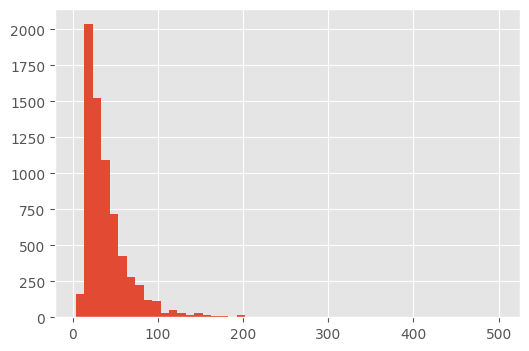

In [135]:
data['living_area_fix'].hist(bins=50);

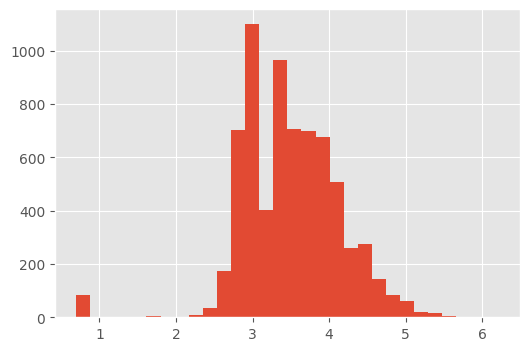

In [38]:
data['living_area_log'] = np.log1p(data['living_area'])
data['living_area_log'].hist(bins=30);

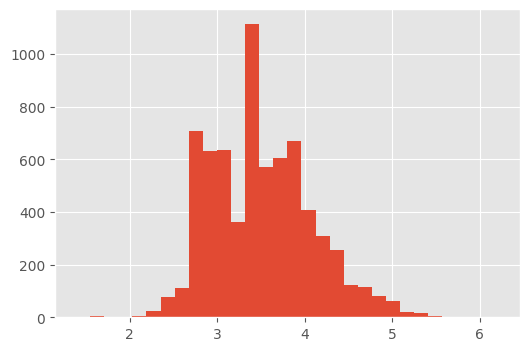

In [137]:
data['living_area_fix_log'] = np.log(data['living_area_fix'])
data['living_area_fix_log'].hist(bins=30);

In [140]:
data[data['living_area_fix_log'] < 2][['price', 'rooms', 'full_area', 'living_area_fix']]

,price,rooms,full_area,living_area_fix
1075,10000,1,30.0,7.0
2719,8000,1,23.0,5.0
3504,13000,1,24.0,4.0
3663,26600,1,53.0,7.0
6261,9000,1,20.0,5.0
6540,11900,1,26.0,6.0
6549,12000,1,24.0,5.0


In [143]:
black_list = ['id', 'price', 'class', 'residential', 'detail', 'description', 'subway_old']
num_feats = [col for col in data.columns if data[col].dtypes != 'object' and col not in black_list]

In [150]:
feats_full_area_log = num_feats + ['subway', 'district']
for_delete = ['floor', 'full_area', 'num_storeys', 'living_area_fix', 'living_area_fix_log', 'living_area_log']
feats_full_area_log = [x for x in feats_full_area_log if x not in for_delete]
len(feats_full_area_log)

60

In [152]:
feats_full_living_area_log = feats_full_area_log + ['living_area_log']
feats_full_living_area_log.remove('living_area')

X, y = get_X_y(data, feats_full_living_area_log)

parameters = {
    "objective": "reg:squarederror",
    "eval_metric": "rmsle",
    "eta": 0.1,
    "verbosity": 1,
    "seed": 24,
    "tree_method": "hist",
    "grow_policy": "lossguide",

    # regularization parameters
    "max_depth": 5,
    "max_leaves": 3,
    "subsample": 0.7,
    "colsample_bytree": 0.6,
}
model = xgb.XGBRegressor(**parameters)

transformer = ColumnTransformer(
    [('OneHot', OneHotEncoder(), ['district']),
     ('labelEnc', OrdinalEncoder(), ['subway'])],
    remainder='passthrough',
    verbose_feature_names_out=False
)

pipeline = Pipeline([
    ('transform', transformer),
    ('regr', model)
])

run_cv(pipeline, X, y, folds=5, target_log=False,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.3638, test_rmsle: 0.3818
[Fold 1] train_rmsle: 0.3619, test_rmsle: 0.3748
[Fold 2] train_rmsle: 0.3703, test_rmsle: 0.3697
[Fold 3] train_rmsle: 0.3626, test_rmsle: 0.3609
[Fold 4] train_rmsle: 0.3604, test_rmsle: 0.3827
RMSLE: 0.3740 ± 0.0081


Previous: 0.3716 ± 0.0080

In [153]:
run_cv(pipeline, X, y, folds=5, target_log=True,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.3054, test_rmsle: 0.3269
[Fold 1] train_rmsle: 0.3091, test_rmsle: 0.3241
[Fold 2] train_rmsle: 0.3102, test_rmsle: 0.3040
[Fold 3] train_rmsle: 0.3064, test_rmsle: 0.3069
[Fold 4] train_rmsle: 0.3070, test_rmsle: 0.3238
RMSLE: 0.3172 ± 0.0096


Previous result: 0.3177 ± 0.0088

For logarithm price `living_area_log` give better result, but for simple price worst.

In [155]:
feats_full_living_area_fix_log = feats_full_area_log + ['living_area_fix_log']

X, y = get_X_y(data, feats_full_living_area_fix_log)

model = xgb.XGBRegressor(**parameters)

transformer = ColumnTransformer(
    [('OneHot', OneHotEncoder(), ['district']),
     ('labelEnc', OrdinalEncoder(), ['subway'])],
    remainder='passthrough',
    verbose_feature_names_out=False
)

pipeline = Pipeline([
    ('transform', transformer),
    ('regr', model)
])

run_cv(pipeline, X, y, folds=5, target_log=False,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.3623, test_rmsle: 0.3798
[Fold 1] train_rmsle: 0.3599, test_rmsle: 0.3713
[Fold 2] train_rmsle: 0.3700, test_rmsle: 0.3651
[Fold 3] train_rmsle: 0.3673, test_rmsle: 0.3658
[Fold 4] train_rmsle: 0.3647, test_rmsle: 0.3857
RMSLE: 0.3736 ± 0.0080


In [156]:
run_cv(pipeline, X, y, folds=5, target_log=True,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.3063, test_rmsle: 0.3284
[Fold 1] train_rmsle: 0.3067, test_rmsle: 0.3215
[Fold 2] train_rmsle: 0.3110, test_rmsle: 0.3054
[Fold 3] train_rmsle: 0.3111, test_rmsle: 0.3130
[Fold 4] train_rmsle: 0.3073, test_rmsle: 0.3241
RMSLE: 0.3185 ± 0.0082


logarithm of living_area and living_area_fix give worst result

In [157]:
feats_full_log_living_area_fix = feats_full_area_log + ['living_area_fix']

X, y = get_X_y(data, feats_full_log_living_area_fix)

model = xgb.XGBRegressor(**parameters)

transformer = ColumnTransformer(
    [('OneHot', OneHotEncoder(), ['district']),
     ('labelEnc', OrdinalEncoder(), ['subway'])],
    remainder='passthrough',
    verbose_feature_names_out=False
)

pipeline = Pipeline([
    ('transform', transformer),
    ('regr', model)
])

run_cv(pipeline, X, y, folds=5, target_log=False,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.3623, test_rmsle: 0.3798
[Fold 1] train_rmsle: 0.3599, test_rmsle: 0.3713
[Fold 2] train_rmsle: 0.3700, test_rmsle: 0.3651
[Fold 3] train_rmsle: 0.3673, test_rmsle: 0.3658
[Fold 4] train_rmsle: 0.3647, test_rmsle: 0.3857
RMSLE: 0.3736 ± 0.0080


In [158]:
run_cv(pipeline, X, y, folds=5, target_log=True,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.3063, test_rmsle: 0.3284
[Fold 1] train_rmsle: 0.3067, test_rmsle: 0.3215
[Fold 2] train_rmsle: 0.3110, test_rmsle: 0.3054
[Fold 3] train_rmsle: 0.3111, test_rmsle: 0.3130
[Fold 4] train_rmsle: 0.3073, test_rmsle: 0.3241
RMSLE: 0.3185 ± 0.0082


Worst result with `living_area_fix`

In [170]:
del data['living_area_fix']
del data['living_area_fix_log']

In [160]:
data.to_csv('../data/real_estate_geo_location_fix_error_fe_log.csv', index=False)

In [2]:
data = pd.read_csv('../data/real_estate_geo_location_fix_error_fe_log.csv')

`kitchen_area`

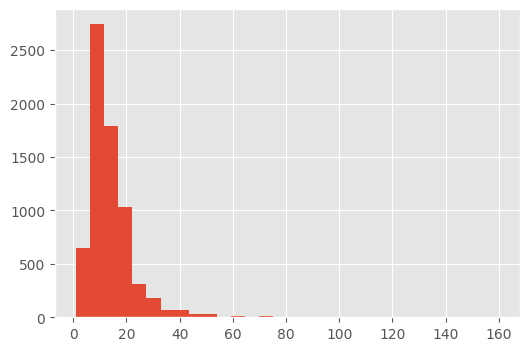

In [161]:
data['kitchen_area'].hist(bins=30);

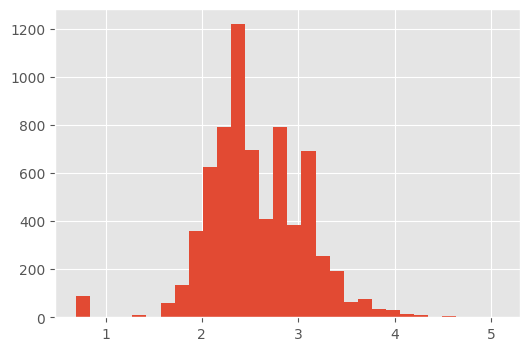

In [37]:
data['kitchen_area_log'] = np.log1p(data['kitchen_area'])
data['kitchen_area_log'].hist(bins=30);

In [167]:
feats_full_living_area_log = feats_full_area_log + ['kitchen_area_log']
feats_full_living_area_log.remove('kitchen_area')

X, y = get_X_y(data, feats_full_living_area_log)

transformer = ColumnTransformer(
    [('OneHot', OneHotEncoder(), ['district']),
     ('labelEnc', OrdinalEncoder(), ['subway'])],
    remainder='passthrough',
    verbose_feature_names_out=False
)

pipeline = Pipeline([
    ('transform', transformer),
    ('regr', model)
])

model = xgb.XGBRegressor(**parameters)

run_cv(pipeline, X, y, folds=5, target_log=False,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.3578, test_rmsle: 0.3789
[Fold 1] train_rmsle: 0.3605, test_rmsle: 0.3762
[Fold 2] train_rmsle: 0.3716, test_rmsle: 0.3678
[Fold 3] train_rmsle: 0.3642, test_rmsle: 0.3635
[Fold 4] train_rmsle: 0.3601, test_rmsle: 0.3797
RMSLE: 0.3732 ± 0.0064


Previous: 0.3716 ± 0.0080

In [168]:
run_cv(pipeline, X, y, folds=5, target_log=True,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.3049, test_rmsle: 0.3258
[Fold 1] train_rmsle: 0.3067, test_rmsle: 0.3212
[Fold 2] train_rmsle: 0.3116, test_rmsle: 0.3062
[Fold 3] train_rmsle: 0.3107, test_rmsle: 0.3096
[Fold 4] train_rmsle: 0.3077, test_rmsle: 0.3245
RMSLE: 0.3174 ± 0.0080


Previous result: 0.3177 ± 0.0088

Worse results.

In [171]:
data.to_csv('../data/real_estate_geo_location_fix_error_fe_log.csv', index=False)

### First floor, last and one before last floor

In [181]:
print('First floor:', data[data['floor'] == 1].shape[0])
print('Last floor:', data[data['floor'] == data['num_storeys']].shape[0])
print('One before last floor:', data[data['floor'] == (data['num_storeys'] - 1) ].shape[0])

First floor: 322
Last floor: 606
One before last floor: 668


In [184]:
data['apartament_last_floor'] = data['floor'] == data['num_storeys']
data['apartament_one_before_last_floor'] = data['floor'] == (data['num_storeys'] - 1)
data['apartament_first_floor'] = data['floor'] == 1

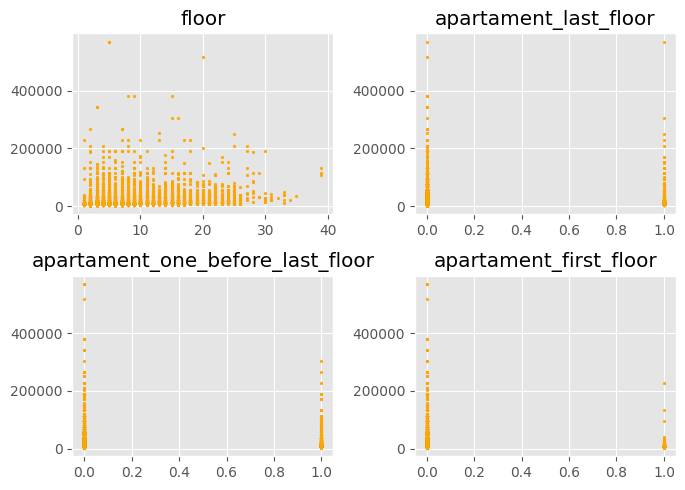

In [191]:
plt.figure(figsize=(7, 5))
keys = ['floor', 'apartament_last_floor', 'apartament_one_before_last_floor', 'apartament_first_floor']
for i, key in enumerate(keys):
    plt.subplot(2, 2, i+1)
    plt.scatter(data[key], data["price"], s=3, color='orange')
    plt.title(key)
plt.tight_layout()
plt.show()

In [192]:
black_list = ['id', 'price', 'class', 'residential', 'detail', 'description', 'subway_old']
num_feats = [col for col in data.columns if data[col].dtypes != 'object' and col not in black_list]

In [196]:
del_for_log_feats = ['full_area', 'living_area', 'kitchen_area',  'floor', 'num_storeys']
feats = [x for x in num_feats if x not in del_for_log_feats]

In [197]:
X, y = get_X_y(data, feats + ['subway', 'district'])

transformer = ColumnTransformer(
    [('OneHot', OneHotEncoder(), ['district']),
     ('labelEnc', OrdinalEncoder(), ['subway'])],
    remainder='passthrough',
    verbose_feature_names_out=False
)

pipeline = Pipeline([
    ('transform', transformer),
    ('regr', model)
])

model = xgb.XGBRegressor(**parameters)

run_cv(pipeline, X, y, folds=5, target_log=False,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.3625, test_rmsle: 0.3803
[Fold 1] train_rmsle: 0.3619, test_rmsle: 0.3732
[Fold 2] train_rmsle: 0.3645, test_rmsle: 0.3546
[Fold 3] train_rmsle: 0.3640, test_rmsle: 0.3656
[Fold 4] train_rmsle: 0.3556, test_rmsle: 0.3770
RMSLE: 0.3701 ± 0.0092


Best result without log price

In [198]:
run_cv(pipeline, X, y, folds=5, target_log=True,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.3066, test_rmsle: 0.3266
[Fold 1] train_rmsle: 0.3091, test_rmsle: 0.3253
[Fold 2] train_rmsle: 0.3146, test_rmsle: 0.3089
[Fold 3] train_rmsle: 0.3126, test_rmsle: 0.3093
[Fold 4] train_rmsle: 0.3087, test_rmsle: 0.3273
RMSLE: 0.3195 ± 0.0085


In [202]:
del_for_log_feats = ['full_area', 'living_area', 'kitchen_area',  'floor_other', 'num_storeys_other']
feats = [x for x in num_feats if x not in del_for_log_feats]

X, y = get_X_y(data, feats + ['subway', 'district'])

transformer = ColumnTransformer(
    [('OneHot', OneHotEncoder(), ['district']),
     ('labelEnc', OrdinalEncoder(), ['subway'])],
    remainder='passthrough',
    verbose_feature_names_out=False
)

pipeline = Pipeline([
    ('transform', transformer),
    ('regr', model)
])

model = xgb.XGBRegressor(**parameters)

run_cv(pipeline, X, y, folds=5, target_log=False,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.3637, test_rmsle: 0.3802
[Fold 1] train_rmsle: 0.3606, test_rmsle: 0.3764
[Fold 2] train_rmsle: 0.3672, test_rmsle: 0.3621
[Fold 3] train_rmsle: 0.3630, test_rmsle: 0.3615
[Fold 4] train_rmsle: 0.3603, test_rmsle: 0.3847
RMSLE: 0.3730 ± 0.0095


In [203]:
run_cv(pipeline, X, y, folds=5, target_log=True,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.3068, test_rmsle: 0.3284
[Fold 1] train_rmsle: 0.3067, test_rmsle: 0.3216
[Fold 2] train_rmsle: 0.3098, test_rmsle: 0.3050
[Fold 3] train_rmsle: 0.3094, test_rmsle: 0.3109
[Fold 4] train_rmsle: 0.3084, test_rmsle: 0.3265
RMSLE: 0.3185 ± 0.0091


In [199]:
del_without_log_feats = ['full_area_log', 'living_area_log', 'kitchen_area_log', 'floor', 'num_storeys']
feats = [x for x in num_feats if x not in del_without_log_feats]

In [200]:
X, y = get_X_y(data, feats + ['subway', 'district'])

transformer = ColumnTransformer(
    [('OneHot', OneHotEncoder(), ['district']),
     ('labelEnc', OrdinalEncoder(), ['subway'])],
    remainder='passthrough',
    verbose_feature_names_out=False
)

pipeline = Pipeline([
    ('transform', transformer),
    ('regr', model)
])

model = xgb.XGBRegressor(**parameters)

run_cv(pipeline, X, y, folds=5, target_log=False,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.3607, test_rmsle: 0.3766
[Fold 1] train_rmsle: 0.3545, test_rmsle: 0.3705
[Fold 2] train_rmsle: 0.3662, test_rmsle: 0.3625
[Fold 3] train_rmsle: 0.3654, test_rmsle: 0.3649
[Fold 4] train_rmsle: 0.3590, test_rmsle: 0.3821
RMSLE: 0.3713 ± 0.0073


In [201]:
run_cv(pipeline, X, y, folds=5, target_log=True,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.3055, test_rmsle: 0.3246
[Fold 1] train_rmsle: 0.3073, test_rmsle: 0.3234
[Fold 2] train_rmsle: 0.3126, test_rmsle: 0.3045
[Fold 3] train_rmsle: 0.3095, test_rmsle: 0.3077
[Fold 4] train_rmsle: 0.3049, test_rmsle: 0.3209
RMSLE: 0.3162 ± 0.0084


Best result for log price

In [204]:
del_without_log_feats = ['full_area_log', 'living_area_log', 'kitchen_area_log', 'floor_other', 'num_storeys_other']
feats = [x for x in num_feats if x not in del_without_log_feats]

X, y = get_X_y(data, feats + ['subway', 'district'])

transformer = ColumnTransformer(
    [('OneHot', OneHotEncoder(), ['district']),
     ('labelEnc', OrdinalEncoder(), ['subway'])],
    remainder='passthrough',
    verbose_feature_names_out=False
)

pipeline = Pipeline([
    ('transform', transformer),
    ('regr', model)
])

model = xgb.XGBRegressor(**parameters)

run_cv(pipeline, X, y, folds=5, target_log=False,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.3629, test_rmsle: 0.3805
[Fold 1] train_rmsle: 0.3601, test_rmsle: 0.3745
[Fold 2] train_rmsle: 0.3713, test_rmsle: 0.3680
[Fold 3] train_rmsle: 0.3626, test_rmsle: 0.3607
[Fold 4] train_rmsle: 0.3568, test_rmsle: 0.3793
RMSLE: 0.3726 ± 0.0074


In [205]:
run_cv(pipeline, X, y, folds=5, target_log=True,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.3058, test_rmsle: 0.3274
[Fold 1] train_rmsle: 0.3070, test_rmsle: 0.3220
[Fold 2] train_rmsle: 0.3123, test_rmsle: 0.3050
[Fold 3] train_rmsle: 0.3115, test_rmsle: 0.3104
[Fold 4] train_rmsle: 0.3087, test_rmsle: 0.3247
RMSLE: 0.3179 ± 0.0087


### Target Encoding

In [206]:
data_target_enc = data.copy()

In [215]:
class TargetFeatureEncoding:
    def __init__(self, C=10):
        self.C = C
        self.cpu_k = 3
        self.global_mean = 0
        self.features = 'all'
        self.cat_columns = []
        self.y = 0
        self.values = dict()

    def fit(self, data, y, features='all'):

        self.y = y
        
        if features == 'all':
            self.cat_columns = sorted([i for i in data.columns if data[i].dtype == 'O'])
            self.features = self.cat_columns
        else:
            self.features = features

        self.global_mean = np.mean(y)

        f = {'y': ['size', 'mean']}

        for col in self.features:
            self.values[col] = dict()
            temp = pd.DataFrame({'y': y, col: data[col]}).groupby([col]).agg(f)

            self.values[col] = (
                (temp['y']['mean'] * temp['y']['size'] + self.global_mean * self.C) / 
                (temp['y']['size'] + self.C)
            ).to_dict()
            
        return self.values

    def fit_transform(self, data, y, features='all', inplace=True):

        self.fit(data, y, features)
        return self.transform(data, inplace=inplace)

    def transform(self, data, inplace=True):
        import warnings

        if inplace:
            for col in self.values:
                if col in data.columns:
                    temp = pd.DataFrame.from_dict(
                        self.values[col], orient='index').reset_index()
                    temp.columns = [col, 'value']
                    data = pd.merge(data, temp, how='left').fillna(self.global_mean)
                    data[col] = data['value']
                    del data['value']
                    data[col] = data[col].astype('float32')

                else:
                    warnings.warn('Column ' + col + ' is missed in this dataset.')
        else:
            new_data = data.copy()
            for col in self.values:
                if col in new_data.columns:
                    temp = pd.DataFrame.from_dict(
                        self.values[col], orient='index').reset_index()
                    temp.columns = [col, 'value']
                    new_data = pd.merge(
                        new_data, temp, how='left').fillna(self.global_mean)
                    new_data[col] = new_data['value']
                    del new_data['value']
                    new_data[col] = new_data[col].astype('float32')

                else:
                    warnings.warn('Column ' + col + ' is missed in this dataset.')
            return new_data
        

def create_new_df_with_categorical_encodings(new_train, new_train_y, new_val, cols):
    se = TargetFeatureEncoding()
    new_skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    val_dfs = []
    # 2)
    for new_train_split, new_val_split in new_skf.split(new_train, new_train_y):
        # 3)
        se.fit(
            new_train.iloc[new_train_split], 
            new_train_y.iloc[new_train_split], 
            features=cols
        )
        val_dfs.append(
            se.transform(new_train.iloc[new_val_split], inplace=False)
        )
    # 4)
    se.fit(new_train, new_train_y, features=cols)
    main_val = se.transform(new_val, inplace=False)
    return val_dfs, main_val

In [211]:
features = ['district', 'subway']

In [232]:
%%time

new_train_dfs = []
new_val_dfs = []
main_train_dfs = []

for train_split, val_split in skf.split(X, X['rooms']): 
    # 5)
    temp_train_dfs, temp_val_df = create_new_df_with_categorical_encodings(
        data_target_enc.iloc[train_split], 
        y.iloc[train_split], 
        data_target_enc.iloc[val_split], 
        features
    )
    # 6)
    new_train_dfs.append(temp_train_dfs)
    new_val_dfs.append(temp_val_df)
    # 7)
    se = TargetFeatureEncoding()
    se.fit(data_target_enc.iloc[train_split], y.iloc[train_split], features)
    main_train_dfs.append(
        se.transform(data_target_enc.iloc[val_split], inplace=False)
    )
    
se.fit_transform(X, y, features=features)
#main_test = se.transform(X_test, inplace=False)

d:\Мои Документы\Nata\DS\ml_course_work\env\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
d:\Мои Документы\Nata\DS\ml_course_work\env\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
d:\Мои Документы\Nata\DS\ml_course_work\env\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
d:\Мои Документы\Nata\DS\ml_course_work\env\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


CPU times: total: 1 s
Wall time: 1.3 s


d:\Мои Документы\Nata\DS\ml_course_work\env\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


In [233]:
data_te = pd.concat([i for i in main_train_dfs], axis=0, ignore_index=True)

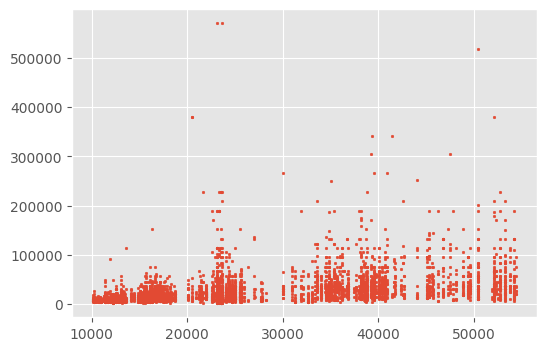

In [235]:
plt.scatter(data_te['subway'], data_te['price'], s=3);

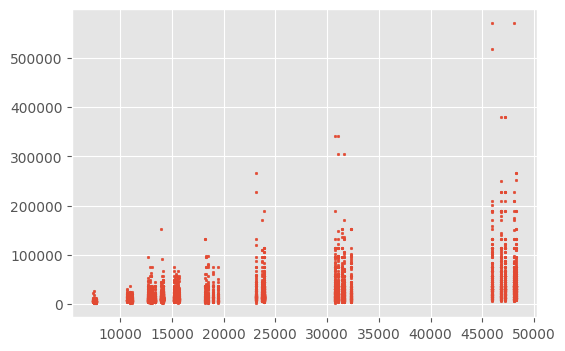

In [236]:
plt.scatter(data_te['district'], data_te['price'], s=3);

In [245]:
data_te['subway'].astype('float')
data_te['district'].astype('float')

0       10921.110352
1       15345.629883
2       47210.707031
3       32334.634766
4       15345.629883
            ...     
6932    14147.239258
6933    18495.017578
6934    46790.964844
6935    10931.741211
6936    10931.741211
Name: district, Length: 6937, dtype: float64

In [246]:
black_list = ['id', 'price', 'price_log', 'class', 'residential', 'detail', 'description', 'subway_old']
num_feats = [col for col in data_te.columns if data_te[col].dtypes != 'object' and col not in black_list]

X, y = get_X_y(data_te, num_feats)

model = xgb.XGBRegressor(**parameters)

run_cv(model, X, y, folds=5, target_log=False,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.3667, test_rmsle: 0.3540
[Fold 1] train_rmsle: 0.3574, test_rmsle: 0.3740
[Fold 2] train_rmsle: 0.3555, test_rmsle: 0.3703
[Fold 3] train_rmsle: 0.3606, test_rmsle: 0.3685
[Fold 4] train_rmsle: 0.3552, test_rmsle: 0.3775
RMSLE: 0.3689 ± 0.0081


In [248]:
run_cv(model, X, y, folds=5, target_log=True,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.3093, test_rmsle: 0.2931
[Fold 1] train_rmsle: 0.3012, test_rmsle: 0.3186
[Fold 2] train_rmsle: 0.3028, test_rmsle: 0.3297
[Fold 3] train_rmsle: 0.3053, test_rmsle: 0.3019
[Fold 4] train_rmsle: 0.3023, test_rmsle: 0.3237
RMSLE: 0.3134 ± 0.0137


**The best result!**

In [298]:
data_te.to_csv('../data/real_estate_target_enc.csv', index=False)

### Feature Interactions with xgbfir

In [300]:

black_list = ['id', 'price', 'price_log', 'class', 'residential', 'detail', 'description', 'subway_old']
num_feats = [col for col in data_te.columns if data_te[col].dtypes != 'object' and col not in black_list]

X, y = get_X_y(data_te, num_feats)

xgb_train = xgb.DMatrix(X, y)

num_rounds = 1_000
results = xgb.cv(parameters, xgb_train, num_rounds,
                 folds=skf, early_stopping_rounds=10, verbose_eval=50)


[0]	train-rmsle:2.19485+0.01107	test-rmsle:2.19481+0.01856


d:\Мои Документы\Nata\DS\ml_course_work\env\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[50]	train-rmsle:0.38773+0.00533	test-rmsle:0.39496+0.00426
[100]	train-rmsle:0.35679+0.00508	test-rmsle:0.36676+0.00511
[150]	train-rmsle:0.34738+0.00516	test-rmsle:0.35971+0.00532
[200]	train-rmsle:0.34090+0.00383	test-rmsle:0.35501+0.00623
[250]	train-rmsle:0.33543+0.00422	test-rmsle:0.35192+0.00611
[300]	train-rmsle:0.32912+0.00413	test-rmsle:0.34678+0.00684
[350]	train-rmsle:0.32443+0.00372	test-rmsle:0.34298+0.00628
[400]	train-rmsle:0.32034+0.00312	test-rmsle:0.34053+0.00690
[414]	train-rmsle:0.31970+0.00337	test-rmsle:0.34081+0.00705


In [301]:
model = xgb.train(parameters, xgb_train, num_boost_round=415)
xgbfir.saveXgbFI(
    model,
    feature_names=num_feats, 
    OutputXlsxFile=pjoin("../data", "xgbfir_importance.xlsx")
)

In [390]:
data_te_fir = data_te.copy()

In [303]:
data_te_fir['full_area|subway'] = data_te_fir['subway'] * data_te_fir['full_area']

black_list = ['id', 'price', 'price_log', 'class', 'residential', 'detail', 'description', 'subway_old']
num_feats = [col for col in data_te_fir.columns if data_te_fir[col].dtypes != 'object' and col not in black_list]

X, y = get_X_y(data_te_fir, num_feats)

model = xgb.XGBRegressor(**parameters)

run_cv(model, X, y, folds=5, target_log=False,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.3648, test_rmsle: 0.3571
[Fold 1] train_rmsle: 0.3555, test_rmsle: 0.3781
[Fold 2] train_rmsle: 0.3520, test_rmsle: 0.3657
[Fold 3] train_rmsle: 0.3604, test_rmsle: 0.3696
[Fold 4] train_rmsle: 0.3520, test_rmsle: 0.3682
RMSLE: 0.3677 ± 0.0067


In [304]:
run_cv(model, X, y, folds=5, target_log=True,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.3092, test_rmsle: 0.2965
[Fold 1] train_rmsle: 0.3026, test_rmsle: 0.3200
[Fold 2] train_rmsle: 0.3030, test_rmsle: 0.3260
[Fold 3] train_rmsle: 0.3088, test_rmsle: 0.3053
[Fold 4] train_rmsle: 0.3041, test_rmsle: 0.3212
RMSLE: 0.3138 ± 0.0111


In [306]:
data_te_fir['full_area|subway'] = data_te_fir['subway'] * data_te_fir['full_area']
data_te_fir['full_area_log|kitchen_area_log'] = data_te_fir['kitchen_area_log'] / data_te_fir['full_area_log']

black_list = ['id', 'price', 'price_log', 'class', 'residential', 'detail', 'description', 'subway_old']
num_feats = [col for col in data_te_fir.columns if data_te_fir[col].dtypes != 'object' and col not in black_list]

X, y = get_X_y(data_te_fir, num_feats)

model = xgb.XGBRegressor(**parameters)

run_cv(model, X, y, folds=5, target_log=False,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.3593, test_rmsle: 0.3503
[Fold 1] train_rmsle: 0.3556, test_rmsle: 0.3803
[Fold 2] train_rmsle: 0.3491, test_rmsle: 0.3643
[Fold 3] train_rmsle: 0.3556, test_rmsle: 0.3665
[Fold 4] train_rmsle: 0.3531, test_rmsle: 0.3692
RMSLE: 0.3661 ± 0.0096


In [307]:
run_cv(model, X, y, folds=5, target_log=True,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.3098, test_rmsle: 0.2949
[Fold 1] train_rmsle: 0.3032, test_rmsle: 0.3216
[Fold 2] train_rmsle: 0.3035, test_rmsle: 0.3287
[Fold 3] train_rmsle: 0.3070, test_rmsle: 0.3064
[Fold 4] train_rmsle: 0.3046, test_rmsle: 0.3236
RMSLE: 0.3151 ± 0.0125


In [312]:
data_te_fir['full_area|subway'] = data_te_fir['subway'] * data_te_fir['full_area']
data_te_fir['full_area_log|kitchen_area_log'] = data_te_fir['kitchen_area_log'] / data_te_fir['full_area_log']
data_te_fir['full_area|kitchen_area'] = data_te_fir['kitchen_area'] + data_te_fir['full_area']

black_list = ['id', 'price', 'price_log', 'class', 'residential', 'detail', 'description', 'subway_old']
num_feats = [col for col in data_te_fir.columns if data_te_fir[col].dtypes != 'object' and col not in black_list]

X, y = get_X_y(data_te_fir, num_feats)

model = xgb.XGBRegressor(**parameters)

run_cv(model, X, y, folds=5, target_log=False,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.3613, test_rmsle: 0.3503
[Fold 1] train_rmsle: 0.3560, test_rmsle: 0.3794
[Fold 2] train_rmsle: 0.3544, test_rmsle: 0.3701
[Fold 3] train_rmsle: 0.3543, test_rmsle: 0.3600
[Fold 4] train_rmsle: 0.3558, test_rmsle: 0.3671
RMSLE: 0.3654 ± 0.0098


In [313]:
run_cv(model, X, y, folds=5, target_log=True,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.3116, test_rmsle: 0.2959
[Fold 1] train_rmsle: 0.3045, test_rmsle: 0.3223
[Fold 2] train_rmsle: 0.3046, test_rmsle: 0.3282
[Fold 3] train_rmsle: 0.3063, test_rmsle: 0.3070
[Fold 4] train_rmsle: 0.3057, test_rmsle: 0.3248
RMSLE: 0.3156 ± 0.0123


In [359]:
data_te_fir = data_te.copy()

In [391]:
data_te_fir['full_area|subway'] = data_te_fir['subway'] * data_te_fir['full_area']
data_te_fir['full_area_log|kitchen_area_log'] = data_te_fir['kitchen_area_log'] / data_te_fir['full_area_log']
data_te_fir['dist_to_center|full_area'] = data_te_fir['dist_to_center'] * data_te_fir['full_area']
data_te_fir['dist_to_center|kitchen_area'] = data_te_fir['dist_to_center'] * data_te_fir['kitchen_area']

black_list = ['id', 'price', 'price_log', 'class', 'residential', 'detail', 'description', 'subway_old']
num_feats = [col for col in data_te_fir.columns if data_te_fir[col].dtypes != 'object' and col not in black_list]

X, y = get_X_y(data_te_fir, num_feats)

model = xgb.XGBRegressor(**parameters)

run_cv(model, X, y, folds=5, target_log=False,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.3599, test_rmsle: 0.3487
[Fold 1] train_rmsle: 0.3565, test_rmsle: 0.3772
[Fold 2] train_rmsle: 0.3469, test_rmsle: 0.3624
[Fold 3] train_rmsle: 0.3553, test_rmsle: 0.3662
[Fold 4] train_rmsle: 0.3535, test_rmsle: 0.3670
RMSLE: 0.3643 ± 0.0092


**The best result**

In [361]:
run_cv(model, X, y, folds=5, target_log=True,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.3102, test_rmsle: 0.2958
[Fold 1] train_rmsle: 0.3052, test_rmsle: 0.3227
[Fold 2] train_rmsle: 0.3029, test_rmsle: 0.3261
[Fold 3] train_rmsle: 0.3078, test_rmsle: 0.3095
[Fold 4] train_rmsle: 0.3051, test_rmsle: 0.3234
RMSLE: 0.3155 ± 0.0114


In [392]:
data_te_fir.to_csv('../data/real_estate_target_enc_fir.csv', index=False)

### LightGBM

In [399]:
black_list = ['id', 'price', 'price_log', 'class', 'residential', 'detail', 'description', 'subway_old']
feats = [col for col in data_te_fir.columns if col not in black_list]
num_feats = [col for col in data_te_fir.columns if data_te_fir[col].dtypes != 'object' and col not in black_list]

X, y = get_X_y(data_te_fir, num_feats)

parameters = {
    "num_leaves": 3,
    "max_depth": 5,
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "subsample": 0.7,
    "subsample_freq": 1,
    "colsample_bytree": 0.6,
    "random_state": 24,
    "force_col_wise": True
}

model = lgb.LGBMRegressor(**parameters)

run_cv(model, X, y, folds=5, target_log=False,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.3331, test_rmsle: 0.3233
[Fold 1] train_rmsle: 0.2984, test_rmsle: 0.4410
[Fold 2] train_rmsle: 0.2977, test_rmsle: 0.3299
[Fold 3] train_rmsle: 0.3340, test_rmsle: 0.3231
[Fold 4] train_rmsle: 0.3255, test_rmsle: 0.3305
RMSLE: 0.3495 ± 0.0458


In [400]:
run_cv(model, X, y, folds=5, target_log=True,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.2481, test_rmsle: 0.2693
[Fold 1] train_rmsle: 0.2410, test_rmsle: 0.2980
[Fold 2] train_rmsle: 0.2437, test_rmsle: 0.2876
[Fold 3] train_rmsle: 0.2452, test_rmsle: 0.2749
[Fold 4] train_rmsle: 0.2441, test_rmsle: 0.2885
RMSLE: 0.2837 ± 0.0103


In [401]:
data_te = pd.read_csv('../data/real_estate_target_enc.csv')

In [402]:
black_list = ['id', 'price']
feats = [col for col in data_te.columns if col not in black_list]
num_feats = [col for col in data_te.columns if data_te[col].dtypes != 'object' and col not in black_list]

X, y = get_X_y(data_te, num_feats)

parameters = {
    "num_leaves": 3,
    "max_depth": 5,
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "subsample": 0.7,
    "subsample_freq": 1,
    "colsample_bytree": 0.6,
    "random_state": 24,
    "force_col_wise": True
}

model = lgb.LGBMRegressor(**parameters)

run_cv(model, X, y, folds=5, target_log=False,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.3119, test_rmsle: 0.3299
[Fold 1] train_rmsle: 0.3063, test_rmsle: 0.4362
[Fold 2] train_rmsle: 0.3340, test_rmsle: 0.3510
[Fold 3] train_rmsle: 0.3146, test_rmsle: 0.3326
[Fold 4] train_rmsle: 0.3085, test_rmsle: 0.3337
RMSLE: 0.3567 ± 0.0405


In [403]:
run_cv(model, X, y, folds=5, target_log=True,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.2504, test_rmsle: 0.2660
[Fold 1] train_rmsle: 0.2429, test_rmsle: 0.2985
[Fold 2] train_rmsle: 0.2466, test_rmsle: 0.2870
[Fold 3] train_rmsle: 0.2478, test_rmsle: 0.2743
[Fold 4] train_rmsle: 0.2471, test_rmsle: 0.2899
RMSLE: 0.2831 ± 0.0115


In [406]:
lgb_model = model.fit(X, np.log1p(y))

In [408]:
show_weights(lgb_model, top=100)

Weight,Feature
0.1808,full_area_log
0.1587,kitchen_area
0.1400,full_area
0.1109,dist_to_center
0.0777,kitchen_area_log
0.0758,designer_renovation
0.0719,subway
0.0470,district
0.0236,min_dist_to_subway
0.0210,good_condition


In [409]:
feats_to_drop = [
    'DVD_player', 'gas_block','apartament_one_before_last_floor',
    'wardrobe', 'TV', 'Stalinka', 'free_planning', 'needs_cosmetic_repairs',
    'repair_in_progress', 'penthouse', 'old_panel', 'needs_major_repairs'
    ]

In [410]:
black_list = ['id', 'price']
feats = [col for col in data_te.columns if col not in black_list]
num_feats = [col for col in data_te.columns if data_te[col].dtypes != 'object' and col not in black_list and col not in feats_to_drop]

X, y = get_X_y(data_te, num_feats)

parameters = {
    "num_leaves": 3,
    "max_depth": 5,
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "subsample": 0.7,
    "subsample_freq": 1,
    "colsample_bytree": 0.6,
    "random_state": 24,
    "force_col_wise": True
}

model = lgb.LGBMRegressor(**parameters)

run_cv(model, X, y, folds=5, target_log=False,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.3115, test_rmsle: 0.3338
[Fold 1] train_rmsle: 0.3071, test_rmsle: 0.4605
[Fold 2] train_rmsle: 0.3098, test_rmsle: 0.4549
[Fold 3] train_rmsle: 0.3114, test_rmsle: 0.3320
[Fold 4] train_rmsle: 0.3036, test_rmsle: 0.3329
RMSLE: 0.3828 ± 0.0612


In [411]:
run_cv(model, X, y, folds=5, target_log=True,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.2505, test_rmsle: 0.2673
[Fold 1] train_rmsle: 0.2439, test_rmsle: 0.2962
[Fold 2] train_rmsle: 0.2462, test_rmsle: 0.2861
[Fold 3] train_rmsle: 0.2479, test_rmsle: 0.2766
[Fold 4] train_rmsle: 0.2467, test_rmsle: 0.2892
RMSLE: 0.2831 ± 0.0101


In [412]:
feats_to_drop_two = [
    'full_area', 'kitchen_area_log', 'living_area_log', 
    'num_storeys_other', 'floor_other'
]

In [414]:
new_num_feats = [x for x in num_feats if x not in feats_to_drop_two]
X, y = get_X_y(data_te, new_num_feats)

parameters = {
    "num_leaves": 3,
    "max_depth": 5,
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "subsample": 0.7,
    "subsample_freq": 1,
    "colsample_bytree": 0.6,
    "random_state": 24,
    "force_col_wise": True
}

model = lgb.LGBMRegressor(**parameters)

run_cv(model, X, y, folds=5, target_log=False,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.3139, test_rmsle: 0.3305
[Fold 1] train_rmsle: 0.3026, test_rmsle: 0.4635
[Fold 2] train_rmsle: 0.3360, test_rmsle: 0.3545
[Fold 3] train_rmsle: 0.3111, test_rmsle: 0.3355
[Fold 4] train_rmsle: 0.3054, test_rmsle: 0.3341
RMSLE: 0.3636 ± 0.0506


In [415]:
run_cv(model, X, y, folds=5, target_log=True,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.2515, test_rmsle: 0.2665
[Fold 1] train_rmsle: 0.2441, test_rmsle: 0.2968
[Fold 2] train_rmsle: 0.2464, test_rmsle: 0.2861
[Fold 3] train_rmsle: 0.2495, test_rmsle: 0.2751
[Fold 4] train_rmsle: 0.2474, test_rmsle: 0.2880
RMSLE: 0.2825 ± 0.0105


In [416]:
black_list = ['id', 'price', 'class', 'residential', 'detail', 'description', 'subway_old']

feats_to_drop = [
    'DVD_player', 'gas_block','apartament_one_before_last_floor',
    'wardrobe', 'TV', 'Stalinka', 'free_planning', 'needs_cosmetic_repairs',
    'repair_in_progress', 'penthouse', 'old_panel', 'needs_major_repairs',
    'full_area', 'kitchen_area_log', 'living_area_log', 
    'num_storeys_other', 'floor_other'
    ]

feats = [col for col in data_te_fir.columns
         if col not in black_list
         and col not in feats_to_drop]

num_feats = [col for col in feats
             if data_te_fir[col].dtypes != 'object'
             ]

X, y = get_X_y(data_te_fir, num_feats)

parameters = {
    "num_leaves": 3,
    "max_depth": 5,
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "subsample": 0.7,
    "subsample_freq": 1,
    "colsample_bytree": 0.6,
    "random_state": 24,
    "force_col_wise": True
}

model = lgb.LGBMRegressor(**parameters)

run_cv(model, X, y, folds=5, target_log=False,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.3382, test_rmsle: 0.3299
[Fold 1] train_rmsle: 0.3011, test_rmsle: 0.4362
[Fold 2] train_rmsle: 0.3505, test_rmsle: 0.3309
[Fold 3] train_rmsle: 0.3052, test_rmsle: 0.3225
[Fold 4] train_rmsle: 0.3258, test_rmsle: 0.3185
RMSLE: 0.3476 ± 0.0446


In [419]:
black_list = ['id', 'price']
feats_to_drop = [
    'DVD_player', 'gas_block','apartament_one_before_last_floor',
    'wardrobe', 'TV', 'Stalinka', 'free_planning', 'needs_cosmetic_repairs',
    'repair_in_progress', 'penthouse', 'old_panel', 'needs_major_repairs',
    'full_area', 'kitchen_area_log', 'living_area_log', 
    'num_storeys_other', 'floor_other'
    ]
feats = [col for col in data_te.columns if col not in black_list and col not in feats_to_drop]
num_feats = [col for col in feats if data_te[col].dtypes != 'object']

X, y = get_X_y(data_te, num_feats)

parameters = {
    "num_leaves": 3,
    "max_depth": 5,
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "subsample": 0.7,
    "subsample_freq": 1,
    "colsample_bytree": 0.6,
    "random_state": 24,
    "force_col_wise": True
}

model = lgb.LGBMRegressor(**parameters)

run_cv(model, X, y, folds=5, target_log=True,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.2515, test_rmsle: 0.2665
[Fold 1] train_rmsle: 0.2441, test_rmsle: 0.2968
[Fold 2] train_rmsle: 0.2464, test_rmsle: 0.2861
[Fold 3] train_rmsle: 0.2495, test_rmsle: 0.2751
[Fold 4] train_rmsle: 0.2474, test_rmsle: 0.2880
RMSLE: 0.2825 ± 0.0105


In [445]:
parameters = {
    "num_leaves": 3,
    "max_depth": 5,
    "learning_rate": 0.1,
    "n_estimators": 850,
    "subsample": 0.7,
    "subsample_freq": 1,
    "colsample_bytree": 0.6,
    "random_state": 24,
    "force_col_wise": True
}

model = lgb.LGBMRegressor(**parameters)

run_cv(model, X, y, folds=5, target_log=True,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.2565, test_rmsle: 0.2673
[Fold 1] train_rmsle: 0.2489, test_rmsle: 0.2973
[Fold 2] train_rmsle: 0.2510, test_rmsle: 0.2877
[Fold 3] train_rmsle: 0.2541, test_rmsle: 0.2775
[Fold 4] train_rmsle: 0.2514, test_rmsle: 0.2902
RMSLE: 0.2840 ± 0.0105


In [447]:
parameters = {
    "num_leaves": 3,
    "max_depth": 5,
    "learning_rate": 0.1,
    "n_estimators": 850,
    "subsample": 0.6,
    "subsample_freq": 1,
    "colsample_bytree": 0.6,
    "random_state": 24,
    "force_col_wise": True
}

model = lgb.LGBMRegressor(**parameters)

run_cv(model, X, y, folds=5, target_log=True,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.2569, test_rmsle: 0.2697
[Fold 1] train_rmsle: 0.2480, test_rmsle: 0.2964
[Fold 2] train_rmsle: 0.2524, test_rmsle: 0.2904
[Fold 3] train_rmsle: 0.2542, test_rmsle: 0.2786
[Fold 4] train_rmsle: 0.2518, test_rmsle: 0.2900
RMSLE: 0.2850 ± 0.0096


In [449]:
black_list = ['id', 'price', 'class', 'residential', 'detail', 'description', 'subway_old']

feats_to_drop = [
    'DVD_player', 'gas_block','apartament_one_before_last_floor',
    'wardrobe', 'TV', 'Stalinka', 'free_planning', 'needs_cosmetic_repairs',
    'repair_in_progress', 'penthouse', 'old_panel', 'needs_major_repairs',
    'full_area', 'kitchen_area_log', 'living_area_log', 
    'num_storeys_other', 'floor_other'
    ]

feats = [col for col in data_te_fir.columns
         if col not in black_list
         and col not in feats_to_drop]

num_feats = [col for col in feats
             if data_te_fir[col].dtypes != 'object'
             ]

X, y = get_X_y(data_te_fir, num_feats)

parameters = {
    "num_leaves": 3,
    "max_depth": 5,
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "subsample": 0.7,
    "subsample_freq": 1,
    "colsample_bytree": 0.6,
    "random_state": 24,
    "force_col_wise": True
}

model = lgb.LGBMRegressor(**parameters)

run_cv(model, X, y, folds=5, target_log=False,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.3308, test_rmsle: 0.3248
[Fold 1] train_rmsle: 0.3492, test_rmsle: 0.4363
[Fold 2] train_rmsle: 0.2968, test_rmsle: 0.3315
[Fold 3] train_rmsle: 0.3010, test_rmsle: 0.3231
[Fold 4] train_rmsle: 0.3255, test_rmsle: 0.3242
RMSLE: 0.3480 ± 0.0443


In [463]:
parameters = {
    "num_leaves": 3,
    "max_depth": 5,
    "learning_rate": 0.01,
    "n_estimators": 10_000,
    "subsample": 0.8,
    "subsample_freq": 1,
    "colsample_bytree": 0.6,
    "random_state": 24,
    "force_col_wise": True
}

model = lgb.LGBMRegressor(**parameters)

run_cv(model, X, y, folds=5, target_log=False,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.3306, test_rmsle: 0.3186
[Fold 1] train_rmsle: 0.3136, test_rmsle: 0.4312
[Fold 2] train_rmsle: 0.2910, test_rmsle: 0.3258
[Fold 3] train_rmsle: 0.2935, test_rmsle: 0.3161
[Fold 4] train_rmsle: 0.3187, test_rmsle: 0.3148
RMSLE: 0.3413 ± 0.0451


### Predict with the best model

In [3]:
data_te = pd.read_csv('../data/real_estate_target_enc.csv')

In [4]:
black_list = ['id', 'price']
feats_to_drop = [
    'DVD_player', 'gas_block','apartament_one_before_last_floor',
    'wardrobe', 'TV', 'Stalinka', 'free_planning', 'needs_cosmetic_repairs',
    'repair_in_progress', 'penthouse', 'old_panel', 'needs_major_repairs',
    'full_area', 'kitchen_area_log', 'living_area_log', 
    'num_storeys_other', 'floor_other'
    ]
feats = [col for col in data_te.columns if col not in black_list and col not in feats_to_drop]
num_feats = [col for col in feats if data_te[col].dtypes != 'object']

X, y = get_X_y(data_te, num_feats)

lgb_train = lgb.Dataset(X, np.log1p(y),
                        feature_name=num_feats,
                        free_raw_data=False)

In [5]:

parameters = {
    "num_leaves": 3,
    "max_depth": 5,
    "learning_rate": 0.1,
    "n_estimators": 850,
    "subsample": 0.6,
    "subsample_freq": 1,
    "colsample_bytree": 0.6,
    "random_state": 24,
    "force_col_wise": True
}

model = lgb.LGBMRegressor(**parameters)

run_cv(model, X, y, folds=5, target_log=True,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.2569, test_rmsle: 0.2697
[Fold 1] train_rmsle: 0.2480, test_rmsle: 0.2964
[Fold 2] train_rmsle: 0.2524, test_rmsle: 0.2904
[Fold 3] train_rmsle: 0.2542, test_rmsle: 0.2786
[Fold 4] train_rmsle: 0.2518, test_rmsle: 0.2900
RMSLE: 0.2850 ± 0.0096


In [19]:
def rmsle_lgbm(y_pred, data):
    y_pred = np.expm1(y_pred)

    y_true = np.expm1(np.array(data.get_label()))
    score = np.sqrt(np.mean(np.power(np.log1p(y_true) - np.log1p(y_pred), 2)))

    return 'rmsle', score, False

In [28]:
num_boost_round = 2000

parameters = {
    'objective': 'regression',
    'metric': 'custom',
    'num_leaves': 3,
    'max_depth': 5,
    'learning_rate': 0.1,
    
    'subsample': 0.6,
    'subsample_freq': 1,
    'colsample_bytree': 0.6,
    'random_state': 24,
    'force_col_wise': True,
    'verbose': 0,
}

model = lgb.cv(
        params=parameters,
        train_set=lgb_train,
        num_boost_round=num_boost_round,
        folds=kf,
        eval_train_metric=True,
        feval=rmsle_lgbm,
        callbacks=[lgb.early_stopping(10), lgb.log_evaluation(50)]
    )

Training until validation scores don't improve for 10 rounds
[50]	cv_agg's train rmsle: 0.323811 + 0.00206934	cv_agg's valid rmsle: 0.330072 + 0.00198173
[100]	cv_agg's train rmsle: 0.304222 + 0.00169445	cv_agg's valid rmsle: 0.312645 + 0.00260133
[150]	cv_agg's train rmsle: 0.295248 + 0.00165088	cv_agg's valid rmsle: 0.3059 + 0.0037375
[200]	cv_agg's train rmsle: 0.289033 + 0.0016452	cv_agg's valid rmsle: 0.301905 + 0.0043916
[250]	cv_agg's train rmsle: 0.283805 + 0.0016044	cv_agg's valid rmsle: 0.298487 + 0.00436349
[300]	cv_agg's train rmsle: 0.279229 + 0.0015207	cv_agg's valid rmsle: 0.295833 + 0.00448065
[350]	cv_agg's train rmsle: 0.275542 + 0.00137666	cv_agg's valid rmsle: 0.29432 + 0.00446474
[400]	cv_agg's train rmsle: 0.27235 + 0.00118822	cv_agg's valid rmsle: 0.292437 + 0.00519886
[450]	cv_agg's train rmsle: 0.269351 + 0.0011361	cv_agg's valid rmsle: 0.291228 + 0.00531787
[500]	cv_agg's train rmsle: 0.266643 + 0.00116389	cv_agg's valid rmsle: 0.290135 + 0.00512489
[550]	cv_a

In [35]:
num_boost_round = 2000

parameters = {
    'objective': 'regression',
    'metric': 'custom',
    'learning_rate': 0.1,
    'random_state': 24,
    'verbose': 0,
    'force_col_wise': True,

    'num_leaves': 3,
    'max_depth': 5,
    
    'subsample': 0.6,
    'subsample_freq': 1,
    'colsample_bytree': 0.6,
    'min_data_in_leaf': 100,
}

model = lgb.cv(
        params=parameters,
        train_set=lgb_train,
        num_boost_round=num_boost_round,
        folds=kf,
        eval_train_metric=True,
        feval=rmsle_lgbm,
        callbacks=[lgb.early_stopping(10), lgb.log_evaluation(50)]
    )

Training until validation scores don't improve for 10 rounds
[50]	cv_agg's train rmsle: 0.323904 + 0.00199197	cv_agg's valid rmsle: 0.330187 + 0.00227781
[100]	cv_agg's train rmsle: 0.307208 + 0.00190713	cv_agg's valid rmsle: 0.314813 + 0.00418413
[150]	cv_agg's train rmsle: 0.299565 + 0.00202604	cv_agg's valid rmsle: 0.308446 + 0.00489787
[200]	cv_agg's train rmsle: 0.294206 + 0.00198444	cv_agg's valid rmsle: 0.304385 + 0.00558333
[250]	cv_agg's train rmsle: 0.289585 + 0.00205661	cv_agg's valid rmsle: 0.301188 + 0.0055185
[300]	cv_agg's train rmsle: 0.28547 + 0.0020046	cv_agg's valid rmsle: 0.29869 + 0.00555082
[350]	cv_agg's train rmsle: 0.282189 + 0.00192293	cv_agg's valid rmsle: 0.296876 + 0.00549426
[400]	cv_agg's train rmsle: 0.279302 + 0.00179297	cv_agg's valid rmsle: 0.295011 + 0.00584869
[450]	cv_agg's train rmsle: 0.276881 + 0.00183061	cv_agg's valid rmsle: 0.293737 + 0.00593613
[500]	cv_agg's train rmsle: 0.274447 + 0.00181601	cv_agg's valid rmsle: 0.292287 + 0.006046
[550]	

In [40]:
num_boost_round = 5000

parameters = {
    'objective': 'regression',
    'metric': 'custom',
    'learning_rate': 0.01,
    'random_state': 24,
    'verbose': 0,
    'force_col_wise': True,

    'num_leaves': 3,
    'max_depth': 5,
    
    'subsample': 0.6,
    'subsample_freq': 1,
    'colsample_bytree': 0.6,
    'min_data_in_leaf': 50,
}

model = lgb.cv(
        params=parameters,
        train_set=lgb_train,
        num_boost_round=num_boost_round,
        folds=kf,
        eval_train_metric=True,
        feval=rmsle_lgbm,
        callbacks=[lgb.early_stopping(10), lgb.log_evaluation(100)]
    )

Training until validation scores don't improve for 10 rounds
[100]	cv_agg's train rmsle: 0.526702 + 0.00102241	cv_agg's valid rmsle: 0.529297 + 0.00672855
[200]	cv_agg's train rmsle: 0.414245 + 0.00110108	cv_agg's valid rmsle: 0.418032 + 0.00397005
[300]	cv_agg's train rmsle: 0.362168 + 0.00135542	cv_agg's valid rmsle: 0.366602 + 0.00305671
[400]	cv_agg's train rmsle: 0.336255 + 0.00149517	cv_agg's valid rmsle: 0.341346 + 0.00309661
[500]	cv_agg's train rmsle: 0.323122 + 0.00145608	cv_agg's valid rmsle: 0.328666 + 0.00335608
[600]	cv_agg's train rmsle: 0.315752 + 0.00137766	cv_agg's valid rmsle: 0.32173 + 0.00366598
[700]	cv_agg's train rmsle: 0.311052 + 0.00136581	cv_agg's valid rmsle: 0.317439 + 0.00397453
[800]	cv_agg's train rmsle: 0.307831 + 0.00138157	cv_agg's valid rmsle: 0.31463 + 0.00416401
[900]	cv_agg's train rmsle: 0.305359 + 0.00136424	cv_agg's valid rmsle: 0.312533 + 0.00428735
[1000]	cv_agg's train rmsle: 0.303247 + 0.00138717	cv_agg's valid rmsle: 0.310816 + 0.00442688


In [42]:
num_boost_round = 5000

parameters = {
    'objective': 'regression',
    'metric': 'custom',
    'learning_rate': 0.01,
    'random_state': 24,
    'verbose': 0,
    'force_col_wise': True,

    'num_leaves': 3,
    'max_depth': 5,
    
    'subsample': 0.6,
    'subsample_freq': 1,
    'colsample_bytree': 0.6,
    'min_data_in_leaf': 30,
}

model = lgb.cv(
        params=parameters,
        train_set=lgb_train,
        num_boost_round=num_boost_round,
        folds=kf,
        eval_train_metric=True,
        feval=rmsle_lgbm,
        callbacks=[lgb.early_stopping(10), lgb.log_evaluation(100)]
    )

Training until validation scores don't improve for 10 rounds
[100]	cv_agg's train rmsle: 0.526702 + 0.00102241	cv_agg's valid rmsle: 0.529297 + 0.00672855
[200]	cv_agg's train rmsle: 0.414245 + 0.00110108	cv_agg's valid rmsle: 0.418032 + 0.00397005
[300]	cv_agg's train rmsle: 0.362164 + 0.00136079	cv_agg's valid rmsle: 0.366596 + 0.00305321
[400]	cv_agg's train rmsle: 0.336259 + 0.001493	cv_agg's valid rmsle: 0.341371 + 0.00310221
[500]	cv_agg's train rmsle: 0.323114 + 0.0014511	cv_agg's valid rmsle: 0.328682 + 0.00333604
[600]	cv_agg's train rmsle: 0.315637 + 0.00141528	cv_agg's valid rmsle: 0.321684 + 0.00356953
[700]	cv_agg's train rmsle: 0.310789 + 0.0014451	cv_agg's valid rmsle: 0.317204 + 0.00377652
[800]	cv_agg's train rmsle: 0.307437 + 0.00146307	cv_agg's valid rmsle: 0.314335 + 0.00393543
[900]	cv_agg's train rmsle: 0.30489 + 0.00147514	cv_agg's valid rmsle: 0.312247 + 0.00405144
[1000]	cv_agg's train rmsle: 0.302706 + 0.00148764	cv_agg's valid rmsle: 0.310541 + 0.00415502
[11

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                        random_state=24,
                                                        stratify=X['rooms'])

In [44]:
lgb_train = lgb.Dataset(X_train, np.log1p(y_train),
                        feature_name=num_feats,
                        free_raw_data=False)

parameters = {
    'objective': 'regression',
    'metric': 'custom',
    'learning_rate': 0.01,
    'random_state': 24,
    'verbose': 0,
    'force_col_wise': True,

    'num_leaves': 3,
    'max_depth': 5,
    
    'subsample': 0.6,
    'subsample_freq': 1,
    'colsample_bytree': 0.6,
    'min_data_in_leaf': 30,
}

model = lgb.train(parameters, lgb_train, num_boost_round=4730)
predict = model.predict(X_test)


In [45]:
y_pred = np.expm1(predict)
rmsle_score(y_test, y_pred)

0.2792247186841561

In [124]:
pred = pd.DataFrame(y_pred).reset_index().sort_values(0)
pred.reset_index(inplace=True)

In [126]:
test = pd.DataFrame(y_pred).reset_index()
test = test.iloc[pred.index, :].reset_index()

In [160]:
df_result = pd.DataFrame(np.c_[y_test, y_pred], columns=['true', 'pred'])
df_result['diff'] = df_result['pred'] - df_result['true']
df_result.sort_values(by=['pred'])
df_result['ratio'] = np.abs(df_result['diff']/df_result['true'])

In [163]:
df_result.describe()

,true,pred,diff,ratio
count,1388.000000,1388.000000,1388.000000,1388.000000
mean,23521.341499,21832.703415,-1688.638084,0.212447
std,34520.580608,22151.570256,21827.838861,0.204763
min,2100.000000,4268.512357,-402531.747329,0.000024
25%,9500.000000,9452.176781,-2180.624226,0.077150
50%,14000.000000,14289.720055,80.828439,0.162415
75%,25000.000000,25339.403787,2368.453348,0.282651
max,570000.000000,187988.068826,79744.779321,2.098547


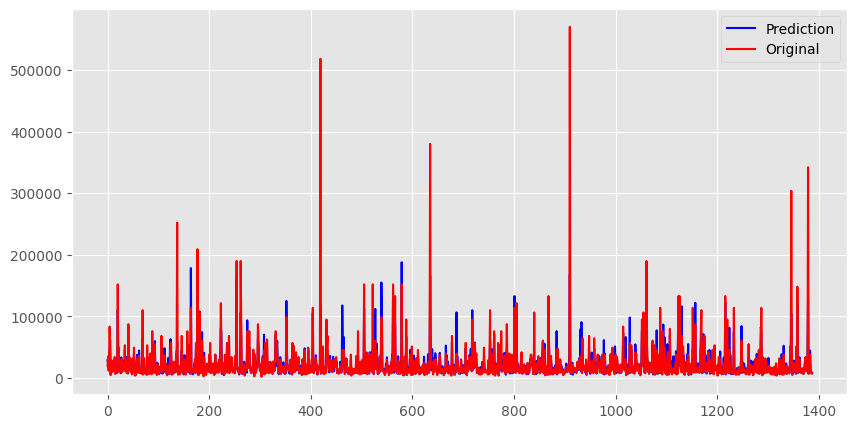

In [141]:

plt.figure(figsize=(10, 5))
ax = plt.subplot()
ax.plot(df_result['pred'], color='b', label='Prediction')
ax.plot(df_result['true'], color='r', label='Original')
plt.legend()
plt.show()

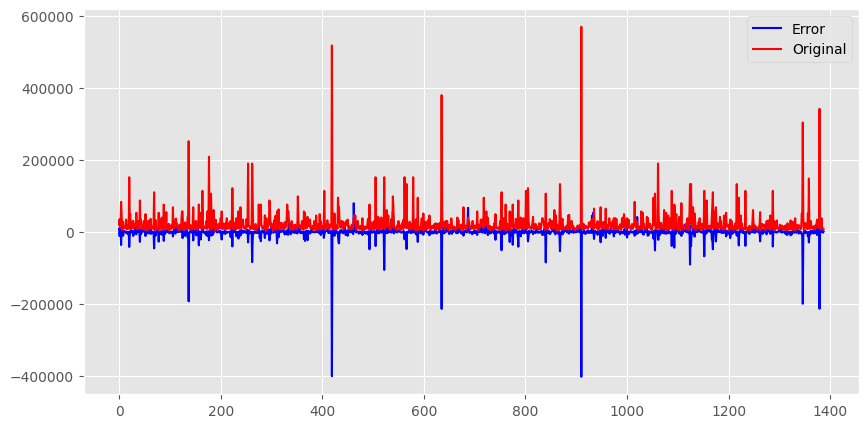

In [233]:
plt.figure(figsize=(10, 5))
ax = plt.subplot()
ax.plot(df_result['diff'], 'b', label='Error')
ax.plot(df_result['true'], 'r', label='Original')
plt.legend()
plt.show()

### Prediction intervals with MAPIE

In [156]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5549, 51), (5549,), (1388, 51), (1388,))

In [159]:
from mapie.quantile_regression import MapieQuantileRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                        random_state=24,
                                                        stratify=X['rooms'])
parameters = {
    "num_leaves": 3,
    "max_depth": 5,
    "learning_rate": 0.01,
    "n_estimators": 4730,
    "subsample": 0.6,
    "subsample_freq": 1,
    "colsample_bytree": 0.6,
    "random_state": 24,
    "force_col_wise": True,
    'min_child_samples': 30,
    'objective': 'quantile',
    'alpha': 0.05
}

regressor = lgb.LGBMRegressor(**parameters)
model = regressor.fit(X_train, y_train)

mapie = MapieQuantileRegressor(estimator=model, cv='split')
mapie.fit(X_train, y_train)

y_pred_mapie, y_pis = mapie.predict(X_test)

predictions = y_test.to_frame()
predictions.columns = ['y_true']
predictions["point prediction"] = y_pred_mapie
predictions["lower"] = y_pis.reshape(-1,2)[:,0]
predictions["upper"] = y_pis.reshape(-1,2)[:,1]
# take a quick look
predictions

d:\Мои Документы\Nata\DS\ml_course_work\env\lib\site-packages\mapie\utils.py:484: UserWarning: WARNING: The predictions of the quantile regression have issues.
The upper quantile predictions are lower
than the lower quantile predictions
at some points.
  warnings.warn(
d:\Мои Документы\Nata\DS\ml_course_work\env\lib\site-packages\mapie\utils.py:502: UserWarning: WARNING: The predictions have issues.
The upper predictions are lower thanthe lower predictions at some points.
  warnings.warn(


,y_true,point prediction,lower,upper
6374,20000,28490.974077,16400.794972,49625.625153
3354,35000,23438.998290,14288.976932,49197.746942
1239,12000,18188.099507,11411.482556,31128.305156
1600,26000,32007.154344,18539.045376,45143.237327
3672,83562,45005.071735,23729.951404,81418.062949
...,...,...,...,...
704,38000,48370.906312,27032.204489,91378.129626
759,8000,9892.959775,7317.465388,13417.165772
3328,9000,8512.374745,5645.986165,12308.389409
4401,9500,8727.293156,5952.682212,11871.755998


In [247]:
parameters = {
    "num_leaves": 3,
    "max_depth": 5,
    "learning_rate": 0.1,
    "n_estimators": 805,
    "subsample": 0.6,
    "subsample_freq": 1,
    "colsample_bytree": 0.6,
    "random_state": 24,
    "force_col_wise": True,
    'min_child_samples': 100,
    'objective': 'regression',
    'metric': 'custom',
}

model = lgb.LGBMRegressor(**parameters)
model.fit(X, y)

y_pred = model.predict(X)

def likelihood_obj(log_var: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    grad = 1 - (y_pred - y_true) ** 2 / np.exp(log_var)
    hess = (y_pred - y_true) ** 2 * np.exp(-1 * log_var)
    return grad, hess

variance_estimator = lgb.train(
    parameters,
    lgb.Dataset(X, y),
    num_boost_round=805,
    fobj=likelihood_obj,
)

log_var_pred = variance_estimator.predict(X)
std_pred = np.sqrt(np.exp(log_var_pred))

df = pd.DataFrame({
    "y": y,
    "pred": y_pred,
    "lower*1": y_pred - std_pred * 1,
    "upper*1": y_pred + std_pred * 1,

    # "upper*2": y_pred + std_pred * 2,
    # "lower*2": y_pred - std_pred * 2,
    # "upper*3": y_pred + std_pred * 3,
    # "lower*3": y_pred - std_pred * 3,
})

df

d:\Мои Документы\Nata\DS\ml_course_work\env\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Info] Total Bins 1899
[LightGBM] [Info] Number of data points in the train set: 6937, number of used features: 49
[LightGBM] [Warning] Using self-defined objective function


,y,pred,lower*1,upper*1
0,8499,11166.338372,8897.267298,13435.409446
1,37962,19941.072612,11406.663302,28475.481922
2,38000,39222.215502,29891.940187,48552.490817
3,23000,31142.387839,20369.287141,41915.488537
4,14000,13847.566647,11390.160981,16304.972312
...,...,...,...,...
6932,9200,7084.363774,4777.087517,9391.640031
6933,41800,54058.753395,32467.291123,75650.215666
6934,38000,34949.328680,23761.137869,46137.519491
6935,9500,8544.661740,7135.325201,9953.998279


In [222]:
print(f"{y_test_pred[:5]}±{std}")

[34419.83899511 45497.07637341 19192.80335285 30563.79760791
 44785.56429984]±14134.447733690187


### Confidence interval for ensembling 

In [176]:
from mapie.regression import MapieRegressor

In [259]:
def conf_interval(models):
    #res = []
    estimators = []
    predictions = y_test.to_frame()
    predictions.columns = ['y_true']
    for i, model in enumerate(models):
        model.fit(X_train, y_train)

        estimators.append(model)
        mapie_reg = MapieRegressor(estimator=model, cv=kf, agg_function='median')
        mapie_reg.fit(X_train, y_train)

        y_pred_mapie, y_pis = mapie_reg.predict(X_test, ensemble=True, alpha=0.3)

        predictions[f"point prediction_{i}"] = y_pred_mapie
        predictions[f"lower_{i}"] = y_pis.reshape(-1,2)[:,0]
        predictions[f"upper_{i}"] = y_pis.reshape(-1,2)[:,1]
    predictions['prediction'] = predictions.filter(regex='point').mean(axis=1)
    predictions['lower'] = predictions.filter(regex='lower').mean(axis=1)
    predictions['upper'] = predictions.filter(regex='upper').mean(axis=1)
    predictions['error_lower'] = predictions['prediction'] - predictions['lower']
    predictions['error_upper'] = predictions['upper'] - predictions['prediction']
    predictions['error'] = predictions.filter(regex='error').mean(axis=1)

    return predictions[['y_true', 'prediction', 'error']]

In [179]:
parameters_1 = {
    "num_leaves": 3,
    "max_depth": 5,
    "learning_rate": 0.1,
    "n_estimators": 805,
    "subsample": 0.6,
    "subsample_freq": 1,
    "colsample_bytree": 0.6,
    "random_state": 24,
    "force_col_wise": True,
    'min_child_samples': 100,
    'objective': 'regression',
    #'metric': 'custom',
}

model_1 = lgb.LGBMRegressor(**parameters_1)

In [174]:
parameters_2 = {
    "objective": "reg:squarederror",
    "eval_metric": "rmsle",
    "eta": 0.1,
    "verbosity": 1,
    "seed": 24,
    "tree_method": "hist",
    "grow_policy": "lossguide",

    # regularization parameters
    "max_depth": 5,
    "max_leaves": 3,
    "subsample": 0.7,
    "colsample_bytree": 0.6,
}

model_2 = xgb.XGBRegressor(**parameters_2)

In [260]:
models = [model_1, model_2]
df_res = conf_interval(models)
df_res

,y_true,prediction,error
6374,20000,29141.360069,6420.885004
3354,35000,31177.102538,7779.044735
1239,12000,17894.931609,6464.276152
1600,26000,29085.572356,6315.540823
3672,83562,47641.912858,7377.801746
...,...,...,...
704,38000,50180.312285,7625.424112
759,8000,9478.265549,6231.446759
3328,9000,8370.155589,6200.758128
4401,9500,7884.632424,6245.473511


### Feature Interactions with xgbfir

In [272]:
X_transform = transformer.fit_transform(X)

xgb_train = xgb.DMatrix(X_transform, y)

num_rounds = 1_000

parameters_xgb = {
    "objective": "reg:squarederror",
    "eval_metric": "rmsle",
    "eta": 0.1,
    "verbosity": 1,
    "seed": 24,
    "tree_method": "hist",
    "grow_policy": "lossguide",

    # regularization parameters
    "max_depth": 5,
    "max_leaves": 3,
    "subsample": 0.7,
    "colsample_bytree": 0.6,
}

results = xgb.cv(parameters_xgb, xgb_train, num_rounds,
                 folds=kf, early_stopping_rounds=10, verbose_eval=50)


[0]	train-rmsle:2.20578+0.00492	test-rmsle:2.20815+0.02374
[50]	train-rmsle:0.39389+0.00395	test-rmsle:0.40019+0.00694
[100]	train-rmsle:0.36168+0.00309	test-rmsle:0.37069+0.00780
[150]	train-rmsle:0.35161+0.00195	test-rmsle:0.36366+0.00779
[200]	train-rmsle:0.34545+0.00246	test-rmsle:0.36068+0.00779
[203]	train-rmsle:0.34530+0.00250	test-rmsle:0.36056+0.00779


In [275]:
model = xgb.train(parameters_xgb, xgb_train, num_boost_round=205)
xgbfir.saveXgbFI(
    model,
    feature_names=transformer.get_feature_names_out().tolist(),
    OutputXlsxFile=pjoin("../data", "xgbfir_importance_new.xlsx")
)

In [301]:
data = pd.read_csv('../data/real_estate_geo_location_fix_error_fe_log.csv')

data['full_area|kitchen_area_log'] = data['full_area'] / data['kitchen_area_log']

#data_te_fir['full_area_log|kitchen_area_log'] = data_te_fir['kitchen_area_log'] / data_te_fir['full_area_log']
#data_te_fir['dist_to_center|full_area'] = data_te_fir['dist_to_center'] * data_te_fir['full_area']
#data_te_fir['dist_to_center|kitchen_area'] = data_te_fir['dist_to_center'] * data_te_fir['kitchen_area']

num_feats = [col for col in data.columns if data[col].dtypes != 'object'
             and col not in black_list]
feats = num_feats + ['subway', 'district']

X, y = get_X_y(data, feats)

run_cv(pipeline, X, y, folds=5, target_log=True,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.2595, test_rmsle: 0.3004
[Fold 1] train_rmsle: 0.2633, test_rmsle: 0.2908
[Fold 2] train_rmsle: 0.2653, test_rmsle: 0.2754
[Fold 3] train_rmsle: 0.2636, test_rmsle: 0.2807
[Fold 4] train_rmsle: 0.2597, test_rmsle: 0.2932
RMSLE: 0.2881 ± 0.0090


RMSLE: 0.2894 ± 0.0089

In [47]:
data = pd.read_csv('../data/real_estate_geo_location_fix_error_fe_log.csv')

data['full_area|kitchen_area_log'] = data['full_area'] / data['kitchen_area_log']
# data['designer_renovation|full_area'] = data['designer_renovation'] * data['full_area']
# data['dist_to_center|full_area'] = data['dist_to_center'] * data['full_area']
# data['kitchen_area|rooms'] = data['kitchen_area'] / data['rooms']
data['dist_to_center|full_area_log'] = data['dist_to_center'] / data['full_area_log']

#data_te_fir['full_area_log|kitchen_area_log'] = data_te_fir['kitchen_area_log'] / data_te_fir['full_area_log']

#data_te_fir['dist_to_center|kitchen_area'] = data_te_fir['dist_to_center'] * data_te_fir['kitchen_area']

num_feats = [col for col in data.columns if data[col].dtypes != 'object'
             and col not in black_list]
feats = num_feats + ['subway', 'district']

X, y = get_X_y(data, feats)

run_cv(pipeline, X, y, folds=5, target_log=True,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.2573, test_rmsle: 0.3001
[Fold 1] train_rmsle: 0.2628, test_rmsle: 0.2927
[Fold 2] train_rmsle: 0.2646, test_rmsle: 0.2747
[Fold 3] train_rmsle: 0.2638, test_rmsle: 0.2792
[Fold 4] train_rmsle: 0.2597, test_rmsle: 0.2933
RMSLE: 0.2880 ± 0.0095


RMSLE: 0.2881 ± 0.0090

In [317]:
data = pd.read_csv('../data/real_estate_geo_location_fix_error_fe_log.csv')

data['full_area|kitchen_area_log'] = data['full_area'] / data['kitchen_area_log']
# data['designer_renovation|full_area'] = data['designer_renovation'] * data['full_area']
#data['dist_to_center|full_area'] = data['dist_to_center'] * data['full_area']
data['kitchen_area|rooms'] = data['kitchen_area'] / data['rooms']
# data['dist_to_center|full_area_log'] = data['dist_to_center'] * data['full_area_log']
data['full_area_log|kitchen_area'] = data['full_area_log'] / data['kitchen_area']

data['full_area|kitchen_area'] = data['kitchen_area'] * data['full_area']

data['full_area_log|kitchen_area_log'] = data['kitchen_area_log'] / data['full_area_log']

# data['dist_to_center|kitchen_area'] = data['dist_to_center'] / data['kitchen_area']

num_feats = [col for col in data.columns if data[col].dtypes != 'object'
             and col not in black_list]
feats = num_feats + ['subway', 'district']

X, y = get_X_y(data, feats)

run_cv(pipeline, X, y, folds=5, target_log=True,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.2572, test_rmsle: 0.3026
[Fold 1] train_rmsle: 0.2623, test_rmsle: 0.2925
[Fold 2] train_rmsle: 0.2633, test_rmsle: 0.2757
[Fold 3] train_rmsle: 0.2649, test_rmsle: 0.2794
[Fold 4] train_rmsle: 0.2588, test_rmsle: 0.2966
RMSLE: 0.2894 ± 0.0102


In [322]:
data['needs_repairs'] = data['needs_cosmetic_repairs'] + data['needs_major_repairs']

In [323]:
black_list = ['id', 'price', 'price_log', 'class',
              'residential', 'detail', 'description',
              'subway_old', 'needs_cosmetic_repairs',
              'needs_major_repairs']
num_feats = [col for col in data.columns if data[col].dtypes != 'object' and col not in black_list]
feats = num_feats + ['subway', 'district']

In [324]:
X, y = get_X_y(data, feats)

run_cv(pipeline, X, y, folds=5, target_log=True,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.2573, test_rmsle: 0.3001
[Fold 1] train_rmsle: 0.2628, test_rmsle: 0.2927
[Fold 2] train_rmsle: 0.2646, test_rmsle: 0.2747
[Fold 3] train_rmsle: 0.2638, test_rmsle: 0.2792
[Fold 4] train_rmsle: 0.2597, test_rmsle: 0.2933
RMSLE: 0.2880 ± 0.0095


In [6]:
data.to_csv('../data/real_estate_geo_location_fix_error_fe_log_fir.csv', index=False)

In [3]:
data = pd.read_csv('../data/real_estate_geo_location_fix_error_fe_log_fir.csv')

In [4]:
data.columns

Index(['id', 'price', 'rooms', 'floor', 'adress', 'district', 'subway',
       'class', 'residential', 'description', 'detail', 'full_area',
       'living_area', 'kitchen_area', 'num_storeys', 'subway_old',
       'typical_panel', 'concrete_monolithic', 'old_brick', 'first_rental',
       'adjacent_separate', 'ukrainian_brick', 'eurorenovation',
       'satisfactory_condition', 'multilevel', 'needs_cosmetic_repairs',
       'kitchen_living_room', 'penthouse', 'old_panel', 'good_condition',
       'pre_revolutionary', 'needs_major_repairs', 'gas_block',
       'repair_in_progress', 'free_planning', 'adjacent', 'separate',
       'ukrainian_panel', 'Stalinka', 'excellent_condition', 'studio',
       'designer_renovation', 'safe', 'shower_cabin', 'wardrobe', 'TV',
       'hair_dryer', 'dishes', 'satellite_TV', 'DVD_player', 'washing_machine',
       'fireplace', 'dishwashers', 'alarms', 'bed', 'counters',
       'air_conditioning', 'refrigerator', 'jacuzzi', 'microwave', 'iron',
       '

In [20]:
data['subway'].fillna('unknown', inplace=True)


In [21]:
data.to_csv('../data/real_estate_geo_location_fe_log_fir_fillna_12.05.14.40.csv', index=False)

In [93]:
X, y = get_X_y(data, feats)

transformer = ColumnTransformer(
    [('OneHot', OneHotEncoder(sparse_output=False), ['district']),
     ('labelEnc', OrdinalEncoder(), ['subway'])],
    remainder='passthrough',
    verbose_feature_names_out=False
)

transformer.set_output(transform="pandas")

parameters = {
    "num_leaves": 3,
    "max_depth": 5,
    "learning_rate": 0.1,
    "n_estimators": 805,
    "subsample": 0.6,
    "subsample_freq": 1,
    "colsample_bytree": 0.6,
    "random_state": 24,
    "force_col_wise": True,
    'min_child_samples': 100,
    'objective': 'regression',
    'metric': 'custom',
}
model = lgb.LGBMRegressor(**parameters)

pipeline = Pipeline([
    ('transform', transformer),
    ('regr', model)
])

# lgb_train = lgb.Dataset(X, np.log1p(y),
#                         feature_name=num_feats,
#                         free_raw_data=False)

run_cv(pipeline, X, y, folds=5, target_log=True,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.2595, test_rmsle: 0.3007
[Fold 1] train_rmsle: 0.2631, test_rmsle: 0.2934
[Fold 2] train_rmsle: 0.2653, test_rmsle: 0.2775
[Fold 3] train_rmsle: 0.2644, test_rmsle: 0.2821
[Fold 4] train_rmsle: 0.2625, test_rmsle: 0.2929
RMSLE: 0.2893 ± 0.0084


In [22]:
black_list = ['id', 'price', 'class',
              'residential', 'detail', 'description',
              'subway_old', 'needs_cosmetic_repairs',
              'needs_major_repairs']
num_feats = [col for col in data.columns if data[col].dtypes != 'object' and col not in black_list]
feats = num_feats + ['subway', 'district']


In [52]:
data['kitchen_area_log'] = np.log1p(data['kitchen_area'])

In [53]:
data['kitchen_area_log'].describe()

count    6937.000000
mean        2.554359
std         0.510532
min         0.693147
25%         2.197225
50%         2.564949
75%         2.890372
max         5.081404
Name: kitchen_area_log, dtype: float64

In [54]:
data['full_area|kitchen_area_log'] = data['full_area'] / data['kitchen_area_log']

In [56]:
data['full_area_log'] = np.log1p(data['full_area'])

In [58]:
data['full_area_log'].describe()

count    6937.000000
mean        4.128985
std         0.481329
min         2.772589
25%         3.828641
50%         4.043051
75%         4.394449
max         6.398595
Name: full_area_log, dtype: float64

In [59]:
data['dist_to_center|full_area_log'] = data['dist_to_center'] / data['full_area_log']

In [60]:
X, y = get_X_y(data, feats)

In [61]:
transformer = ColumnTransformer(
    [('OneHot', OneHotEncoder(sparse_output=False), ['district', 'subway'])],
    remainder='passthrough',
    verbose_feature_names_out=False
)

transformer.set_output(transform="pandas")
X_transform = transformer.fit_transform(X)
X_transform


,district_Голосіївський,district_Дарницький,district_Деснянський,district_Дніпровський,district_Оболонський,district_Печерський,district_Подільський,district_Святошинський,district_Солом'янський,district_Шевченківський,...,dist_to_center,full_area_log,floor_other,num_storeys_other,living_area_log,kitchen_area_log,last_floor,first_floor,full_area|kitchen_area_log,dist_to_center|full_area_log
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,4.923706,4.912655,14,17,4.605170,3.258097,False,False,41.435236,1.002250
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.341385,4.615121,6,6,4.382027,2.397895,True,False,41.703239,0.290650
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,13.441357,3.637586,19,24,2.944439,2.197225,False,False,16.839426,3.695131
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.264119,3.610918,18,25,2.708050,2.564949,False,False,14.035365,1.457834
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,7.171231,3.970292,18,25,2.995732,2.564949,False,False,20.273305,1.806223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6932,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,10.513925,3.931826,9,25,2.995732,2.772589,False,False,18.033688,2.674057
6933,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,10.100934,3.610918,8,9,2.995732,2.197225,False,False,16.384306,2.797332
6934,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,8.437642,3.496508,3,9,2.772589,2.079442,False,False,15.388747,2.413163
6935,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,11.548596,3.828641,3,16,3.555348,2.302585,False,False,19.543252,3.016369


In [44]:
lgb_train = lgb.Dataset(X_transform, np.log1p(y),
                        feature_name=transformer.get_feature_names_out().tolist(),
                        free_raw_data=False)

num_boost_round = 2000

def rmsle_lgbm(y_pred, data):
    y_pred = np.expm1(y_pred)

    y_true = np.expm1(np.array(data.get_label()))
    score = np.sqrt(np.mean(np.power(np.log1p(y_true) - np.log1p(y_pred), 2)))

    return 'rmsle', score, False

parameters = {
    'objective': 'regression',
    'metric': 'custom',
    'learning_rate': 0.1,
    'random_state': 24,
    'verbose': 0,
    'force_col_wise': True,

    'num_leaves': 3,
    'max_depth': 5,
    
    'subsample': 0.6,
    'subsample_freq': 1,
    'colsample_bytree': 0.6,
    'min_data_in_leaf': 100,
}

model = lgb.cv(
        params=parameters,
        train_set=lgb_train,
        num_boost_round=num_boost_round,
        folds=kf,
        eval_train_metric=True,
        feval=rmsle_lgbm,
        callbacks=[lgb.early_stopping(10), lgb.log_evaluation(50)]
    )

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Training until validation scores don't improve for 10 rounds
[50]	cv_agg's train rmsle: 0.329934 + 0.00209652	cv_agg's valid rmsle: 0.334175 + 0.00990388
[100]	cv_agg's train rmsle: 0.309519 + 0.00194263	cv_agg's valid rmsle: 0.315882 + 0.00858152
[150]	cv_agg's train rmsle: 0.300482 + 0.00187763	cv_agg's valid rmsle: 0.308499 + 0.00767799
[200]	cv_agg's train rmsle: 0.293974 + 0.0015426	cv_agg's valid rmsle: 0.303543 + 0.00726234
[250]	cv_agg's train rmsle: 0.28919 + 0.00168882	cv_agg's valid rmsle: 0.299898 + 0.00686542
[300]	cv_agg's train rmsle: 0.285431 + 0.00156736	cv_agg's valid rmsle: 0.297425 + 0.00680471
[350]	cv_agg's train rmsle: 0.282441 + 0.00163312	cv_agg's valid rmsle: 0.296106 + 0.00673652
[400]	cv_agg's train rmsle: 0.279667 + 0.00171651	cv_agg's valid rmsle: 0.294792 + 0.00691428
Early stopping, best iteration is:
[398]	cv_agg's train rmsle: 0.279746 + 0.00170017	cv_agg's valid rmsle: 0.2

In [45]:
X_transform.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6937 entries, 0 to 6936
Columns: 129 entries, district_Голосіївський to needs_repairs
dtypes: bool(2), float64(77), int64(50)
memory usage: 6.7 MB


In [62]:
X_transform.columns.to_series()[np.isinf(X_transform).any()]

Series([], dtype: object)

In [63]:
xgb_train = xgb.DMatrix(X_transform, np.log1p(y))

num_rounds = 1_000

parameters_xgb = {
    "objective": "reg:squarederror",
    "eval_metric": "rmsle",
    "eta": 0.1,
    "verbosity": 1,
    "seed": 24,
    "tree_method": "hist",
    "grow_policy": "lossguide",

    # regularization parameters
    "max_depth": 5,
    "max_leaves": 3,
    "subsample": 0.7,
    "colsample_bytree": 0.6,
}

model = xgb.train(parameters_xgb, xgb_train, num_boost_round=205)
xgbfir.saveXgbFI(
    model,
    feature_names=transformer.get_feature_names_out().tolist(),
    OutputXlsxFile=pjoin("../data", "xgbfir_importance_new_log.xlsx")
)

In [64]:
data.to_csv('../data/real_estate_geo_location_fe_log1p_fir_fillna_12.05.16.20.csv', index=False)

In [90]:
num_feats = [col for col in data.columns if data[col].dtypes != 'object'
             and col not in black_list]
feats = num_feats + ['subway', 'district']

X, y = get_X_y(data, feats)

run_cv(pipeline, X, y, folds=5, target_log=True,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.2622, test_rmsle: 0.3020
[Fold 1] train_rmsle: 0.2651, test_rmsle: 0.2939
[Fold 2] train_rmsle: 0.2669, test_rmsle: 0.2769
[Fold 3] train_rmsle: 0.2664, test_rmsle: 0.2855
[Fold 4] train_rmsle: 0.2638, test_rmsle: 0.2952
RMSLE: 0.2907 ± 0.0087


In [88]:
transformer = ColumnTransformer(
    [('OneHot', OneHotEncoder(sparse_output=False), ['district', 'subway'])],
    remainder='passthrough',
    verbose_feature_names_out=False
)

parameters = {
    "num_leaves": 3,
    "max_depth": 5,
    "learning_rate": 0.1,
    "n_estimators": 805,
    "subsample": 0.6,
    "subsample_freq": 1,
    "colsample_bytree": 0.6,
    "random_state": 24,
    "force_col_wise": True,
    'min_child_samples': 100,
    'objective': 'regression',
    'metric': 'custom',
}
model = lgb.LGBMRegressor(**parameters)


pipeline = Pipeline([
    ('transform', transformer),
    ('regr', model)
])

In [89]:
data = pd.read_csv('../data/real_estate_geo_location_fe_log1p_fir_fillna_12.05.16.20.csv')

data['dist_to_center|full_area_log|kitchen_area'] = data['dist_to_center'] * data['full_area'] * data['kitchen_area']

num_feats = [col for col in data.columns if data[col].dtypes != 'object'
             and col not in black_list]
feats = num_feats + ['subway', 'district']

X, y = get_X_y(data, feats)

run_cv(pipeline, X, y, folds=5, target_log=True,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.2622, test_rmsle: 0.3020
[Fold 1] train_rmsle: 0.2651, test_rmsle: 0.2939
[Fold 2] train_rmsle: 0.2669, test_rmsle: 0.2769
[Fold 3] train_rmsle: 0.2664, test_rmsle: 0.2855
[Fold 4] train_rmsle: 0.2638, test_rmsle: 0.2952
RMSLE: 0.2907 ± 0.0087


In [77]:
data = pd.read_csv('../data/real_estate_geo_location_fe_log1p_fir_fillna_12.05.16.20.csv')

data['dist_to_center|full_area_log|kitchen_area'] = data['dist_to_center'] * data['full_area'] * data['kitchen_area']
#data['dist_to_center|full_area_log|living_area_log'] = data['dist_to_center'] * data['full_area'] * data['kitchen_area'] / data['living_area_log']

# data['full_area|kitchen_area'] = data['full_area'] - data['kitchen_area']

#data['full_area|kitchen_area_log'] = data['full_area'] / data['kitchen_area_log']
# data['designer_renovation|full_area'] = data['designer_renovation'] * data['full_area']

#data['kitchen_area|rooms'] = data['kitchen_area'] / data['rooms']
## data['dist_to_center|full_area_log'] = data['dist_to_center'] * data['full_area_log']
#data['full_area_log|kitchen_area'] = data['full_area_log'] / data['kitchen_area']



#data['full_area_log|kitchen_area_log'] = data['kitchen_area_log'] / data['full_area_log']

# data['dist_to_center|kitchen_area'] = data['dist_to_center'] / data['kitchen_area']

num_feats = [col for col in data.columns if data[col].dtypes != 'object'
             and col not in black_list]
feats = num_feats + ['subway', 'district']

X, y = get_X_y(data, feats)

run_cv(pipeline, X, y, folds=5, target_log=True,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.2597, test_rmsle: 0.3014
[Fold 1] train_rmsle: 0.2609, test_rmsle: 0.2917
[Fold 2] train_rmsle: 0.2639, test_rmsle: 0.2794
[Fold 3] train_rmsle: 0.2635, test_rmsle: 0.2827
[Fold 4] train_rmsle: 0.2600, test_rmsle: 0.2947
RMSLE: 0.2900 ± 0.0080


In [84]:
data.to_csv('../data/real_estate_geo_location_fe_log1p_fir_fillna_12.05.16.20.csv', index=False)


### Ensembling techniques

In [2]:
data = pd.read_csv('../data/real_estate_geo_location_fe_log1p_fir_fillna_12.05.16.20.csv')
data.columns

FileNotFoundError: [Errno 2] No such file or directory: '../data/real_estate_geo_location_fe_log1p_fir_fillna_12.05.16.20.csv'

In [4]:
df = pd.read_csv('../data/real_estate_clean.csv')
df.columns

Index(['id', 'price', 'rooms', 'floor', 'adress', 'district', 'subway',
       'class', 'residential', 'description', 'detail', 'full_area',
       'living_area', 'kitchen_area', 'num_storeys', 'subway_old',
       'typical_panel', 'concrete_monolithic', 'old_brick', 'first_rental',
       'adjacent_separate', 'ukrainian_brick', 'eurorenovation',
       'satisfactory_condition', 'multilevel', 'needs_cosmetic_repairs',
       'kitchen_living_room', 'penthouse', 'old_panel', 'good_condition',
       'pre_revolutionary', 'needs_major_repairs', 'gas_block',
       'repair_in_progress', 'free_planning', 'adjacent', 'separate',
       'ukrainian_panel', 'Stalinka', 'excellent_condition', 'studio',
       'designer_renovation', 'safe', 'shower_cabin', 'wardrobe', 'TV',
       'hair_dryer', 'dishes', 'satellite_TV', 'DVD_player', 'washing_machine',
       'fireplace', 'dishwashers', 'alarms', 'bed', 'counters',
       'air_conditioning', 'refrigerator', 'jacuzzi', 'microwave', 'iron',
       '

In [7]:
df['needs_repairs'] = df['needs_cosmetic_repairs'] + df['needs_major_repairs']


In [10]:
data = data.merge(df[['id', 'needs_repairs']], how='left', on='id')
data.columns

Index(['id', 'price', 'rooms', 'floor', 'full_area', 'living_area',
       'kitchen_area', 'num_storeys', 'typical_panel', 'concrete_monolithic',
       'old_brick', 'first_rental', 'adjacent_separate', 'ukrainian_brick',
       'eurorenovation', 'satisfactory_condition', 'multilevel',
       'kitchen_living_room', 'penthouse', 'old_panel', 'good_condition',
       'pre_revolutionary', 'gas_block', 'repair_in_progress', 'free_planning',
       'adjacent', 'separate', 'ukrainian_panel', 'Stalinka',
       'excellent_condition', 'studio', 'designer_renovation', 'safe',
       'shower_cabin', 'wardrobe', 'TV', 'hair_dryer', 'dishes',
       'satellite_TV', 'DVD_player', 'washing_machine', 'fireplace',
       'dishwashers', 'alarms', 'bed', 'counters', 'air_conditioning',
       'refrigerator', 'jacuzzi', 'microwave', 'iron', 'cable_TV', 'lat',
       'lon', 'district_lat', 'district_lon', 'min_dist_to_subway',
       'dist_to_center', 'full_area_log', 'floor_other', 'num_storeys_other',
 

In [12]:
data.to_csv('../data/real_estate_last.csv', index=False)

In [86]:
black_list = ['id', 'price', 'class', 'residential', 'detail', 'description', 'subway_old']
num_feats = [col for col in data.columns if data[col].dtypes != 'object' and col not in black_list]
feats = num_feats + ['subway', 'district']

In [ ]:
#del_without_log_feats = ['full_area_log', 'living_area_log', 'kitchen_area_log', 'floor', 'num_storeys']
#feats = [x for x in num_feats if x not in del_without_log_feats]

In [109]:
X, y = get_X_y(data, feats)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    random_state=24,
                                                    stratify=X['rooms'])

In [234]:
transformer = ColumnTransformer(
    [('OneHot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), ['district']),
     ('labelEnc', OrdinalEncoder(handle_unknown='use_encoded_value', encoded_missing_value=-1, unknown_value=-1), ['subway'])],
    remainder='passthrough',
    verbose_feature_names_out=False
)

transformer.set_output(transform="pandas")

ColumnTransformer(remainder='passthrough',
                  transformers=[('OneHot',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['district']),
                                ('labelEnc',
                                 OrdinalEncoder(encoded_missing_value=-1,
                                                handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 ['subway'])],
                  verbose_feature_names_out=False)

In [112]:
transformer = ColumnTransformer(
    [('OneHot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), ['district']),
     ('labelEnc', OrdinalEncoder(encoded_missing_value=-1), ['subway'])],
    remainder='passthrough',
    verbose_feature_names_out=False
)

transformer.set_output(transform="pandas")

parameters = {
    "num_leaves": 3,
    "max_depth": 5,
    "learning_rate": 0.1,
    "n_estimators": 805,
    "subsample": 0.6,
    "subsample_freq": 1,
    "colsample_bytree": 0.6,
    "random_state": 24,
    "force_col_wise": True,
    'min_child_samples': 100,
    'objective': 'regression',
    'metric': 'custom',
}
model = lgb.LGBMRegressor(**parameters)

pipeline = Pipeline([
    ('transform', transformer),
    ('regr', model)
])

# lgb_train = lgb.Dataset(X, np.log1p(y),
#                         feature_name=num_feats,
#                         free_raw_data=False)

run_cv(pipeline, X, y, folds=5, target_log=True,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.2595, test_rmsle: 0.3007
[Fold 1] train_rmsle: 0.2631, test_rmsle: 0.2934
[Fold 2] train_rmsle: 0.2653, test_rmsle: 0.2775
[Fold 3] train_rmsle: 0.2644, test_rmsle: 0.2821
[Fold 4] train_rmsle: 0.2625, test_rmsle: 0.2929
RMSLE: 0.2893 ± 0.0084


In [116]:
parameters_1 = {
    "num_leaves": 3,
    "max_depth": 5,
    "learning_rate": 0.1,
    "n_estimators": 805,
    "subsample": 0.6,
    "subsample_freq": 1,
    "colsample_bytree": 0.6,
    "random_state": 24,
    "force_col_wise": True,
    'min_child_samples': 100,
    'objective': 'regression',
    #'metric': 'custom',
}

model_1 = lgb.LGBMRegressor(**parameters_1)

pipeline_lgb = Pipeline([
    ('transform', transformer),
    ('regr', model_1)
])

In [150]:
parameters_2 = {
    "objective": "reg:squarederror",
    "eval_metric": "rmsle",
    "eta": 0.3,
    "verbosity": 1,
    "seed": 24,
    "tree_method": "hist",
    "grow_policy": "lossguide",

    # regularization parameters
    "max_depth": 5,
    "max_leaves": 3,
    "subsample": 0.7,
    "colsample_bytree": 0.6,
    'n_estimators': 1000

}

model_2 = xgb.XGBRegressor(**parameters_2)

pipeline_xgb = Pipeline([
    ('transform', transformer),
    ('regr', model_2)
])

In [171]:
parameters_3 = {
    "num_leaves": 3,
    "max_depth": 5,
    "learning_rate": 0.3,
    "n_estimators": 1000,
    "subsample": 0.6,
    "subsample_freq": 1,
    "colsample_bytree": 0.6,
    "random_state": 24,
    "force_col_wise": True,
    'min_child_samples': 150,
    'objective': 'regression',
    'metric': 'custom',
}

model_3 = lgb.LGBMRegressor(**parameters_3)

pipeline_lgb_3 = Pipeline([
    ('transform', transformer),
    ('regr', model_3)
])

run_cv(pipeline_lgb_3, X, y, folds=5, target_log=True,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.2368, test_rmsle: 0.2990
[Fold 1] train_rmsle: 0.2389, test_rmsle: 0.2892
[Fold 2] train_rmsle: 0.2398, test_rmsle: 0.2780
[Fold 3] train_rmsle: 0.2392, test_rmsle: 0.2831
[Fold 4] train_rmsle: 0.2392, test_rmsle: 0.2923
RMSLE: 0.2883 ± 0.0073


In [151]:
lgb_predictions = []
xgb_predictions = []

for train, val in skf.split(X, X['rooms']):
    pipeline_lgb.fit(X.iloc[train], np.log1p(y[train]))
    pipeline_xgb.fit(X.iloc[train], np.log1p(y[train]))
    lgb_predictions.append([y[val], np.expm1(pipeline_lgb.predict(X.iloc[val]))])
    xgb_predictions.append([y[val], np.expm1(pipeline_xgb.predict(X.iloc[val]))])

In [152]:
np.mean([rmsle_score(i[0], i[1]) for i in lgb_predictions]), np.mean([rmsle_score(i[0], i[1]) for i in xgb_predictions])

(0.28931890112851333, 0.28495777125198185)

In [153]:
np.mean([rmsle_score(lgb_p[0], lgb_p[1]*0.5 + xgb_p[1]*0.5) for lgb_p, xgb_p in zip(lgb_predictions, xgb_predictions)])

0.28050333529689697

In [154]:
np.mean([rmsle_score(lgb_p[0], np.sqrt(lgb_p[1] * xgb_p[1])) for lgb_p, xgb_p in zip(lgb_predictions, xgb_predictions)])

0.2806573063377322

In [158]:
np.mean([rmsle_score(lgb_p[0], lgb_p[1]*0.4+ xgb_p[1]*0.6) for lgb_p, xgb_p in zip(lgb_predictions, xgb_predictions)])

0.2803402717164162

def ensembling_models(models):
    model_pred = []
    for model in models:
        name_pred = f"{model}_predictions"
        name_pred = []
    
        for train, val in skf.split(X, X['rooms']):
            model.fit(X.iloc[train], np.log1p(y[train]))
            name_pred.append([y[val], np.expm1(model.predict(X.iloc[val]))])
    
        print(np.mean([rmsle_score(i[0], i[1]) for i in name_pred]))

    model_pred.append(name_pred)
    
    return model_pred
    # np.mean([rmsle_score(lgb_p[0], lgb_p[1]*0.5 + xgb_p[1]*0.5) for lgb_p, xgb_p in zip(lgb_predictions, xgb_predictions)])

In [174]:
predictions_1 = []
predictions_2 = []
predictions_3 = []

for train, val in skf.split(X, X['rooms']):
    pipeline_lgb.fit(X.iloc[train], np.log1p(y[train]))
    pipeline_xgb.fit(X.iloc[train], np.log1p(y[train]))
    pipeline_lgb_3.fit(X.iloc[train], np.log1p(y[train]))
    predictions_1.append([y[val], np.expm1(pipeline_lgb.predict(X.iloc[val]))])
    predictions_2.append([y[val], np.expm1(pipeline_xgb.predict(X.iloc[val]))])
    predictions_3.append([y[val], np.expm1(pipeline_lgb_3.predict(X.iloc[val]))])

In [175]:
(
    np.mean([rmsle_score(i[0], i[1]) for i in predictions_1]), 
    np.mean([rmsle_score(i[0], i[1]) for i in predictions_2]),
    np.mean([rmsle_score(i[0], i[1]) for i in predictions_3]),
    )

(0.28931890112851333, 0.28495777125198185, 0.2887370807905869)

In [176]:
np.mean(
    [rmsle_score(p_1[0], p_1[1]*0.34 + p_2[1]*0.33 + p_3[1]*0.33) for p_1, p_2, p_3 in zip(predictions_1, predictions_2, predictions_3)]
    )

0.279611223591692

In [180]:
np.mean(
    [rmsle_score(p_1[0], (p_1[1]*p_2[1]*p_3[1])**(1./3)) 
        for p_1, p_2, p_3 in zip(predictions_1, predictions_2, predictions_3)]
    )

0.2797373696705005

In [184]:
np.mean(
    [rmsle_score(p_1[0], np.median((p_1[1], p_2[1], p_3[1]), axis=0))
        for p_1, p_2, p_3 in zip(predictions_1, predictions_2, predictions_3)]
    )

0.2822203271229286

In [188]:
import catboost as ctb

In [239]:
parameters_1 = {
    "num_leaves": 3,
    "max_depth": 5,
    "learning_rate": 0.1,
    "n_estimators": 805,
    "subsample": 0.6,
    "subsample_freq": 1,
    "colsample_bytree": 0.6,
    "random_state": 24,
    "force_col_wise": True,
    'min_child_samples': 100,
    'objective': 'regression',
    #'metric': 'custom',
}

model_1 = lgb.LGBMRegressor(**parameters_1)

pipeline_1 = Pipeline([
    ('transform', transformer),
    ('regr', model_1)
])

In [240]:
parameters_2 = {
    "objective": "reg:squarederror",
    "eval_metric": "rmsle",
    "eta": 0.3,
    "verbosity": 1,
    "seed": 24,
    "tree_method": "hist",
    "grow_policy": "lossguide",

    # regularization parameters
    "max_depth": 5,
    "max_leaves": 3,
    "subsample": 0.7,
    "colsample_bytree": 0.6,
    'n_estimators': 1000

}

model_2 = xgb.XGBRegressor(**parameters_2)

pipeline_2 = Pipeline([
    ('transform', transformer),
    ('regr', model_2)
])

In [241]:
parameters_ctb = {
    #"loss_function": "Logloss",
    #"eval_metric": "rms",
    "iterations": 1000,
    "learning_rate": 0.1,
    "random_seed": 24,
    "od_wait": 30,
    "od_type": "Iter",
    "thread_count": 4,
    "verbose": False
}

model_4 = ctb.CatBoostRegressor(**parameters_ctb)

pipeline_3 = Pipeline([
    ('transform', transformer),
    ('regr', model_4)
])


In [195]:
predictions_1 = []
predictions_2 = []
predictions_3 = []

for train, val in skf.split(X, X['rooms']):
    pipeline_1.fit(X.iloc[train], np.log1p(y[train]))
    pipeline_2.fit(X.iloc[train], np.log1p(y[train]))
    pipeline_3.fit(X.iloc[train], np.log1p(y[train]))
    predictions_1.append([y[val], np.expm1(pipeline_1.predict(X.iloc[val]))])
    predictions_2.append([y[val], np.expm1(pipeline_2.predict(X.iloc[val]))])
    predictions_3.append([y[val], np.expm1(pipeline_3.predict(X.iloc[val]))])

In [196]:
(
    np.mean([rmsle_score(i[0], i[1]) for i in predictions_1]), 
    np.mean([rmsle_score(i[0], i[1]) for i in predictions_2]),
    np.mean([rmsle_score(i[0], i[1]) for i in predictions_3]),
    )

(0.28931890112851333, 0.28495777125198185, 0.26905106991954375)

In [197]:
np.mean(
    [rmsle_score(p_1[0], p_1[1]*0.34 + p_2[1]*0.33 + p_3[1]*0.33) for p_1, p_2, p_3 in zip(predictions_1, predictions_2, predictions_3)]
    )

0.2726865348315053

In [198]:
np.mean(
    [rmsle_score(p_1[0], (p_1[1]*p_2[1]*p_3[1])**(1./3)) 
        for p_1, p_2, p_3 in zip(predictions_1, predictions_2, predictions_3)]
    )

0.2727094613914164

In [199]:
np.mean(
    [rmsle_score(p_1[0], np.median((p_1[1], p_2[1], p_3[1]), axis=0))
        for p_1, p_2, p_3 in zip(predictions_1, predictions_2, predictions_3)]
    )

0.27387953665154646

In [200]:
from sklearn.linear_model import LinearRegression

In [228]:
model_5 = ExtraTreesRegressor(
    max_depth=10, max_features=0.6,
    bootstrap=True, 
    random_state=24, max_samples=0.8)

pipeline_5 = Pipeline([
    ('transform', transformer),
    ('regr', model_5)
])

transformer.set_output(transform='pandas')

run_cv(pipeline_5, X.fillna('unknown'), y, folds=5, target_log=True,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.2248, test_rmsle: 0.3075
[Fold 1] train_rmsle: 0.2261, test_rmsle: 0.3075
[Fold 2] train_rmsle: 0.2277, test_rmsle: 0.2878
[Fold 3] train_rmsle: 0.2263, test_rmsle: 0.2896
[Fold 4] train_rmsle: 0.2257, test_rmsle: 0.3045
RMSLE: 0.2994 ± 0.0088


In [242]:
model_5 = ExtraTreesRegressor(
    max_depth=10, max_features=0.6,
    bootstrap=True, 
    random_state=24, max_samples=0.8)

pipeline_4 = Pipeline([
    ('transform', transformer),
    ('regr', model_5)
])

In [237]:
transformer = ColumnTransformer(
    [('OneHot', OneHotEncoder(sparse_output=False), ['district']),
     ('labelEnc', OrdinalEncoder(handle_unknown='use_encoded_value', encoded_missing_value=-1, unknown_value=-1), ['subway'])],
    remainder='passthrough',
    verbose_feature_names_out=False
)

transformer.set_output(transform="pandas")

ColumnTransformer(remainder='passthrough',
                  transformers=[('OneHot', OneHotEncoder(sparse_output=False),
                                 ['district']),
                                ('labelEnc',
                                 OrdinalEncoder(encoded_missing_value=-1,
                                                handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 ['subway'])],
                  verbose_feature_names_out=False)

In [243]:
predictions_1 = []
predictions_2 = []
predictions_3 = []
predictions_4 = []

for train, val in skf.split(X, X['rooms']):
    pipeline_1.fit(X.iloc[train], np.log1p(y[train]))
    pipeline_2.fit(X.iloc[train], np.log1p(y[train]))
    pipeline_3.fit(X.iloc[train], np.log1p(y[train]))
    pipeline_4.fit(X.fillna('unknown').iloc[train], np.log1p(y[train]))
    predictions_1.append([y[val], np.expm1(pipeline_1.predict(X.iloc[val]))])
    predictions_2.append([y[val], np.expm1(pipeline_2.predict(X.iloc[val]))])
    predictions_3.append([y[val], np.expm1(pipeline_3.predict(X.iloc[val]))])
    predictions_4.append([y[val], np.expm1(pipeline_4.predict(X.iloc[val]))])

In [244]:
(
    np.mean([rmsle_score(i[0], i[1]) for i in predictions_1]), 
    np.mean([rmsle_score(i[0], i[1]) for i in predictions_2]),
    np.mean([rmsle_score(i[0], i[1]) for i in predictions_3]),
    np.mean([rmsle_score(i[0], i[1]) for i in predictions_4]),
    )

(0.2906409878532493,
 0.2876324936433311,
 0.2698980997096439,
 0.30026497485776027)

In [246]:
np.mean(
    [rmsle_score(p_1[0], p_1[1]*0.23 + p_2[1]*0.27 + p_3[1]*0.3 + p_4[1]*0.2) 
     for p_1, p_2, p_3, p_4 in zip(predictions_1, predictions_2, predictions_3, predictions_4)]
    )

0.27359056799655856

In [247]:
np.mean(
    [rmsle_score(p_1[0], p_1[1]*0.25 + p_2[1]*0.25 + p_3[1]*0.25 + p_4[1]*0.25) 
     for p_1, p_2, p_3, p_4 in zip(predictions_1, predictions_2, predictions_3, predictions_4)]
    )

0.2747529754156843

In [248]:
np.mean(
    [rmsle_score(p_1[0], (p_1[1]*p_2[1]*p_3[1]*p_4[1])**(1./4)) 
     for p_1, p_2, p_3, p_4 in zip(predictions_1, predictions_2, predictions_3, predictions_4)]
    )

0.2749663379519091

In [249]:
model_6 = LinearRegression()

pipeline_4 = Pipeline([
    ('transform', transformer),
    ('regr', model_6)
])

transformer.set_output(transform='pandas')

run_cv(pipeline_4, X.fillna('unknown'), y, folds=5, target_log=True,
       cv_type=StratifiedKFold, success_metric=rmsle_score)

[Fold 0] train_rmsle: 0.3040, test_rmsle: 0.3227
[Fold 1] train_rmsle: 0.3057, test_rmsle: 0.3167
[Fold 2] train_rmsle: 0.3098, test_rmsle: 0.2992
[Fold 3] train_rmsle: 0.3088, test_rmsle: 0.3033
[Fold 4] train_rmsle: 0.3051, test_rmsle: 0.3185
RMSLE: 0.3121 ± 0.0092


In [250]:
predictions_1 = []
predictions_2 = []
predictions_3 = []
predictions_4 = []

for train, val in skf.split(X, X['rooms']):
    pipeline_1.fit(X.iloc[train], np.log1p(y[train]))
    pipeline_2.fit(X.iloc[train], np.log1p(y[train]))
    pipeline_3.fit(X.iloc[train], np.log1p(y[train]))
    pipeline_4.fit(X.fillna('unknown').iloc[train], np.log1p(y[train]))
    predictions_1.append([y[val], np.expm1(pipeline_1.predict(X.iloc[val]))])
    predictions_2.append([y[val], np.expm1(pipeline_2.predict(X.iloc[val]))])
    predictions_3.append([y[val], np.expm1(pipeline_3.predict(X.iloc[val]))])
    predictions_4.append([y[val], np.expm1(pipeline_4.predict(X.iloc[val]))])

In [251]:
(
    np.mean([rmsle_score(i[0], i[1]) for i in predictions_1]), 
    np.mean([rmsle_score(i[0], i[1]) for i in predictions_2]),
    np.mean([rmsle_score(i[0], i[1]) for i in predictions_3]),
    np.mean([rmsle_score(i[0], i[1]) for i in predictions_4]),
    )

(0.2906409878532493,
 0.2876324936433311,
 0.2698980997096439,
 0.3120873271131016)

In [255]:
np.mean(
    [rmsle_score(p_1[0], p_1[1]*0.23 + p_2[1]*0.27 + p_3[1]*0.35 + p_4[1]*0.15) 
     for p_1, p_2, p_3, p_4 in zip(predictions_1, predictions_2, predictions_3, predictions_4)]
    )

0.27328890324673594

In [256]:
np.mean(
    [rmsle_score(p_1[0], p_1[1]*0.2 + p_2[1]*0.3 + p_3[1]*0.4 + p_4[1]*0.1) 
     for p_1, p_2, p_3, p_4 in zip(predictions_1, predictions_2, predictions_3, predictions_4)]
    )

0.27231894966501147

In [269]:
parameters_1 = {
    "num_leaves": 3,
    "max_depth": 5,
    "learning_rate": 0.1,
    "n_estimators": 805,
    "subsample": 0.6,
    "subsample_freq": 1,
    "colsample_bytree": 0.6,
    "random_state": 24,
    "force_col_wise": True,
    'min_child_samples': 100,
    'objective': 'regression',
    #'metric': 'custom',
}

model_1 = lgb.LGBMRegressor(**parameters_1)

pipeline_1 = Pipeline([
    ('transform', transformer),
    ('regr', model_1)
])


parameters_2 = {
    "objective": "reg:squarederror",
    "eval_metric": "rmsle",
    "eta": 0.3,
    "verbosity": 1,
    "seed": 24,
    "tree_method": "hist",
    "grow_policy": "lossguide",

    # regularization parameters
    "max_depth": 5,
    "max_leaves": 3,
    "subsample": 0.7,
    "colsample_bytree": 0.6,
    'n_estimators': 1000

}

model_2 = xgb.XGBRegressor(**parameters_2)

pipeline_2 = Pipeline([
    ('transform', transformer),
    ('regr', model_2)
])


parameters_ctb = {
    #"loss_function": "Logloss",
    #"eval_metric": "rms",
    "iterations": 1000,
    "learning_rate": 0.1,
    "random_seed": 24,
    "od_wait": 30,
    "od_type": "Iter",
    "thread_count": 4,
    "verbose": False
}

model_3 = ctb.CatBoostRegressor(**parameters_ctb)

pipeline_3 = Pipeline([
    ('transform', transformer),
    ('regr', model_3)
])


model_4 = LinearRegression()

pipeline_4 = Pipeline([
    ('transform', transformer),
    ('regr', model_4)
])


model_5 = ExtraTreesRegressor(
    max_depth=10, max_features=0.6,
    bootstrap=True, 
    random_state=24, max_samples=0.8)

pipeline_5 = Pipeline([
    ('transform', transformer),
    ('regr', model_5)
])

In [270]:
predictions_1 = []
predictions_2 = []
predictions_3 = []
predictions_4 = []
predictions_5 = []

for train, val in skf.split(X, X['rooms']):
    pipeline_1.fit(X.iloc[train], np.log1p(y[train]))
    pipeline_2.fit(X.iloc[train], np.log1p(y[train]))
    pipeline_3.fit(X.iloc[train], np.log1p(y[train]))
    pipeline_4.fit(X.fillna('unknown').iloc[train], np.log1p(y[train]))
    pipeline_5.fit(X.fillna('unknown').iloc[train], np.log1p(y[train]))
    predictions_1.append([y[val], np.expm1(pipeline_1.predict(X.iloc[val]))])
    predictions_2.append([y[val], np.expm1(pipeline_2.predict(X.iloc[val]))])
    predictions_3.append([y[val], np.expm1(pipeline_3.predict(X.iloc[val]))])
    predictions_4.append([y[val], np.expm1(pipeline_4.predict(X.iloc[val]))])
    predictions_5.append([y[val], np.expm1(pipeline_5.predict(X.iloc[val]))])

In [271]:
(
    np.mean([rmsle_score(i[0], i[1]) for i in predictions_1]), 
    np.mean([rmsle_score(i[0], i[1]) for i in predictions_2]),
    np.mean([rmsle_score(i[0], i[1]) for i in predictions_3]),
    np.mean([rmsle_score(i[0], i[1]) for i in predictions_4]),
    np.mean([rmsle_score(i[0], i[1]) for i in predictions_5]),
    )

(0.2906409878532493,
 0.2876324936433311,
 0.2698980997096439,
 0.3120873271131016,
 0.30026497485776027)

In [280]:
np.mean(
    [rmsle_score(p_1[0], 
                 p_1[1]*0.2 + p_2[1]*0.2 + p_3[1]*0.4 + p_4[1]*0.05 + p_5[1]*0.15) 
     for p_1, p_2, p_3, p_4, p_5 in zip(predictions_1, predictions_2,
                                   predictions_3, predictions_4,
                                   predictions_5)]
    )

0.27196467946291286

In [282]:
np.mean(
    [rmsle_score(p_1[0], 
                 p_1[1]*0.2 + p_2[1]*0.25 + p_3[1]*0.4 + p_5[1]*0.15) 
     for p_1, p_2, p_3, p_5 in zip(predictions_1, predictions_2,
                                   predictions_3, 
                                   predictions_5)]
    )

0.2719639926615077

In [284]:
np.mean(
    [rmsle_score(p_1[0], 
                 p_1[1]*0.15 + p_2[1]*0.25 + p_3[1]*0.4 + p_4[1]*0.05 + p_5[1]*0.15) 
     for p_1, p_2, p_3, p_4, p_5 in zip(predictions_1, predictions_2,
                                   predictions_3, predictions_4,
                                   predictions_5)]
    )

0.27174447511609373

In [286]:
np.mean(
    [rmsle_score(p_1[0], 
                 p_1[1]*0.1 + p_2[1]*0.3 + p_3[1]*0.4 + p_4[1]*0.05 + p_5[1]*0.15) 
     for p_1, p_2, p_3, p_4, p_5 in zip(predictions_1, predictions_2,
                                   predictions_3, predictions_4,
                                   predictions_5)]
    )

0.27166195349732336

In [316]:
data.to_csv('../data/real_estate_last.csv', index=False)

In [320]:
data[['id', 'price'] + feats].to_csv('../data/real_estate_last.csv', index=False)

In [321]:
df_last = pd.read_csv('../data/real_estate_last.csv')
df_last

,id,price,rooms,floor,full_area,living_area,kitchen_area,num_storeys,typical_panel,concrete_monolithic,...,num_storeys_other,living_area_log,kitchen_area_log,last_floor,first_floor,full_area|kitchen_area_log,dist_to_center|full_area_log,dist_to_center|full_area_log|kitchen_area,subway,district
0,10825753,133000,4,14,135.0,100.0,25.0,17,0,0,...,17,4.605170,3.258097,False,False,41.435236,1.002250,16617.507827,дружби народів,Печерський
1,10784117,22762,3,6,100.0,80.0,10.0,6,0,0,...,6,4.382027,2.397895,True,False,41.703239,0.290650,1341.384685,хрещатик,Печерський
2,10810186,8499,1,19,37.0,19.0,8.0,24,0,0,...,24,2.944439,2.197225,False,False,16.839426,3.695131,3978.641593,академмістечко,Святошинський
3,10824293,10500,1,18,36.0,15.0,12.0,25,0,1,...,25,2.708050,2.564949,False,False,14.035365,1.457834,2274.099316,лівобережна,Дніпровський
4,10819688,37962,2,18,52.0,20.0,12.0,25,0,0,...,25,2.995732,2.564949,False,False,20.273305,1.806223,4474.848099,мінська,Оболонський
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6932,10620878,16000,1,9,50.0,20.0,15.0,25,0,1,...,25,2.995732,2.772589,False,False,18.033688,2.674057,7885.443759,житомирська,Святошинський
6933,10803998,9500,1,8,36.0,20.0,8.0,9,0,0,...,9,2.995732,2.197225,False,False,16.384306,2.797332,2909.069127,святошин,Святошинський
6934,9615917,6000,2,3,32.0,16.0,7.0,9,0,0,...,9,2.772589,2.079442,False,False,15.388747,2.413163,1890.031791,святошин,Шевченківський
6935,10055853,9000,1,3,45.0,35.0,9.0,16,1,0,...,16,3.555348,2.302585,False,False,19.543252,3.016369,4677.181378,NaN,Святошинський


In [310]:
feats

['rooms',
 'floor',
 'full_area',
 'living_area',
 'kitchen_area',
 'num_storeys',
 'typical_panel',
 'concrete_monolithic',
 'old_brick',
 'first_rental',
 'adjacent_separate',
 'ukrainian_brick',
 'eurorenovation',
 'satisfactory_condition',
 'multilevel',
 'kitchen_living_room',
 'penthouse',
 'old_panel',
 'good_condition',
 'pre_revolutionary',
 'gas_block',
 'repair_in_progress',
 'free_planning',
 'adjacent',
 'separate',
 'ukrainian_panel',
 'Stalinka',
 'excellent_condition',
 'studio',
 'designer_renovation',
 'safe',
 'shower_cabin',
 'wardrobe',
 'TV',
 'hair_dryer',
 'dishes',
 'satellite_TV',
 'DVD_player',
 'washing_machine',
 'fireplace',
 'dishwashers',
 'alarms',
 'bed',
 'counters',
 'air_conditioning',
 'refrigerator',
 'jacuzzi',
 'microwave',
 'iron',
 'cable_TV',
 'lat',
 'lon',
 'district_lat',
 'district_lon',
 'min_dist_to_subway',
 'dist_to_center',
 'full_area_log',
 'floor_other',
 'num_storeys_other',
 'living_area_log',
 'kitchen_area_log',
 'last_floor',

In [302]:
black_list = ['id', 'price', 'price_log', 'class',
              'residential', 'detail', 'description',
              'subway_old', 'needs_cosmetic_repairs',
              'needs_major_repairs']
num_feats = [col for col in data.columns if data[col].dtypes != 'object' 
             and col not in black_list
             and col not in black_list]
feats = num_feats + ['subway', 'district']

In [ ]:
transformer = ColumnTransformer(
    [('OneHot', OneHotEncoder(sparse_output=False), ['district']),
     ('labelEnc', OrdinalEncoder(handle_unknown='use_encoded_value', encoded_missing_value=-1, unknown_value=-1), ['subway'])],
    remainder='passthrough',
    verbose_feature_names_out=False
)

transformer.set_output(transform="pandas")

In [303]:
X, y = get_X_y(data, feats)

parameters_1 = {
    "num_leaves": 3,
    "max_depth": 5,
    "learning_rate": 0.1,
    "n_estimators": 805,
    "subsample": 0.6,
    "subsample_freq": 1,
    "colsample_bytree": 0.6,
    "random_state": 24,
    "force_col_wise": True,
    'min_child_samples': 100,
    'objective': 'regression',
    #'metric': 'custom',
}

model_1 = lgb.LGBMRegressor(**parameters_1)

pipeline_1 = Pipeline([
    ('transform', transformer),
    ('regr', model_1)
])


parameters_2 = {
    "objective": "reg:squarederror",
    "eval_metric": "rmsle",
    "eta": 0.3,
    "verbosity": 1,
    "seed": 24,
    "tree_method": "hist",
    "grow_policy": "lossguide",

    # regularization parameters
    "max_depth": 5,
    "max_leaves": 3,
    "subsample": 0.7,
    "colsample_bytree": 0.6,
    'n_estimators': 1000

}

model_2 = xgb.XGBRegressor(**parameters_2)

pipeline_2 = Pipeline([
    ('transform', transformer),
    ('regr', model_2)
])


parameters_ctb = {
    #"loss_function": "Logloss",
    #"eval_metric": "rms",
    "iterations": 1000,
    "learning_rate": 0.1,
    "random_seed": 24,
    "od_wait": 30,
    "od_type": "Iter",
    "thread_count": 4,
    "verbose": False
}

model_3 = ctb.CatBoostRegressor(**parameters_ctb)

pipeline_3 = Pipeline([
    ('transform', transformer),
    ('regr', model_3)
])


model_4 = LinearRegression()

pipeline_4 = Pipeline([
    ('transform', transformer),
    ('regr', model_4)
])


model_5 = ExtraTreesRegressor(
    max_depth=10, max_features=0.6,
    bootstrap=True, 
    random_state=24, max_samples=0.8)

pipeline_5 = Pipeline([
    ('transform', transformer),
    ('regr', model_5)
])

In [304]:
predictions_1 = []
predictions_2 = []
predictions_3 = []
predictions_4 = []
predictions_5 = []

for train, val in skf.split(X, X['rooms']):
    pipeline_1.fit(X.iloc[train], np.log1p(y[train]))
    pipeline_2.fit(X.iloc[train], np.log1p(y[train]))
    pipeline_3.fit(X.iloc[train], np.log1p(y[train]))
    pipeline_4.fit(X.fillna('unknown').iloc[train], np.log1p(y[train]))
    pipeline_5.fit(X.fillna('unknown').iloc[train], np.log1p(y[train]))
    predictions_1.append([y[val], np.expm1(pipeline_1.predict(X.iloc[val]))])
    predictions_2.append([y[val], np.expm1(pipeline_2.predict(X.iloc[val]))])
    predictions_3.append([y[val], np.expm1(pipeline_3.predict(X.iloc[val]))])
    predictions_4.append([y[val], np.expm1(pipeline_4.predict(X.iloc[val]))])
    predictions_5.append([y[val], np.expm1(pipeline_5.predict(X.iloc[val]))])

In [305]:
(
    np.mean([rmsle_score(i[0], i[1]) for i in predictions_1]), 
    np.mean([rmsle_score(i[0], i[1]) for i in predictions_2]),
    np.mean([rmsle_score(i[0], i[1]) for i in predictions_3]),
    np.mean([rmsle_score(i[0], i[1]) for i in predictions_4]),
    np.mean([rmsle_score(i[0], i[1]) for i in predictions_5]),
    )

(0.2906409878532493,
 0.29002992521799076,
 0.2710139893548609,
 0.3120438939638127,
 0.298838779272546)

In [306]:
np.mean(
    [rmsle_score(p_1[0], 
                 p_1[1]*0.1 + p_2[1]*0.3 + p_3[1]*0.4 + p_4[1]*0.05 + p_5[1]*0.15) 
     for p_1, p_2, p_3, p_4, p_5 in zip(predictions_1, predictions_2,
                                   predictions_3, predictions_4,
                                   predictions_5)]
    )

0.27267713133027094

In [291]:
transformer = ColumnTransformer(
    [('OneHot', OneHotEncoder(sparse_output=False), ['district']),
     ('labelEnc', OrdinalEncoder(handle_unknown='use_encoded_value', encoded_missing_value=-1, unknown_value=-1), ['subway'])],
    remainder='passthrough',
    verbose_feature_names_out=False
)

transformer.set_output(transform="pandas")
X_transform = transformer.fit_transform(X)
X_transform

,district_Голосіївський,district_Дарницький,district_Деснянський,district_Дніпровський,district_Оболонський,district_Печерський,district_Подільський,district_Святошинський,district_Солом'янський,district_Шевченківський,...,full_area_log,floor_other,num_storeys_other,living_area_log,kitchen_area_log,last_floor,first_floor,full_area|kitchen_area_log,dist_to_center|full_area_log,dist_to_center|full_area_log|kitchen_area
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,4.912655,14,17,4.605170,3.258097,False,False,41.435236,1.002250,16617.507827
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,4.615121,6,6,4.382027,2.397895,True,False,41.703239,0.290650,1341.384685
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,3.637586,19,24,2.944439,2.197225,False,False,16.839426,3.695131,3978.641593
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.610918,18,25,2.708050,2.564949,False,False,14.035365,1.457834,2274.099316
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,3.970292,18,25,2.995732,2.564949,False,False,20.273305,1.806223,4474.848099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6932,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,3.931826,9,25,2.995732,2.772589,False,False,18.033688,2.674057,7885.443759
6933,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,3.610918,8,9,2.995732,2.197225,False,False,16.384306,2.797332,2909.069127
6934,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,3.496508,3,9,2.772589,2.079442,False,False,15.388747,2.413163,1890.031791
6935,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,3.828641,3,16,3.555348,2.302585,False,False,19.543252,3.016369,4677.181378


In [289]:
parameters_1 = {
    "num_leaves": 3,
    "max_depth": 5,
    "learning_rate": 0.1,
    "n_estimators": 805,
    "subsample": 0.6,
    "subsample_freq": 1,
    "colsample_bytree": 0.6,
    "random_state": 24,
    "force_col_wise": True,
    'min_child_samples': 100,
    'objective': 'regression',
    #'metric': 'custom',
}

model_1 = lgb.LGBMRegressor(**parameters_1)

In [ ]:
feats_to_drop = ['full_area_log',
                 'num_storeys_other', 'floor_other', 'first_floor']

In [296]:
parameters_2 = {
    "objective": "reg:squarederror",
    "eval_metric": "rmsle",
    "eta": 0.3,
    "verbosity": 1,
    "seed": 24,
    "tree_method": "hist",
    "grow_policy": "lossguide",

    # regularization parameters
    "max_depth": 5,
    "max_leaves": 3,
    "subsample": 0.7,
    "colsample_bytree": 0.6,
    'n_estimators': 1000

}

model_2 = xgb.XGBRegressor(**parameters_2)

model = model_2.fit(X_transform, np.log1p(y))
show_weights(model, top=100)

Weight,Feature
0.1516,designer_renovation
0.0931,kitchen_area_log
0.0834,kitchen_area
0.0789,good_condition
0.0707,dist_to_center|full_area_log
0.0631,satisfactory_condition
0.0467,full_area
0.0405,district_Деснянський
0.0253,district_Печерський
0.0215,district_Солом'янський


In [294]:
model = model_1.fit(X_transform, np.log1p(y))
show_weights(model, top=100)

Weight,Feature
0.2126,kitchen_area
0.2094,dist_to_center|full_area_log
0.1540,full_area
0.0763,designer_renovation
0.0641,full_area_log
0.0387,kitchen_area_log
0.0287,dist_to_center
0.0258,min_dist_to_subway
0.0250,good_condition
0.0229,living_area


### Boolean features

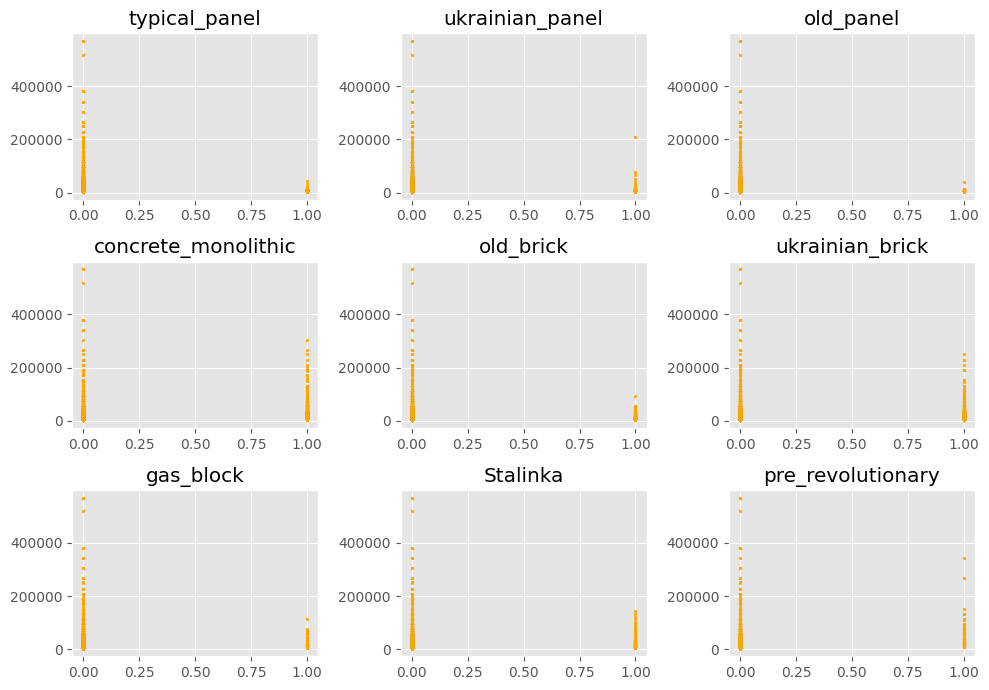

In [465]:
building_details = [
    'typical_panel', 'ukrainian_panel', 
    'old_panel', 'concrete_monolithic', 
    'old_brick', 'ukrainian_brick', 
    'gas_block', 'Stalinka', 'pre_revolutionary'
]

plt.figure(figsize=(10, 7))
for i, key in enumerate(building_details):
    plt.subplot(3, 3, i+1)
    plt.scatter(data_te_fir[key], data_te_fir["price"], s=3, color='orange')
    plt.title(key)
plt.tight_layout()
plt.show()

In [467]:
for col in building_details:
    print(data_te_fir[col].value_counts())
    print('\n')

typical_panel
0    6545
1     392
Name: count, dtype: int64


ukrainian_panel
0    6692
1     245
Name: count, dtype: int64


old_panel
0    6862
1      75
Name: count, dtype: int64


concrete_monolithic
0    5582
1    1355
Name: count, dtype: int64


old_brick
0    6646
1     291
Name: count, dtype: int64


ukrainian_brick
0    5618
1    1319
Name: count, dtype: int64


gas_block
0    6875
1      62
Name: count, dtype: int64


Stalinka
0    6695
1     242
Name: count, dtype: int64


pre_revolutionary
0    6764
1     173
Name: count, dtype: int64




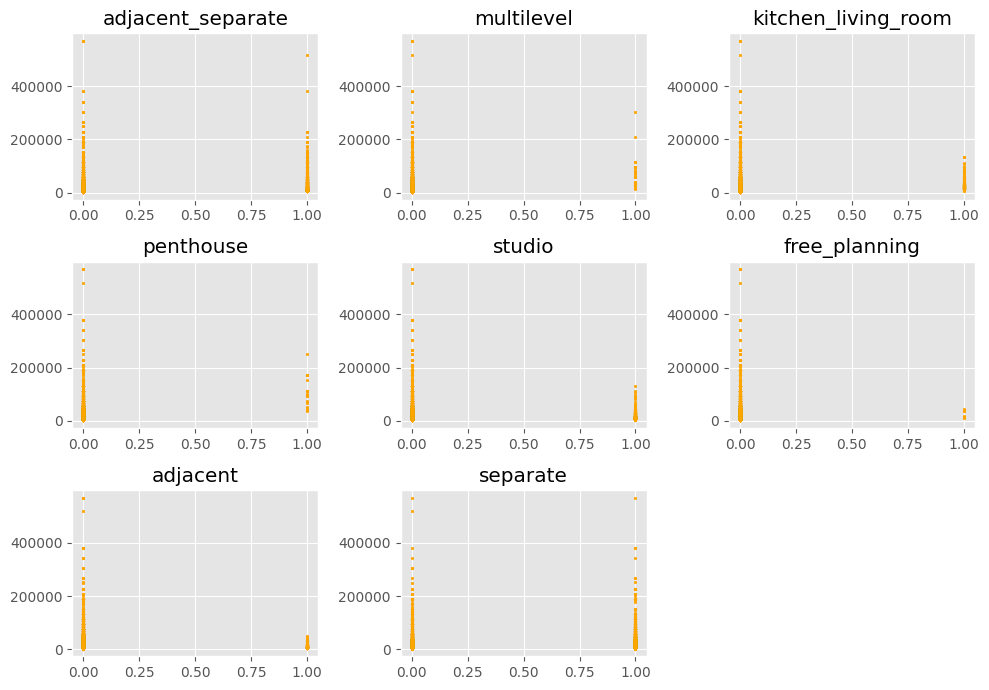

In [468]:
features_planning = [
    'adjacent_separate', 'multilevel', 'kitchen_living_room',
    'penthouse', 'studio', 'free_planning', 'adjacent', 'separate']

plt.figure(figsize=(10, 7))
for i, key in enumerate(features_planning):
    plt.subplot(3, 3, i+1)
    plt.scatter(data_te_fir[key], data_te_fir["price"], s=3, color='orange')
    plt.title(key)
plt.tight_layout()
plt.show()

In [469]:
for col in features_planning:
    print(data_te_fir[col].value_counts())
    print('\n')

adjacent_separate
0    6186
1     751
Name: count, dtype: int64


multilevel
0    6906
1      31
Name: count, dtype: int64


kitchen_living_room
0    6748
1     189
Name: count, dtype: int64


penthouse
0    6917
1      20
Name: count, dtype: int64


studio
0    6473
1     464
Name: count, dtype: int64


free_planning
0    6931
1       6
Name: count, dtype: int64


adjacent
0    6752
1     185
Name: count, dtype: int64


separate
1    4265
0    2672
Name: count, dtype: int64




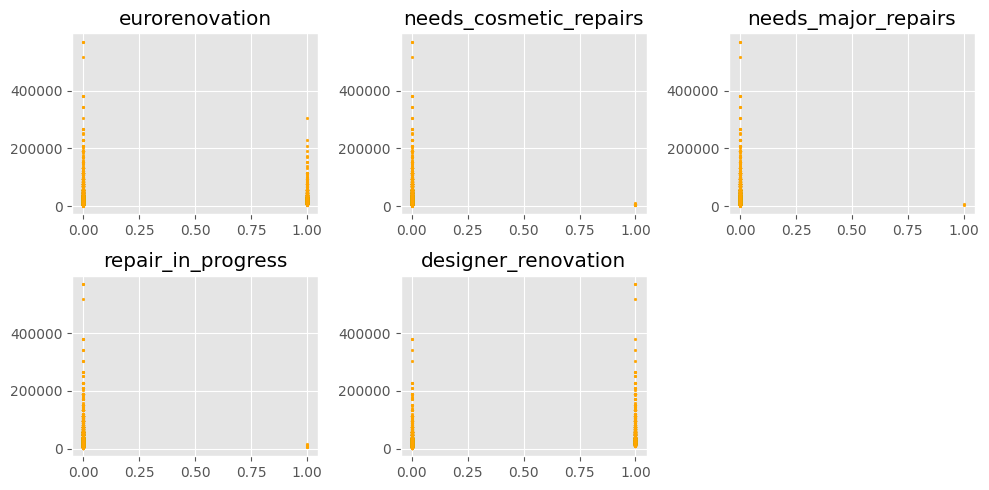

In [472]:
repair_state = [
    'eurorenovation', 'needs_cosmetic_repairs', 'needs_major_repairs',
     'repair_in_progress', 'designer_renovation']

plt.figure(figsize=(10, 5))
for i, key in enumerate(repair_state):
    plt.subplot(2, 3, i+1)
    plt.scatter(data_te_fir[key], data_te_fir["price"], s=3, color='orange')
    plt.title(key)
plt.tight_layout()
plt.show()

In [473]:
for col in repair_state:
    print(data_te_fir[col].value_counts())
    print('\n')

eurorenovation
0    4380
1    2557
Name: count, dtype: int64


needs_cosmetic_repairs
0    6923
1      14
Name: count, dtype: int64


needs_major_repairs
0    6935
1       2
Name: count, dtype: int64


repair_in_progress
0    6932
1       5
Name: count, dtype: int64


designer_renovation
0    5634
1    1303
Name: count, dtype: int64




combine 'needs_cosmetic_repairs' and 'needs_major_repairs' to one colun 'needs_repair'

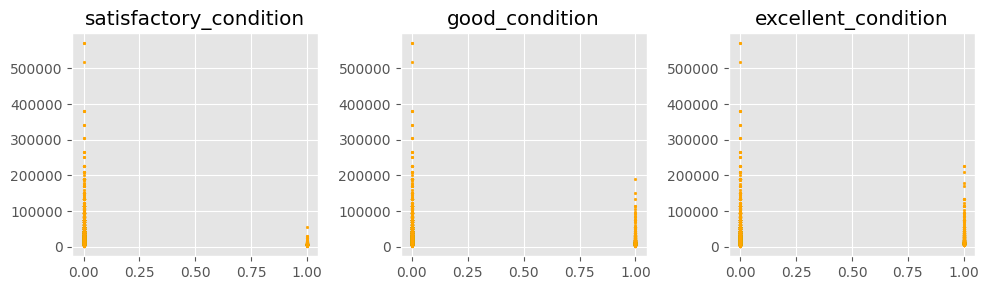

In [475]:
condition = ['satisfactory_condition',
             'good_condition', 'excellent_condition']

plt.figure(figsize=(10, 3))
for i, key in enumerate(condition):
    plt.subplot(1, 3, i+1)
    plt.scatter(data_te_fir[key], data_te_fir["price"], s=3, color='orange')
    plt.title(key)
plt.tight_layout()
plt.show()

In [476]:
for col in condition:
    print(data_te_fir[col].value_counts())
    print('\n')

satisfactory_condition
0    6622
1     315
Name: count, dtype: int64


good_condition
0    5111
1    1826
Name: count, dtype: int64


excellent_condition
0    6185
1     752
Name: count, dtype: int64




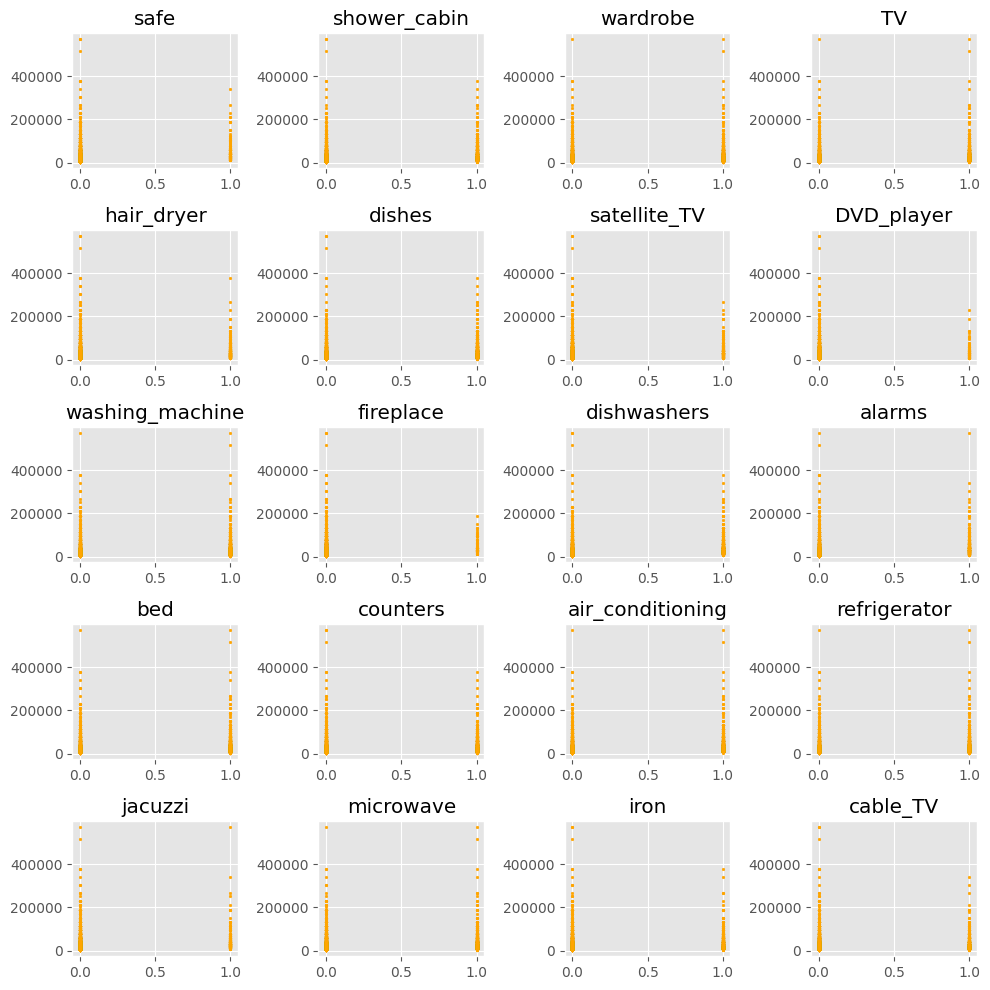

In [478]:
facilities = [
    'safe', 'shower_cabin', 'wardrobe', 'TV',
     'hair_dryer', 'dishes', 'satellite_TV', 'DVD_player',
     'washing_machine', 'fireplace', 'dishwashers', 'alarms',
     'bed', 'counters', 'air_conditioning', 'refrigerator',
     'jacuzzi', 'microwave', 'iron', 'cable_TV'
]

plt.figure(figsize=(10, 10))
for i, key in enumerate(facilities):
    plt.subplot(5, 4, i+1)
    plt.scatter(data_te_fir[key], data_te_fir["price"], s=3, color='orange')
    plt.title(key)
plt.tight_layout()
plt.show()

In [479]:
for col in facilities:
    print(data_te_fir[col].value_counts())
    print('\n')

safe
0    6780
1     157
Name: count, dtype: int64


shower_cabin
0    5873
1    1064
Name: count, dtype: int64


wardrobe
0    4048
1    2889
Name: count, dtype: int64


TV
0    4787
1    2150
Name: count, dtype: int64


hair_dryer
0    6585
1     352
Name: count, dtype: int64


dishes
0    5164
1    1773
Name: count, dtype: int64


satellite_TV
0    6687
1     250
Name: count, dtype: int64


DVD_player
0    6835
1     102
Name: count, dtype: int64


washing_machine
0    3897
1    3040
Name: count, dtype: int64


fireplace
0    6856
1      81
Name: count, dtype: int64


dishwashers
0    5841
1    1096
Name: count, dtype: int64


alarms
0    6418
1     519
Name: count, dtype: int64


bed
0    4183
1    2754
Name: count, dtype: int64


counters
0    4367
1    2570
Name: count, dtype: int64


air_conditioning
0    4826
1    2111
Name: count, dtype: int64


refrigerator
0    3853
1    3084
Name: count, dtype: int64


jacuzzi
0    6685
1     252
Name: count, dtype: int64


microwave
0    5

In [24]:
black_list = ['id', 'price']
feats = [x for x in data.columns if x not in black_list]

X = data[feats].copy()

y = data['price'].copy()

transformer = ColumnTransformer(
    [('OneHot', OneHotEncoder(sparse_output=True), ['district']),
     ('labelEnc', OrdinalEncoder(handle_unknown='use_encoded_value', encoded_missing_value=-1, unknown_value=-1), ['subway'])],
    remainder='passthrough',
    verbose_feature_names_out=False
)

X_transform = transformer.fit_transform(X)
X_transform

def rmsle_lgbm(y_pred, data):
    y_pred = np.expm1(y_pred)

    y_true = np.expm1(np.array(data.get_label()))
    score = np.sqrt(np.mean(np.power(np.log1p(y_true) - np.log1p(y_pred), 2)))

    return 'rmsle', score, False

num_boost_round = 5_000

lgb_train = lgb.Dataset(X_transform, np.log1p(y),
                        #feature_name=feats,
                        free_raw_data=False)

parameters = {
    'objective': 'regression',
    'metric': 'custom',
    'learning_rate': 0.1,
    'random_state': 24,
    'verbose': 0,
    'force_col_wise': True,

    'num_leaves': 3,
    'max_depth': 5,
    
    'subsample': 0.6,
    'subsample_freq': 1,
    'colsample_bytree': 0.6,
    'min_data_in_leaf': 100,
}

model = lgb.cv(
        params=parameters,
        train_set=lgb_train,
        num_boost_round=num_boost_round,
        folds=kf,
        eval_train_metric=True,
        feval=rmsle_lgbm,
        callbacks=[lgb.early_stopping(20), lgb.log_evaluation(100)]
    )


Training until validation scores don't improve for 20 rounds
[100]	cv_agg's train rmsle: 0.309419 + 0.00258303	cv_agg's valid rmsle: 0.316126 + 0.00770581
[200]	cv_agg's train rmsle: 0.293378 + 0.00252398	cv_agg's valid rmsle: 0.303251 + 0.00775791
[300]	cv_agg's train rmsle: 0.284067 + 0.00240408	cv_agg's valid rmsle: 0.296723 + 0.00799263
[400]	cv_agg's train rmsle: 0.277959 + 0.00232939	cv_agg's valid rmsle: 0.293451 + 0.00763725
[500]	cv_agg's train rmsle: 0.273446 + 0.00222651	cv_agg's valid rmsle: 0.290838 + 0.00797988
[600]	cv_agg's train rmsle: 0.269469 + 0.00216584	cv_agg's valid rmsle: 0.288964 + 0.00828416
[700]	cv_agg's train rmsle: 0.266189 + 0.00202178	cv_agg's valid rmsle: 0.288138 + 0.00827316
[800]	cv_agg's train rmsle: 0.263343 + 0.00199735	cv_agg's valid rmsle: 0.287065 + 0.00835289
Early stopping, best iteration is:
[814]	cv_agg's train rmsle: 0.262973 + 0.00199818	cv_agg's valid rmsle: 0.286836 + 0.00847392


In [20]:
parameters = {
    'objective': 'regression',
    'metric': 'custom',
    'learning_rate': 0.01,
    'random_state': 24,
    'verbose': 0,
    'force_col_wise': True,

    'num_leaves': 3,
    'max_depth': 5,
    
    'subsample': 0.6,
    'subsample_freq': 1,
    'colsample_bytree': 0.6,
    'min_data_in_leaf': 10,
}

model = lgb.cv(
        parameters, lgb_train, num_boost_round, kf,
        eval_train_metric=True, feval=rmsle_lgbm,
        callbacks=[lgb.early_stopping(10), lgb.log_evaluation(500)])


Training until validation scores don't improve for 10 rounds
[500]	cv_agg's train rmsle: 0.328618 + 0.00177099	cv_agg's valid rmsle: 0.333741 + 0.00864494
[1000]	cv_agg's train rmsle: 0.304717 + 0.0016332	cv_agg's valid rmsle: 0.313121 + 0.0075655
[1500]	cv_agg's train rmsle: 0.293887 + 0.00172822	cv_agg's valid rmsle: 0.304492 + 0.00759694
[2000]	cv_agg's train rmsle: 0.286238 + 0.00178264	cv_agg's valid rmsle: 0.299243 + 0.00777885
[2500]	cv_agg's train rmsle: 0.280255 + 0.00186728	cv_agg's valid rmsle: 0.295414 + 0.00789007
[3000]	cv_agg's train rmsle: 0.275313 + 0.00195212	cv_agg's valid rmsle: 0.292563 + 0.00789325
[3500]	cv_agg's train rmsle: 0.271099 + 0.00203197	cv_agg's valid rmsle: 0.290075 + 0.00794153
[4000]	cv_agg's train rmsle: 0.267436 + 0.00196262	cv_agg's valid rmsle: 0.288164 + 0.0081475
Early stopping, best iteration is:
[4245]	cv_agg's train rmsle: 0.265776 + 0.00198139	cv_agg's valid rmsle: 0.287367 + 0.00815705


In [27]:
0.287367-0.265776

0.02159099999999997

In [28]:
transformer = ColumnTransformer(
    [#('OneHot', OneHotEncoder(sparse_output=True), ['district']),
     ('labelEnc', OrdinalEncoder(handle_unknown='use_encoded_value',
                                 encoded_missing_value=-1, unknown_value=-1), ['subway', 'district'])],
    remainder='passthrough',
    verbose_feature_names_out=False
)

X_transform = transformer.fit_transform(X)
X_transform

def rmsle_lgbm(y_pred, data):
    y_pred = np.expm1(y_pred)

    y_true = np.expm1(np.array(data.get_label()))
    score = np.sqrt(np.mean(np.power(np.log1p(y_true) - np.log1p(y_pred), 2)))

    return 'rmsle', score, False

num_boost_round = 5_000

lgb_train = lgb.Dataset(X_transform, np.log1p(y),
                        #feature_name=feats,
                        free_raw_data=False)

parameters = {
    'objective': 'regression',
    'metric': 'custom',
    'learning_rate': 0.01,
    'random_state': 24,
    'verbose': 0,
    'force_col_wise': True,

    'num_leaves': 3,
    'max_depth': 5,
    
    'subsample': 0.6,
    'subsample_freq': 1,
    'colsample_bytree': 0.6,
    'min_data_in_leaf': 10,
}

model = lgb.cv(
        parameters, lgb_train, num_boost_round, kf,
        eval_train_metric=True, feval=rmsle_lgbm,
        callbacks=[lgb.early_stopping(10), lgb.log_evaluation(500)])


Training until validation scores don't improve for 10 rounds
[500]	cv_agg's train rmsle: 0.331115 + 0.001952	cv_agg's valid rmsle: 0.336689 + 0.00967084
[1000]	cv_agg's train rmsle: 0.30701 + 0.00178871	cv_agg's valid rmsle: 0.315995 + 0.00846577
[1500]	cv_agg's train rmsle: 0.295896 + 0.00189915	cv_agg's valid rmsle: 0.307146 + 0.00847409
[2000]	cv_agg's train rmsle: 0.287984 + 0.00192383	cv_agg's valid rmsle: 0.30147 + 0.00853752
[2500]	cv_agg's train rmsle: 0.28185 + 0.00189285	cv_agg's valid rmsle: 0.297293 + 0.00869213
[3000]	cv_agg's train rmsle: 0.276877 + 0.00200838	cv_agg's valid rmsle: 0.294207 + 0.0085737
[3500]	cv_agg's train rmsle: 0.272567 + 0.00202782	cv_agg's valid rmsle: 0.291706 + 0.00855373
[4000]	cv_agg's train rmsle: 0.268884 + 0.00202142	cv_agg's valid rmsle: 0.289819 + 0.0085166
[4500]	cv_agg's train rmsle: 0.265605 + 0.00204949	cv_agg's valid rmsle: 0.288298 + 0.00859592
Early stopping, best iteration is:
[4923]	cv_agg's train rmsle: 0.263094 + 0.0020413	cv_agg'